# Code for Project SVARIV_KANZIG_SHOUSHA

2024 


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.io
import mat73
import pywt

from sklearn.decomposition import PCA
from math import sqrt
from scipy import stats
import SVARIV
import missingno as msno
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
import statsmodels.formula.api as smf
from statistics import NormalDist
import LP
import os
from sklearn.linear_model import LinearRegression
from functools import reduce
import seaborn as sns
from pystout import pystout
from pandas import to_datetime
#from crisis_highlighter import highlight_crisis_periods

sns.set()
# Setting options
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")

# Other imports
from pylab import rcParams
from PIL import Image
from tqdm import tqdm
import io
import random
np.random.seed(42)

# Center function
center_function = lambda x: x - x.mean()


import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [5]:
# Formatter function
def formatter(x, pos):
    del pos
    return round(x * 100, 1)


In [6]:
def split_into_close_integers(n):
    best_pair = None
    min_difference = float('inf')
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            # i and n//i are factors of n
            difference = abs(i - n // i)
            if difference < min_difference:
                min_difference = difference
                best_pair = [i, n // i]

    # If n is a prime number, return [n, 1]
    return best_pair if best_pair else [n, 1]


In [7]:
os.environ['X12PATH'] = r'Main_Data\x13as'
os.environ['X13PATH'] = r'Main_Data\x13as'
rcParams['figure.figsize'] = 15, 10

# Create a dictionary to map old column names to new column names
column_mapping = {
    'ARG': 'Argentina', 'AUS': 'Australia', 'AUT': 'Austria', 'BEL': 'Belgium',
    'BGR': 'Bulgaria', 'BRA': 'Brazil', 'CAN': 'Canada', 'CHE': 'Switzerland',
    'CHL': 'Chile', 'COL': 'Colombia', 'CRI': 'Costa Rica', 'CZE': 'Czech Republic',
    'DEU': 'Germany', 'DNK': 'Denmark', 'ESP': 'Spain', 'EST': 'Estonia',
    'EU27_2020': 'EU27_2020', 'FIN': 'Finland', 'FRA': 'France', 'G-7': 'G-7',
    'GBR': 'United Kingdom', 'GRC': 'Greece', 'HRV': 'Croatia', 'HUN': 'Hungary',
    'IDN': 'Indonesia', 'IND': 'India', 'IRL': 'Ireland', 'ISL': 'Iceland',
    'ISR': 'Israel', 'ITA': 'Italy', 'JPN': 'Japan', 'KOR': 'South Korea',
    'LTU': 'Lithuania', 'LUX': 'Luxembourg', 'LVA': 'Latvia', 'MEX': 'Mexico',
    'NLD': 'Netherlands', 'NOR': 'Norway', 'NZL': 'New Zealand', 'OECD': 'OECD',
    'OECDE': 'OECDE', 'POL': 'Poland', 'PRT': 'Portugal', 'ROU': 'Romania',
    'RUS': 'Russia', 'SVK': 'Slovakia', 'SVN': 'Slovenia', 'SWE': 'Sweden',
    'TUR': 'Turkey', 'USA': 'United States', 'ZAF': 'South Africa'
}
def wavelet_transform(series, wavelet='db4', level=5):
    coeffs = pywt.wavedec(series, wavelet, level=level)
    
    # Save the detailed coefficients (cD) to obtain the cyclic component
    cyclic_component = coeffs[-1]
    
    # Set the detailed coefficients (cD) to zero to remove high-frequency components
    for i in range(1, len(coeffs)):
        coeffs[i] = np.zeros_like(coeffs[i])
    
    # Reconstruct the time series to obtain the trend component
    trend_component = pywt.waverec(coeffs, wavelet)
    
    return pd.DataFrame(cyclic_component)

def X13(df):
    #x13_arima_seasonal_adjustment
    adjusted_df = pd.DataFrame(index=df.index)

    for column in df.columns:
        time_series = df[column]

        try:
            # Try X-13-ARIMA analysis with outliers
            x13_results = sm.tsa.x13_arima_analysis(time_series, outlier=True)
            adjusted_df[column] = x13_results.trend
        except Exception as e:
            # Handle the X-13-ARIMA error
            pass

            try:
                # Retry without outliers
                x13_results_no_outlier = sm.tsa.x13_arima_analysis(time_series, outlier=False)
                adjusted_df[column] = x13_results_no_outlier.trend
                pass
            except Exception as e_no_outlier:
                # Handle the error without outliers
                pass
                # You may want to add additional handling or logging here

    return adjusted_df

# Function to calculate log-linear trend
def calculate_log_linear_trend(data,remove_mean=True):
    # Check for negative numbers and add a constant to make them positive
    min_value = np.min(data)
    if min_value <= 0:
        data += np.abs(min_value) + 1e-5  # Add a small constant to avoid log(0) issues

    x = np.arange(len(data)).reshape(-1, 1)
    y = np.log(data)
    model = LinearRegression()
    model.fit(x, y)
    log_linear_trend = model.predict(x)
    if remove_mean:
        mean_deviation = np.mean(np.log(data)) - np.mean(log_linear_trend)
        log_linear_trend += mean_deviation

    return log_linear_trend

# Example usage:
# result = calculate_log_linear_trend(your_data)

# Function to replace values with log deviations from log-linear trend and remove sample mean
def RWLDL(df, remove_mean=True):
    new_df = df.copy()
    for column in df.columns:
        if column not in ['log_deviation_linear', 'log_deviation_quadratic']:
            log_linear_trend = calculate_log_linear_trend(df[column], remove_mean)
            log_deviation_linear = np.log(df[column]) - log_linear_trend
            new_df[column] = log_deviation_linear
    return new_df

# Function to calculate log-quadratic trend and remove sample mean
def calculate_log_quadratic_trend(data, remove_mean=True):
    x = np.arange(len(data)).reshape(-1, 1)
    y = np.log(data)
    model = LinearRegression()
    model.fit([x,x**2], y)
    log_quadratic_trend = model.predict([x,x**2])

    if remove_mean:
        mean_deviation = np.mean(np.log(data)) - np.mean(log_quadratic_trend)
        log_quadratic_trend += mean_deviation

    return log_quadratic_trend

# Function to replace values with log deviations from log-quadratic trend and remove sample mean
def RWLDQ(df, remove_mean=True):
    new_df = df.copy()
    for column in df.columns:
        if column not in ['log_deviation_linear', 'log_deviation_quadratic']:
            log_quadratic_trend = calculate_log_quadratic_trend(df[column], remove_mean)
            log_deviation_quadratic = np.log(df[column]) - log_quadratic_trend
            new_df[column] = log_deviation_quadratic
    return new_df

# Function to filter DataFrame based on a category ('E' for emerging, 'A' for advanced)
def FCBC(df, \
    category,emerging_countries = ['Argentina', 'Brazil','Chile', 'Colombia', 'Peru', 'South Africa'],\
    advanced_countries = ['Australia', 'Canada', 'New Zealand', 'Norway']):
    
    #filter_countries_by_category

    if category == 'E':
        selected_countries = emerging_countries
    elif category == 'A':
        selected_countries = advanced_countries
    else:
        raise ValueError("Invalid category. Use 'E' for emerging or 'A' for advanced.")

    selected_columns = [col for col in df.columns if any(country in col for country in selected_countries)]
    filtered_df = df[selected_columns]
    return filtered_df


def calculate_contemporaneous_log_deviation(data, remove_mean=True):
    data=data.astype(float)
    x = np.arange(len(data)).reshape(-1, 1)
    X = np.column_stack((x, x**2))
    y = np.log(data)
    
    model = LinearRegression()
    model.fit(X, y)
    contemporaneous_log_trend = model.predict(X)

    if remove_mean:
        mean_deviation = np.mean(np.log(data)) - np.mean(contemporaneous_log_trend)
        contemporaneous_log_trend += mean_deviation

    contemporaneous_log_deviation = np.log(data) - contemporaneous_log_trend

    return contemporaneous_log_deviation

def RWLDC(df, remove_mean=True):
    #replace values with log deviations from log-linear trend and log quiadratic trend and remove sample m
    new_df = df.copy()
    for column in df.columns:
        if column not in ['log_deviation_linear', 'log_deviation_quadratic']:
            contemporaneous_log_deviation = calculate_contemporaneous_log_deviation(df[column], remove_mean)
            new_df[column] = contemporaneous_log_deviation
    return new_df

# Example usage:
# result_contemporaneous = RWLD_contemporaneous(your_data)

def DIL(df, remove_mean=True):
    # Detrended_In_Levels
    detrended_df = pd.DataFrame(index=df.index)

    for column_name in df.columns:
        # Skip non-numeric columns
        if not np.issubdtype(df[column_name].dtype, np.number):
            detrended_df[column_name] = df[column_name]
            continue

        # Extract the target column
        y = df[column_name].values.reshape(-1, 1)

        # Create an array representing the time trend
        X = np.arange(len(df)).reshape(-1, 1)

        # Fit a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Predict the trend
        trend = model.predict(X)

        # Detrend the original data
        detrended_data = y - trend

        if remove_mean:
            mean_deviation = np.mean(detrended_data)
            detrended_data -= mean_deviation

        # Add the detrended column to the new dataframe
        detrended_df[column_name] = detrended_data.flatten()

    return detrended_df

# Function to calculate F-statistic
def f_statistic_calculation(series1, series2):
    variance1 = np.var(series1, ddof=1)
    variance2 = np.var(series2, ddof=1)

    # Calculate the F-statistic
    f_value = variance1 / variance2

    # Calculate the degrees of freedom
    df1 = len(series1) - 1
    df2 = len(series2) - 1

    # Calculate the p-value
    p_value = 1 - stats.f.cdf(f_value, df1, df2)

    return f_value, p_value

In [8]:
def read_and_process_csv(file_path, freq='Q', subject=None, measure=None,indicator=None,drop_rows=None, index_col='TIME',columns=None):
    df = pd.read_csv(file_path)
    if (index_col!=None):
        df.set_index(index_col,inplace=True)
    if freq!='Q':        
        df.index=pd.to_datetime(df.index,format='%Y')
    else: 
        df.index=pd.to_datetime(df.index)
    df1=[]
    if (freq==None):
        if (indicator==None):
            if (subject == None):
                if (measure == None):         
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)]['Value'])
                else:
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)]['Value'])                        
                        
            else:
                if (measure == None):         
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['SUBJECT']==subject)]['Value'])
                else:
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['SUBJECT']==subject)]['Value'])
        else:
            if (subject == None):
                if (measure == None):         
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['INDICATOR']==indicator)]['Value'])
                else:
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['INDICATOR']==indicator)]['Value'])                        
                        
            else:
                if (measure == None):         
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['SUBJECT']==subject)&(df['INDICATOR']==indicator)]['Value'])
                else:
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['SUBJECT']==subject)&(df['INDICATOR']==indicator)]['Value'])
                        
    else:
        if (indicator==None):
            if (subject == None):
                if (measure == None):         
                    for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['FREQUENCY']==freq)]['Value'])
                else:
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['FREQUENCY']==freq)]['Value'])                        
                        
            else:
                if (measure == None):         
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['SUBJECT']==subject)&(df['FREQUENCY']==freq)]['Value'])
                else:
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['SUBJECT']==subject)&(df['FREQUENCY']==freq)]['Value'])
        else:
            if (subject == None):
                if (measure == None):         
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['INDICATOR']==indicator)&(df['FREQUENCY']==freq)]['Value'])
                else:
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['INDICATOR']==indicator)&(df['FREQUENCY']==freq)]['Value'])                        
                        
            else:
                if (measure == None):         
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['SUBJECT']==subject)&(df['INDICATOR']==indicator)&(df['FREQUENCY']==freq)]['Value'])
                else:
                     for cols in np.unique(df['LOCATION'].values):
                        df1.append(df[(df['LOCATION']==cols)&(df['MEASURE']==measure)&(df['SUBJECT']==subject)&(df['INDICATOR']==indicator)&(df['FREQUENCY']==freq)]['Value'])
        
    dfQ = pd.concat(df1, axis=1)
    dfQ.columns = np.unique(df['LOCATION'].values)
    dfQ.columns = dfQ.columns.map(column_mapping)
    dfQ.index=pd.to_datetime(dfQ.index)
    if drop_rows:
        df = df.drop(drop_rows, axis=0)
    return dfQ


def plot_data(data, axis, detrend_functions=None, title=''):
    if detrend_functions is None:
        detrend_functions = []

    for func in detrend_functions:
        data = func(data.dropna())
    
    labels = ['Emerging', 'Advanced']
    colors = ['black', 'red']
    markers = ['o', '']
    
    for i, typ in enumerate(['E', 'A']):
        # Assuming FCBC is defined somewhere in your codebase
        dafa = FCBC(data, typ).mean(axis=1)
        dafa.index=pd.to_datetime(dafa.index)
        dafa.plot(ax=axis, color=colors[i], marker=markers[i], label=labels[i])

    axis.set_title(title, fontsize=20)
    axis.set_xlabel('')
    axis.legend()
    
def hundredx(df):    
    return df*100   

In [9]:
def read_csv_files(directory):
    dfs = {}
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(directory, file)
        name = os.path.splitext(file)[0]
        dfs[name] = pd.read_csv(file_path, encoding='latin-1', low_memory=False)

    return dfs

def create_country_dfs(dfs):
    dhs = {}

    for file_name, df in dfs.items():
        if 'ReporterDesc' in df.columns:
            for name in np.unique(df['ReporterDesc']):
                country_df = df[df['ReporterDesc'] == name]
                country_key = name.replace(' ', '_').lower()
                dhs[name + file_name[-9:]] = country_df

    return dhs

def merge_country_dfs(dhs):
    merged_dfs = {}

    for country in set(country_key.split('_')[0][:-4] for country_key in dhs.keys()):
        dfs_for_country = [dhs[f'{country}{year_range}'] for year_range in ['2007_2011', '2012_2023'] if f'{country}{year_range}' in dhs]
        
        if dfs_for_country:
            merged_dfs[country] = pd.concat(dfs_for_country, ignore_index=True)

    return merged_dfs

def filter_and_calculate_weights(merged_dfs, mapping_dict):
    filtered_dfs = {}

    for country, df in merged_dfs.items():
        filtered_df = df[df['CmdCode'].astype(str).str.startswith('3')]
        estimated_qty_rows = filtered_df[(filtered_df['IsQtyEstimated'] == True) | (filtered_df['IsAltQtyEstimated'] == True)]

        if not estimated_qty_rows.empty:
            avg_export_values = estimated_qty_rows.groupby('CmdCode')['PrimaryValue'].mean()
            avg_total_value = estimated_qty_rows['PrimaryValue'].mean()

            estimated_qty_rows['Weight'] = estimated_qty_rows['CmdCode'].map(avg_export_values) / avg_total_value
            estimated_qty_rows['NewCmdDesc'] = estimated_qty_rows['CmdDesc'].map(mapping_dict)

            filtered_dfs[country] = estimated_qty_rows

    return filtered_dfs

mapping_dict = {
    'Anthracite, whether/not pulverized, but not agglomerated': 'Coal, Australian',
    'Benzole': 'Crude oil, average',
    'Bituminous coal, whether/not pulverized, but not agglomerated': 'Coal, Australian',
    'Bituminous mixtures based on natural asphalt, on natural bitumen, on petroleum bitumen, on mineral tar/on mineral tar pitch (e.g., bituminous mastics, cut-backs)': 'Crude oil, average',
    'Briquettes, lignite and peat': 'Coal, Australian',
    'Briquettes, ovoids & similar solid fuels manufactured from coal': 'Coal, Australian',
    'Butanes, liquefied': 'Natural gas, US',
    'Coal gas, water gas, producer gas & similar gases, other than petroleum gases & other gaseous hydrocarbons': 'Coal, Australian',
    'Coal gas, water gas, producer gas and similar gases, other than petroleum gases and other gaseous hydrocarbons': 'Coal, Australian',
    'Coal, coke and briquettes': 'Coal, Australian',
    'Coal, whether or not pulverized, but not agglomerated': 'Coal, Australian',
    'Coke & semi-coke (including char) of coal, of lignite/of peat, whether/not agglomerated; retort carbon': 'Coal, Australian',
    'Coke and semi-coke (including char) of coal, of lignite or of peat, whether or not agglomerated; retort carbon': 'Coal, Australian',
    'Crude petroleum': 'Crude oil, average',
    'Electric current': 'Electric current',
    'Ethylene, propylene, butylene & butadiene, liquefied': 'Natural gas, US',
    'Gas, natural and manufactured': 'Natural gas, US',
    'Gaseous hydrocarbons in the gaseous state, n.e.s.': 'Natural gas, US',
    'Gaseous hydrocarbons, liquefied, n.e.s.': 'Natural gas, US',
    'Lignite, whether or not pulverized (excluding jet)': 'Coal, Australian',
    'Lignite, whether/not pulverized, agglomerated': 'Coal, Australian',
    'Lignite, whether/not pulverized, but not agglomerated': 'Coal, Australian',
    'Liquefied propane and butane': 'Natural gas, US',
    'Mineral fuels, lubricants and related materials': 'Coal, Australian',
    'Mineral tars and products of their distillation (including similar products obtained by processing petroleum or by any other process)': 'Crude oil, average',
    'Natural gas, in the gaseous state': 'Natural gas, US',
    'Natural gas, liquefied': 'Natural gas, US',
    'Natural gas, whether or not liquefied': 'Natural gas, US',
    'Oils & other products, n.e.s., of the distillation of high temperature coal tar; similar products in which the weight of the aromatic constituents exceeds that of the non-aromatic constituents.': 'Crude oil, average',
    'Other coal': 'Coal, Australian',
    'Other coal, whether/not pulverized, but not agglomerated': 'Coal, Australian',
    'Paraffin wax, microcrystalline petroleum wax, slack wax, ozokerite, lignite wax, peat wax, other mineral waxes, & similar products obtained by synthesis/by other processes, whether/not coloured': 'Coal, Australian',
    'Peat (including peat litter), whether/not agglomerated': 'Coal, Australian',
    'Petroleum bitumen & other residues of petroleum oils/of oils obtained from bituminous minerals': 'Crude oil, average',
    'Petroleum bitumen, petroleum coke and bituminous mixtures, n.e.s.': 'Crude oil, average',
    'Petroleum coke': 'Crude oil, average',
    'Petroleum gases and other gaseous hydrocarbons, n.e.s.': 'Natural gas, US',
    'Petroleum jelly (petrolatum)': 'Crude oil, average',
    'Petroleum jelly; paraffin wax, microcrystalline petroleum wax, slack wax, ozokerite, lignite wax, peat wax, other mineral waxes, and similar products obtained by synthesis or by other processes, whether or not coloured': 'Crude oil, average',
    'Petroleum oils & oils obtained from bituminous minerals (other than crude) & preparations n.e.s., containing by weight 70 %/more of petroleum oils/of oils obtained from bituminous minerals, these oils being the basic constituents of the preparations, other than waste oils': 'Crude oil, average',
    'Petroleum oils and oils obtained from bituminous minerals (other than crude); preparations, n.e.s., containing by weight 70% or more of petroleum oils or of oils obtained from bituminous minerals, these oils being the basic constituents of the preparation': 'Crude oil, average',
    'Petroleum oils and oils obtained from bituminous minerals, crude': 'Crude oil, average',
    'Petroleum, petroleum products and related materials': 'Crude oil, average',
    'Pitch and pitch coke, obtained from coal tar or from other mineral tars.': 'Crude oil, average',
    'Pitch coke': 'Crude oil, average',
    'Pitch obtained from coal tar/from other mineral tars': 'Crude oil, average',
    'Propane, liquefied': 'Natural gas, US',
    'Residual petroleum products, n.e.s., and related materials': 'Crude oil, average',
    'Tar distilled from coal, from lignite/from peat, & other mineral tars, whether/not dehydrated/partially distilled (including reconstituted tars)': 'Crude oil, average',
    'Toluole': 'Crude oil, average',
    'Waste oils': 'Crude oil, average',
    'Xylole': 'Crude oil, average'
}

In [10]:
def plot_svariv_curves(Allc_data, saved,cum_opt=False,p=2,ci=0.68,hori=20,scale=0.1,irf_g=True):
    # Set up plotting parameters
    h=hori
    conf_intervals = [0.60, 0.90]

    # Titles for each subplot
    titles = Allc_data[0].columns  # Use columns from the first dataset
    
    # Initialize variables outside the loop

    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
    axs_flat = axs.flatten()

    # Colors for each dataset
    dataset_colors = ['red', 'gray']
    dataset_labels = ['Advanced', 'Emerging']
    colors=['red','black']
    markers = ['','o']
    # Loop over each variable and each dataset
    for col_idx, col in enumerate(titles):
        for i, Allc in enumerate(Allc_data):
            X = (Allc.iloc[:, 0:n])
            X.columns = range(X.columns.size)
            X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
            X = X[p:, :]
            X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

            # Extracting variables for SVAR analysis
            Z1 = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx', sheet_name='Monthly')
            Z1.set_index('Date', inplace=True)
            Z1.index = pd.to_datetime(Z1.index, format='%YM%m')
            Z1 = Z1.resample('Q').sum().to_period('Q').to_timestamp('D')
            start_date, end_date = Z1.index.min(), Z1.index.max()

            # Convert the index to the desired frequency 'QS-OCT'
            new_index = pd.date_range(start=start_date, end=end_date, freq='QS-OCT')

            # Reindex the DataFrame with the new index
            Z2 = Z1.reindex(new_index)
            Z2['Oil supply surprise series'] = Z1['Oil supply surprise series']
            Z2 = Z2[Z2.index.isin(Allc.index)]
            Z2 = Z2['Oil supply surprise series']
            Z3 = X13((pd.DataFrame(Z2))).values[p:, :]
            Z = Z3
            Y = pd.DataFrame(Allc.iloc[:, 0:n]).values[p:, :]

            ols_est = SVARIV.ols(Y, X)
            eta = ols_est['errors']

            # Set up SVAR parameters
            nvar = 1
            WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

            betas = ols_est['betas_hat'].T
            betas_lag = betas[:, 1:]
            omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

            # Compute impulse response functions for SVAR and Cholesky
            irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h,koef=scale)
            irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h,koef=scale)
            irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h,koef=scale)
            irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h,koef=scale)
            
            
            # Fit VAR model for comparison
            model = VAR(Allc.dropna())
            results = model.fit(p)
            VAR1 = ((pd.DataFrame(results.irf(hori).irfs.T[0])) * 0.1)

            # Compute moving average representation matrices
            C = SVARIV.MA_representation(betas_lag, p, hori=h)
            Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
            G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
            Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
            T = len(Y)
            CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=scale, nvar=1)
            CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=scale, nvar=1)
            CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=scale)
            CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=scale)
            
            plugin_cs = np.array([irf_gamma[:, col_idx] + SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][col_idx, :],
                                  irf_gamma[:, col_idx] - SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][col_idx, :]]).T

            low_plugin = plugin_cs[:, 0]
            upp_plugin = plugin_cs[:, 1]

            # Plot on the corresponding subplot with different colors and labels
            xticks = list(range(len(irf_gamma_cum)))
            names = map_column_names_to_labels(titles)
            ax = axs_flat[col_idx]
            ax.set_title(f'{names[col_idx]}', fontsize=15)
            if irf_g:
                ax.fill_between(xticks, low_plugin, upp_plugin, color=dataset_colors[i], alpha=.1, label=f'$CS^{{\mathrm{{plugin}}}}$ - {dataset_labels[i]}')
            ax.plot(irf_gamma[:, col_idx] if irf_g else irf_chol[:, col_idx], color=colors[i],marker=markers[i], zorder=1, linewidth=1, label= 'SVARIV - ' if irf_g else 'SVARChol - ' + dataset_labels[i])

            # Set common labels and title
            ax.grid()
            ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
            ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
            ax.set_ylabel("", fontsize=10)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
            plt.suptitle('SVARIV ' + 'Curves for Advanced and Emerging Countries' if irf_g else 'SVARChol ' + 'Curves for Advanced and Emerging Countries', fontsize=21, y=1.02)
            ax.legend(fontsize=10)
            plt.grid()
            fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)
            
    plt.savefig(saved, bbox_inches='tight')
    plt.show()

In [11]:
def map_column_names_to_labels(column_names):
    label_mapping = {
        'CIRQ': 'Country Interest Rate',
        'Investment': 'Investment',
        'GDP': 'Gross Domestic Product',
        'RealCredit': 'Real Credit',
        'ExchangeQ': 'Exchange Rate',
        'TB_to_GDPQ': 'Trade Balance to GDP Ratio',
        'Oil_surprise_series': 'Oil Supply Surprise Series',
        'CIRQ': 'Country Interest Rate',
        'RealCEP': 'Real Commodity Export Price',
        'POIL': 'Price of Oil',
        'OILPROD': 'Oil Production',
        'OILSTOCKS': 'Oil Stocks',
        'WORLDIP': 'World Industrial Production',
        'IP': 'Industrial Production US',
        'CPI': 'Consumer Price Index',
        'HEADLINE': 'Headline',
        'ENERGY': 'Energy',
        'NONDURABLES': 'Non-Durables',
        'DURABLES': 'Durables',
        'SERVICES': 'Services',
        'UNRATE': 'Unemployment Rate',
        'INDPRO': 'Industrial Production',
        'PCE': 'Personal Consumption Expenditure'}
    return [label_mapping[col] for col in column_names]





In [9]:
# Data for check of correctness of our futher ALL table 
data = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx', sheet_name="Monthly", index_col=0, na_values=0)

# Rename columns
data.rename(columns={"Oil supply surprise series": "OSSS", "Oil supply news shock": "OSNS"}, inplace=True)

# Drop NaN values in the 'OSSS' column
data1 = data['OSSS'].dropna()


In [10]:
# Load data from mat files
OSML = mat73.loadmat('./Main_Data/OilSurprisesMLog.mat')
ODM = scipy.io.loadmat('./Main_Data/OilDataM.mat')
OSMLC = scipy.io.loadmat('./Main_Data/OilSurprisesMLogControl.mat')
dataBaseM = scipy.io.loadmat('./Main_Data/dataBaseM.mat')
dataExtM = scipy.io.loadmat('./Main_Data/dataExtM.mat')
dataQuantM = scipy.io.loadmat('./Main_Data/dataQuantM.mat')

# Convert dictionary to DataFrame
A1 = pd.DataFrame.from_dict(OSML.items()).T
A1.columns = A1.iloc[0]
new_df = A1.iloc[1:].reset_index(drop=True)

In [11]:
# Load data from Excel file
df = pd.read_excel("./Main_Data/Oilfutures.xlsx", sheet_name="POIL", index_col=0, header=1)

# Calculate percentage difference and fill NaN values with 0
diff = 100 * np.log(df).diff()
diff = diff.iloc[:, 1:13].fillna(0)

# Perform PCA on the z-scored data
pca_result = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(diff))
df['pca_comp_1'] = - pca_result[:, 0] / np.std(pca_result[:, 0]) ** (1 / 2)

# Assuming you have a DataFrame named OPECplacebos with 'OPEC trading day' and 'Placebo date' columns
opec_trading_days = pd.read_excel("./Main_Data/OPECplacebos.xlsx")['OPEC trading day'].dropna().values
placebo_dates = pd.read_excel("./Main_Data/OPECplacebos.xlsx")['Placebo date'].dropna().values

# Filter data based on OPEC trading days and Placebo dates
OTDdata = diff[diff.index.isin(opec_trading_days)]
PDdata = diff[diff.index.isin(placebo_dates)]

# Include pca_comp_1 in the grouped DataFrames
OTDdata['pca_comp_1'] = df['pca_comp_1']
PDdata['pca_comp_1'] = df['pca_comp_1']

# Group by month and sum the values
OTDdata1= OTDdata.groupby(OTDdata.index.to_period('M')).agg('sum')
OTDdata1.index = OTDdata1.index.to_timestamp()

PDdata1 = PDdata.groupby(PDdata.index.to_period('M')).agg('sum')
PDdata1.index = PDdata1.index.to_timestamp()

# Display the result
result = pd.concat([OTDdata1, PDdata1], axis=1)


28.11.2014 insted of  27.11.2014 must be an OPEC announcement date



NameError: name 'highlight_crisis_periods' is not defined

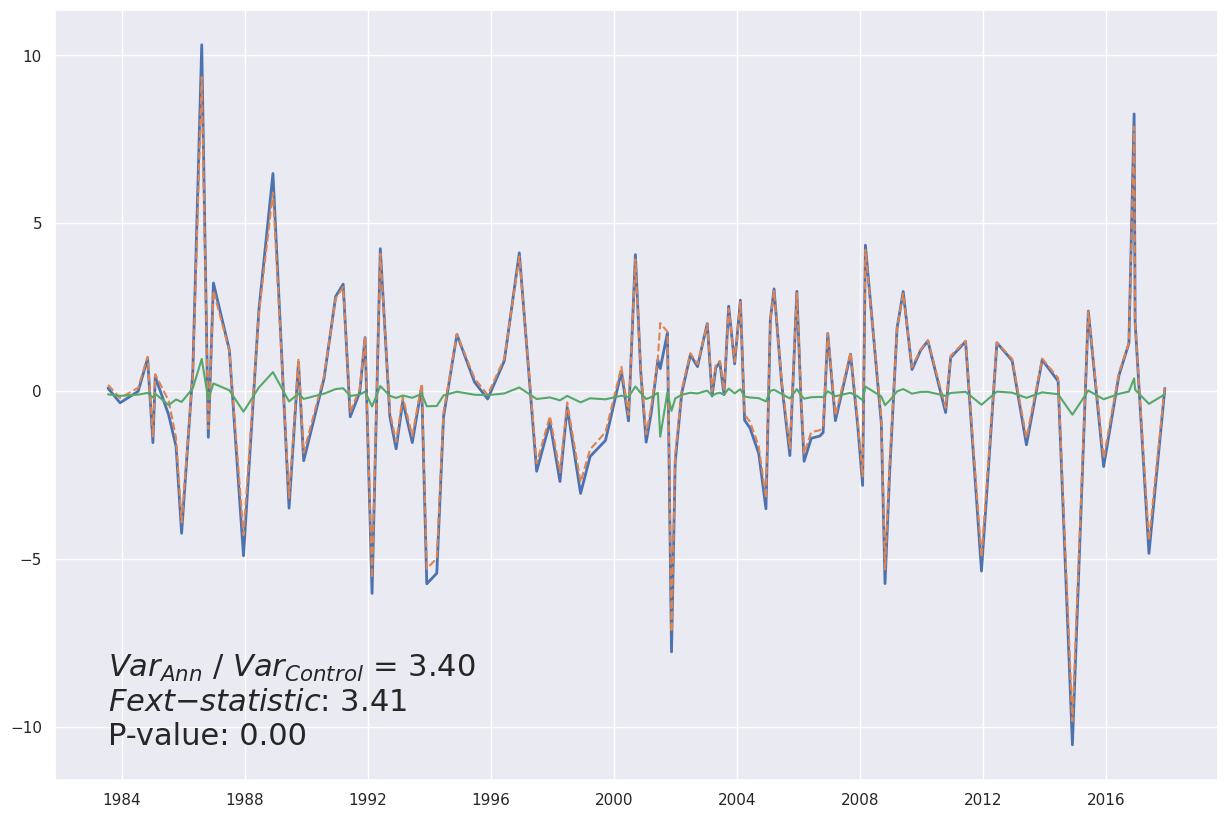

In [12]:
# Calculate variance ratio and F-statistic
f_value, p_value = f_statistic_calculation(OTDdata.pca_comp_1.values, PDdata.pca_comp_1.values)
var_ratio = np.var(OTDdata.pca_comp_1.values) / np.var(PDdata.pca_comp_1.values)

# Plotting

plt.text(OTDdata.index.min(), OTDdata.pca_comp_1.min(), 
         f'$Var_{{Ann}}$ / $Var_{{Control}}$ = {var_ratio:.2f}\n$F\text{{-statistic}}$: {f_value:.2f}\nP-value: {p_value:.2f}', 
         fontsize=22)

plt.plot(OTDdata.pca_comp_1, label='My Surprises', linewidth=2)
plt.plot(OTDdata.index, data1[:117].values, label='Känzig Surprises', linestyle='dashed')
plt.plot(OTDdata.index, OTDdata.pca_comp_1.values - data1.values[:117], label='Difference between PC')
plt.title("Level")
plt.grid(True)
plt.legend()
plt.savefig('./Kanzig/Figure1.pdf', bbox_inches='tight')

plt.show()


Probability of x > 1 for Announcement KDE: 0.3378


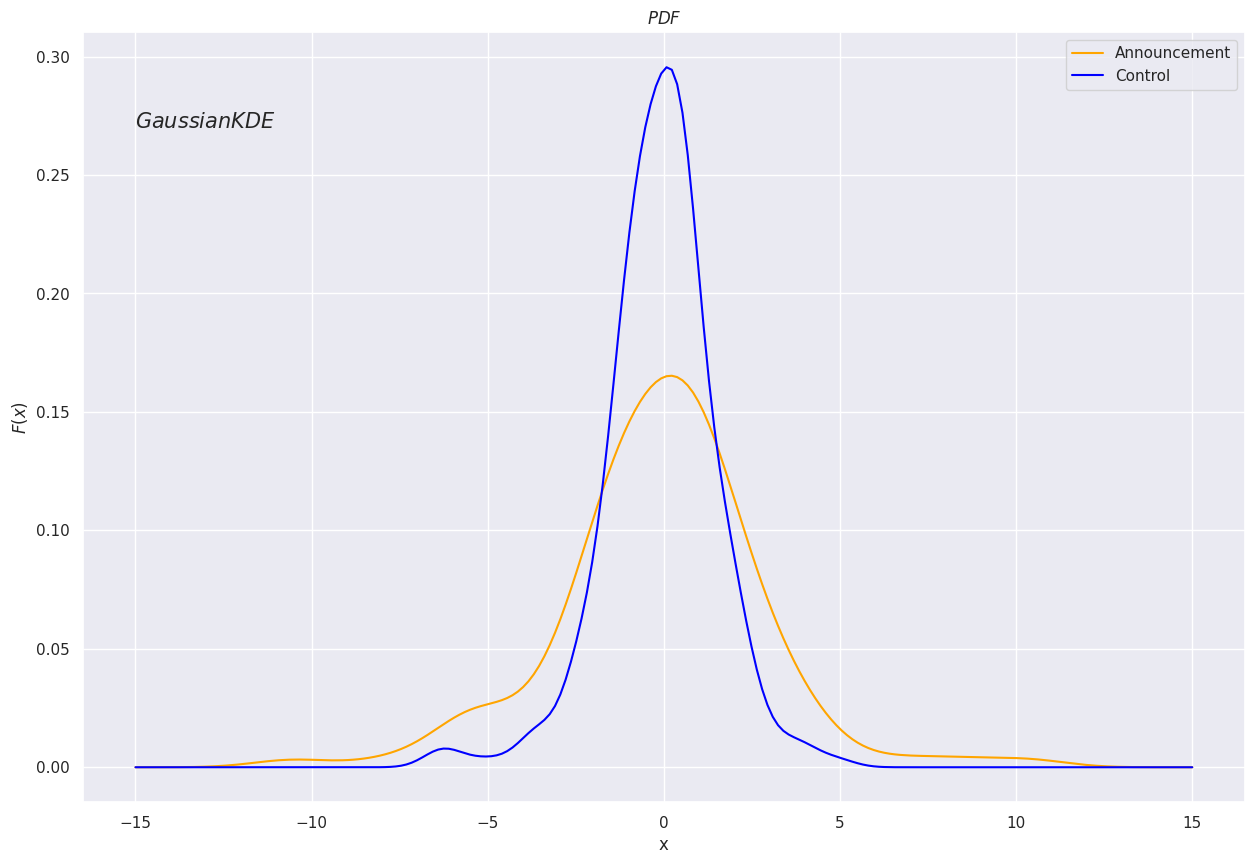

In [13]:
# Main data
OTDdata_values = OTDdata.pca_comp_1.values
PDdata_values = PDdata.pca_comp_1.values

# Create KDE objects
kde1 = scipy.stats.gaussian_kde(OTDdata_values)
kde2 = scipy.stats.gaussian_kde(PDdata_values)

# Evaluate KDE on a linspace
x_eval = np.linspace(-15, 15, num=200)


plt.text(-15,0.27,'$Gaussian KDE$',fontsize = 15)

# Plot KDEs
plt.plot(x_eval, kde1(x_eval), 'orange', label='Announcement')
plt.plot(x_eval, kde2(x_eval), 'blue', label='Control')

# Calculate and print the probability for x > 1 for the Announcement KDE
probability_x_gt_1 = kde1.integrate_box_1d(1, np.inf)
print(f'Probability of x > 1 for Announcement KDE: {probability_x_gt_1:.4f}')

# Customize plot
plt.xlabel("x")
plt.ylabel(r'$F(x)$')
plt.title(r'$PDF$')
plt.legend()
plt.grid(True)
plt.savefig('./Kanzig/Figure2.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
# Extract dates and convert to datetime
dates_strings = [str(x[0][0]) for x in ODM['datesStringRaw']]
dates = pd.to_datetime(dates_strings, format='%YM%m')

# Create a DataFrame directly from the dictionary
GENdata = pd.DataFrame({
    'CPI': ODM['CPI'][:, 0],
    'IP': ODM['IP'][:, 0],
    'OILPROD': ODM['OILPROD'][:, 0],
    'OILSTOCKS': ODM['OILSTOCKS'][:, 0],
    'POIL': ODM['POIL'][:, 0],
    'WORLDIP': ODM['WORLDIP'][:, 0]
}, index=dates)

# Concatenate the necessary DataFrames
Conc2 = pd.concat([OTDdata1, PDdata1]).loc[~pd.concat([OTDdata1, PDdata1]).index.duplicated()]
All = pd.concat([GENdata, Conc2], axis=1)


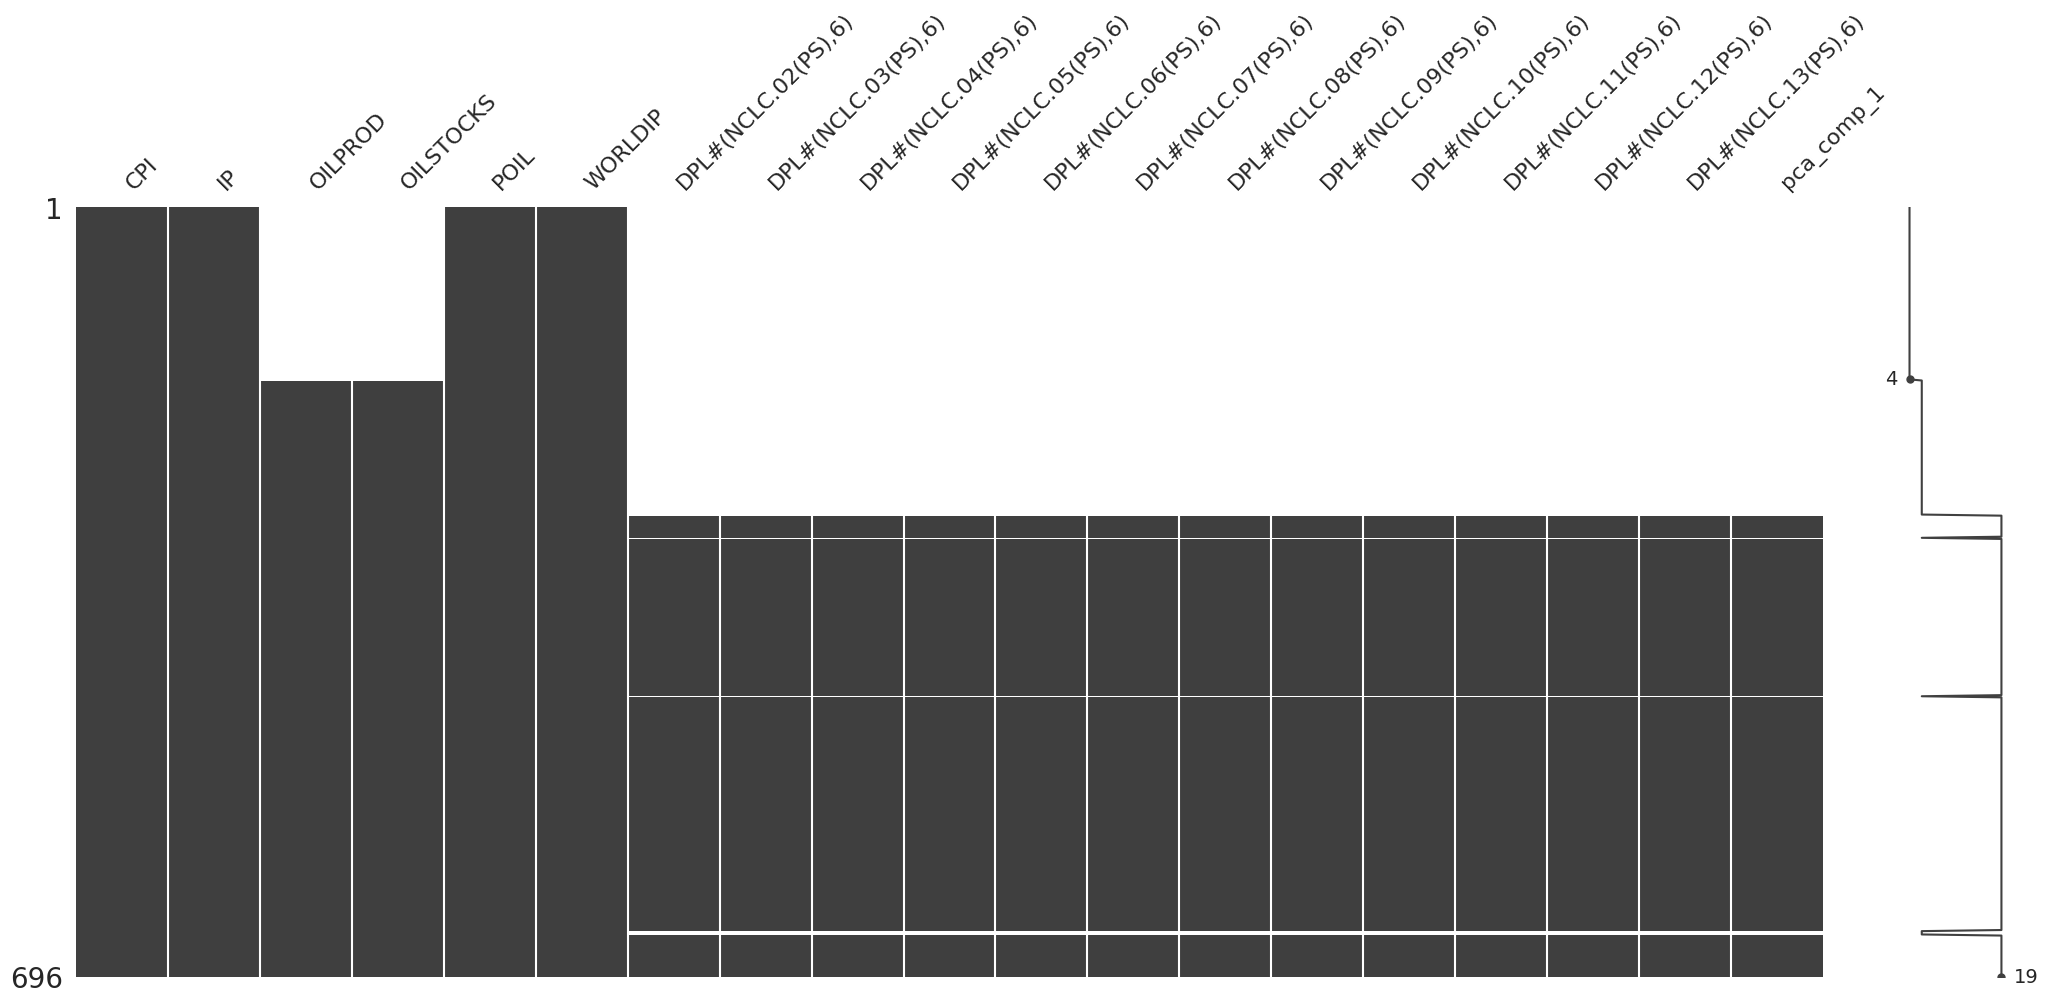

In [15]:

msno.matrix(All) 
plt.savefig('./Kanzig/Figure3.pdf', bbox_inches='tight')


In [16]:
# Combine GENdata and OTDdata1, drop NaN values
OTDin = pd.concat([GENdata, OTDdata1], axis=1).dropna()

# Filter All DataFrame based on date range and fill NaN values with 0
All = All['2017-12-12' >= All.index][All.index >= '1974-01-01'].fillna(0)

# Extract and reindex columns in All1
All1 = All.iloc[:, 0:6].reindex(columns=['POIL', 'CPI', 'IP', 'OILSTOCKS', 'OILPROD', 'WORLDIP'])

# Apply log transformation to selected columns and multiply by 100
log_transform_columns = ['OILPROD', 'OILSTOCKS', 'WORLDIP', 'CPI', 'IP']
All1[log_transform_columns] = np.log(All1[log_transform_columns]) * 100

# Retrieve 'POIL' column from GG DataFrame and assign it to All1
GG = pd.DataFrame(dataBaseM['data'], columns=pd.DataFrame(dataBaseM['varNames']).applymap(lambda x: x[0]).values[0])
All1['POIL'] = GG.iloc[:, 0].values

In [17]:
# Define constants
n = 6
nvar = 1
p = 24
alpha = 0.05

# Prepare the lagged regressors
X = All1.iloc[:, :n]
X = np.concatenate([X.shift(i) for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Prepare the endogenous variable and instrument
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = All1.iloc[p:, :n].values

# Perform OLS regression
ols_results = SVARIV.ols(Y, X)
eta = ols_results['errors']

# Calculate the F-statistic and p-value
F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)

# Display F-statistic and p-value
print(f'F-statistics: {F:.2f}\nP-value: {p_value:.2f}')

# Test Wald and Gamma_hat
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)
print('Gamma_hat estimated:')
print(Gamma_hat)
print(f'Wald estimated: {wald:.4f}')
print(f'Critical value (95%): {stats.chi2.ppf(0.95, df=1):.4f}')


F-statistics: 11.74
P-value: 1.00
Gamma_hat estimated:
[[ 2.84270254]
 [ 0.04189462]
 [-0.02355244]
 [-0.00449321]
 [ 0.06497218]
 [ 0.00121128]]
Wald estimated: 22.7005
Critical value (95%): 3.8415


In [18]:
from linearmodels.iv import IV2SLS

res_ols = IV2SLS(eta.T[0], Z, None,None).fit(
    cov_type="robust"
)
print(res_ols)

                            OLS Estimation Summary                            
Dep. Variable:              dependent   R-squared:                      0.0645
Estimator:                        OLS   Adj. R-squared:                 0.0626
No. Observations:                 504   F-statistic:                    17.605
Date:                Mon, Apr 08 2024   P-value (F-stat)                0.0000
Time:                        23:10:09   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           0.8690     0.2071     4.1958     0.0000      0.4631      1.2750


In [19]:
# Initialize empty lists to store results
n = 6
nvar = 1
p = 24
alpha = 0.05

# Prepare the lagged regressors
X = All1.iloc[:, :n]
X = np.concatenate([X.shift(i) for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Prepare the endogenous variable and instrument
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = All1.iloc[p:, :n].values

f_statistic_values = []
adjusted_r_squared_values = []

ols_results = SVARIV.ols(Y, X)
eta = ols_results['errors']


# Iterate over columns 6 to 18 in All DataFrame
for col in All.iloc[:, 6:19].columns:
    # Extract the relevant data for the current column
    Z1 = pd.DataFrame(All[col]).values[p:, :]
    
    # Perform IV2SLS regression
    res_ols = IV2SLS(eta.T[0], Z1, None, None).fit(cov_type="robust")
    
    # Append F-statistic and adjusted R-squared to the respective lists
    f_statistic_values.append([col, res_ols.f_statistic.stat])
    adjusted_r_squared_values.append(res_ols.rsquared_adj)

# Create a DataFrame from the collected results
result_table = pd.DataFrame(f_statistic_values)
result_table['$R^2$'] = adjusted_r_squared_values

# Define the column names for the result table
column_names = list(range(1, 13, 1))
column_names.append('pca_comp1')

# Transpose the result table, set clumn names, and drop unnecessary rows
result_table = result_table.T
abd=[]
for i in range(1,len(column_names)):

    abd.append(str('WTI Futures month '+str(i)))
abd.append('PCA first component')
result_table.columns = abd
result_table = result_table.drop(0, axis=0)
result_table.index = ['F-stat (robust)', '$R^2$ adjusted']

# Display the result table
latex_table3 = result_table.to_latex()
#with open('./Latex_doc/Tables/WTI.tex', 'w') as f:
    #f.write(latex_table3)
result_table


WTI Futures month 1 WTI Futures month 2 WTI Futures month 3  \
F-stat (robust)             18.8502             19.0883             18.9416   
$R^2$ adjusted               0.0679              0.0683              0.0675   

                WTI Futures month 4 WTI Futures month 5 WTI Futures month 6  \
F-stat (robust)             18.5689             18.1514             18.0696   
$R^2$ adjusted               0.0657              0.0638              0.0626   

                WTI Futures month 7 WTI Futures month 8 WTI Futures month 9  \
F-stat (robust)             17.9681             18.0365             17.8379   
$R^2$ adjusted               0.0616              0.0612              0.0597   

                WTI Futures month 10 WTI Futures month 11  \
F-stat (robust)              17.0772              12.0580   
$R^2$ adjusted                0.0574               0.0418   

                WTI Futures month 12 PCA first component  
F-stat (robust)              10.4302             17.6050  
$R^2$ adjusted                0.0271              0.0626

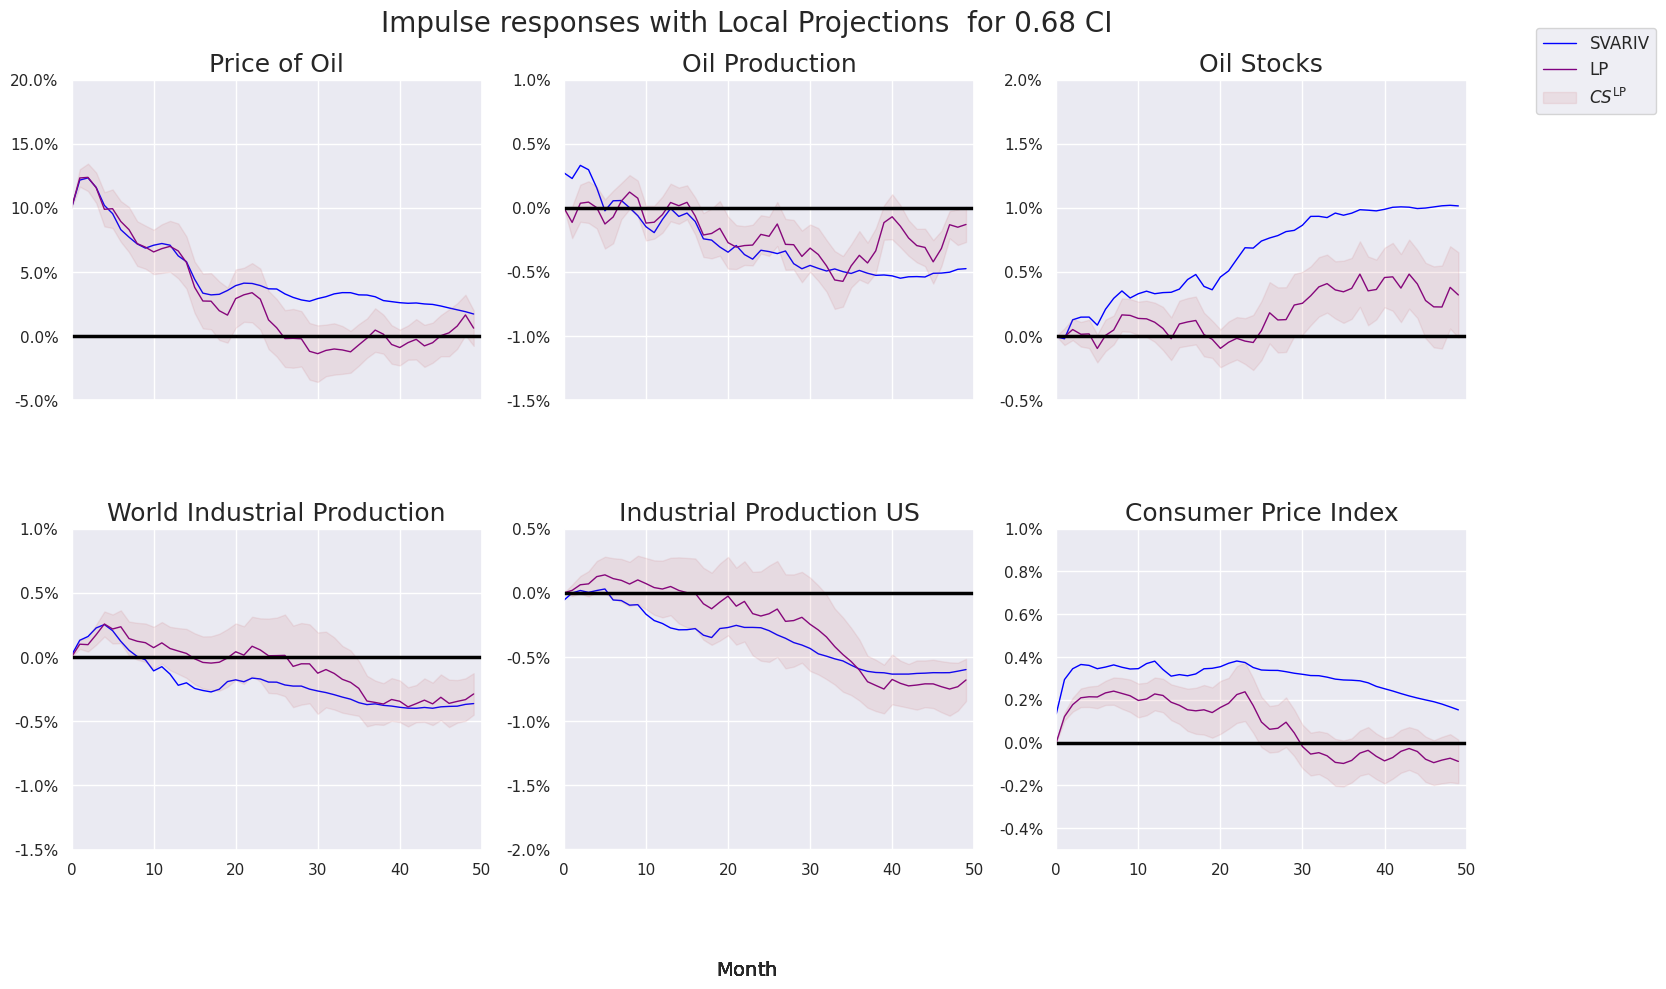

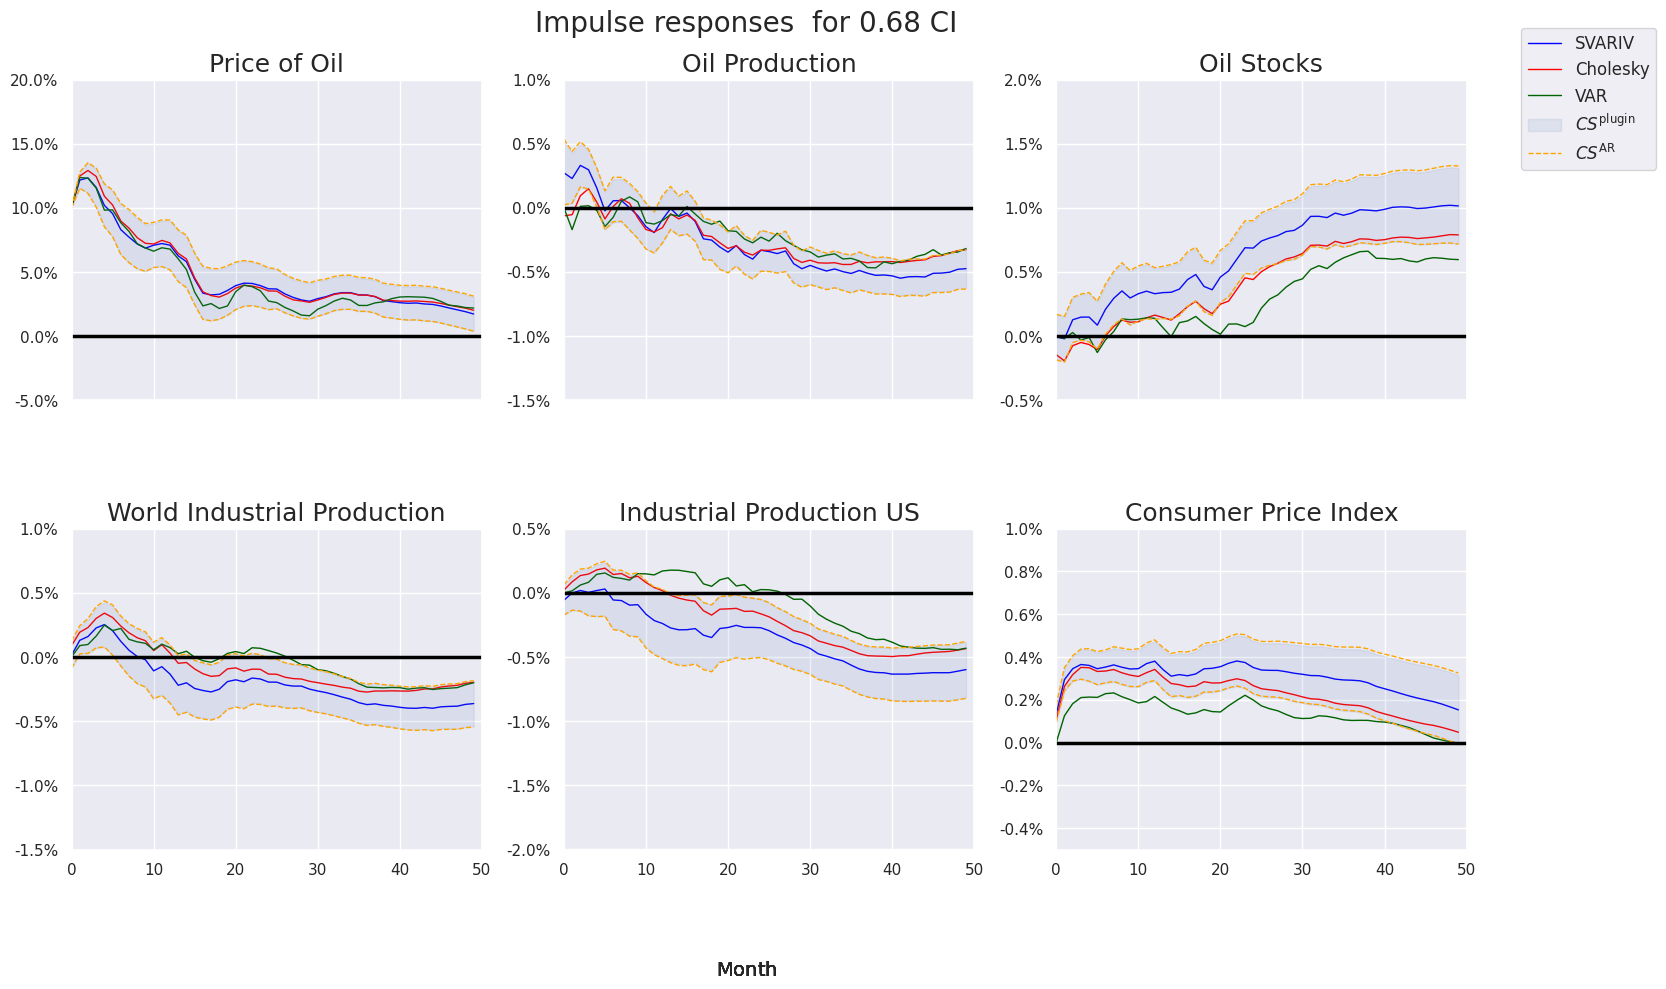

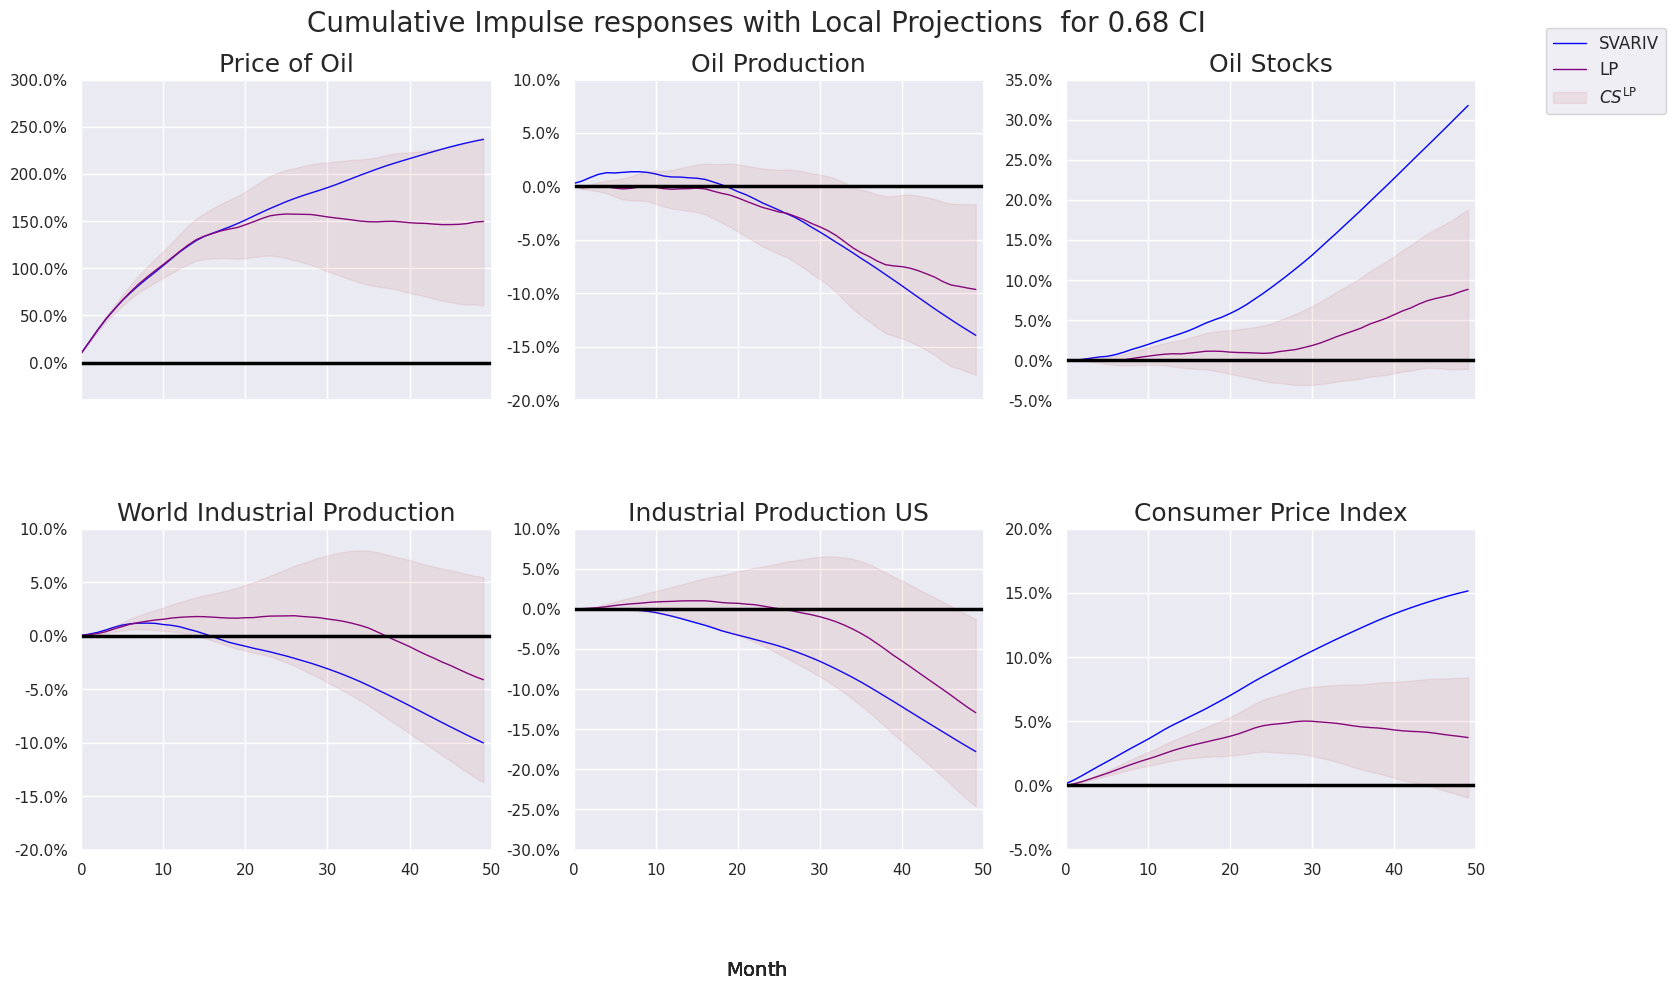

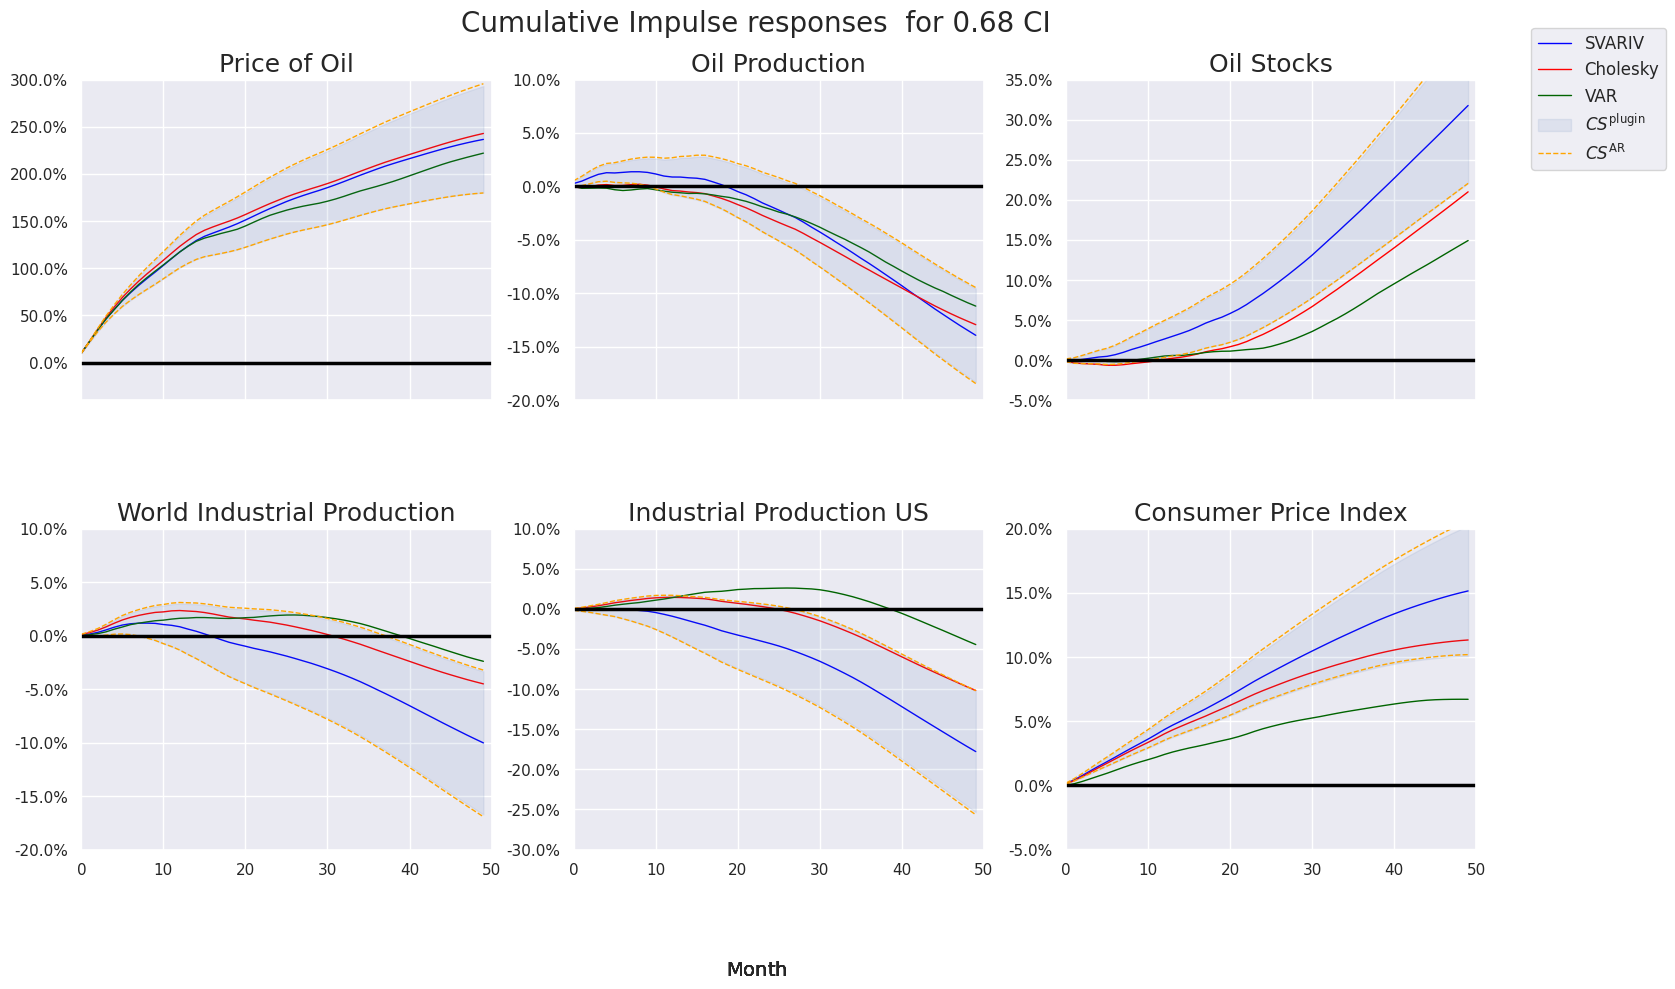

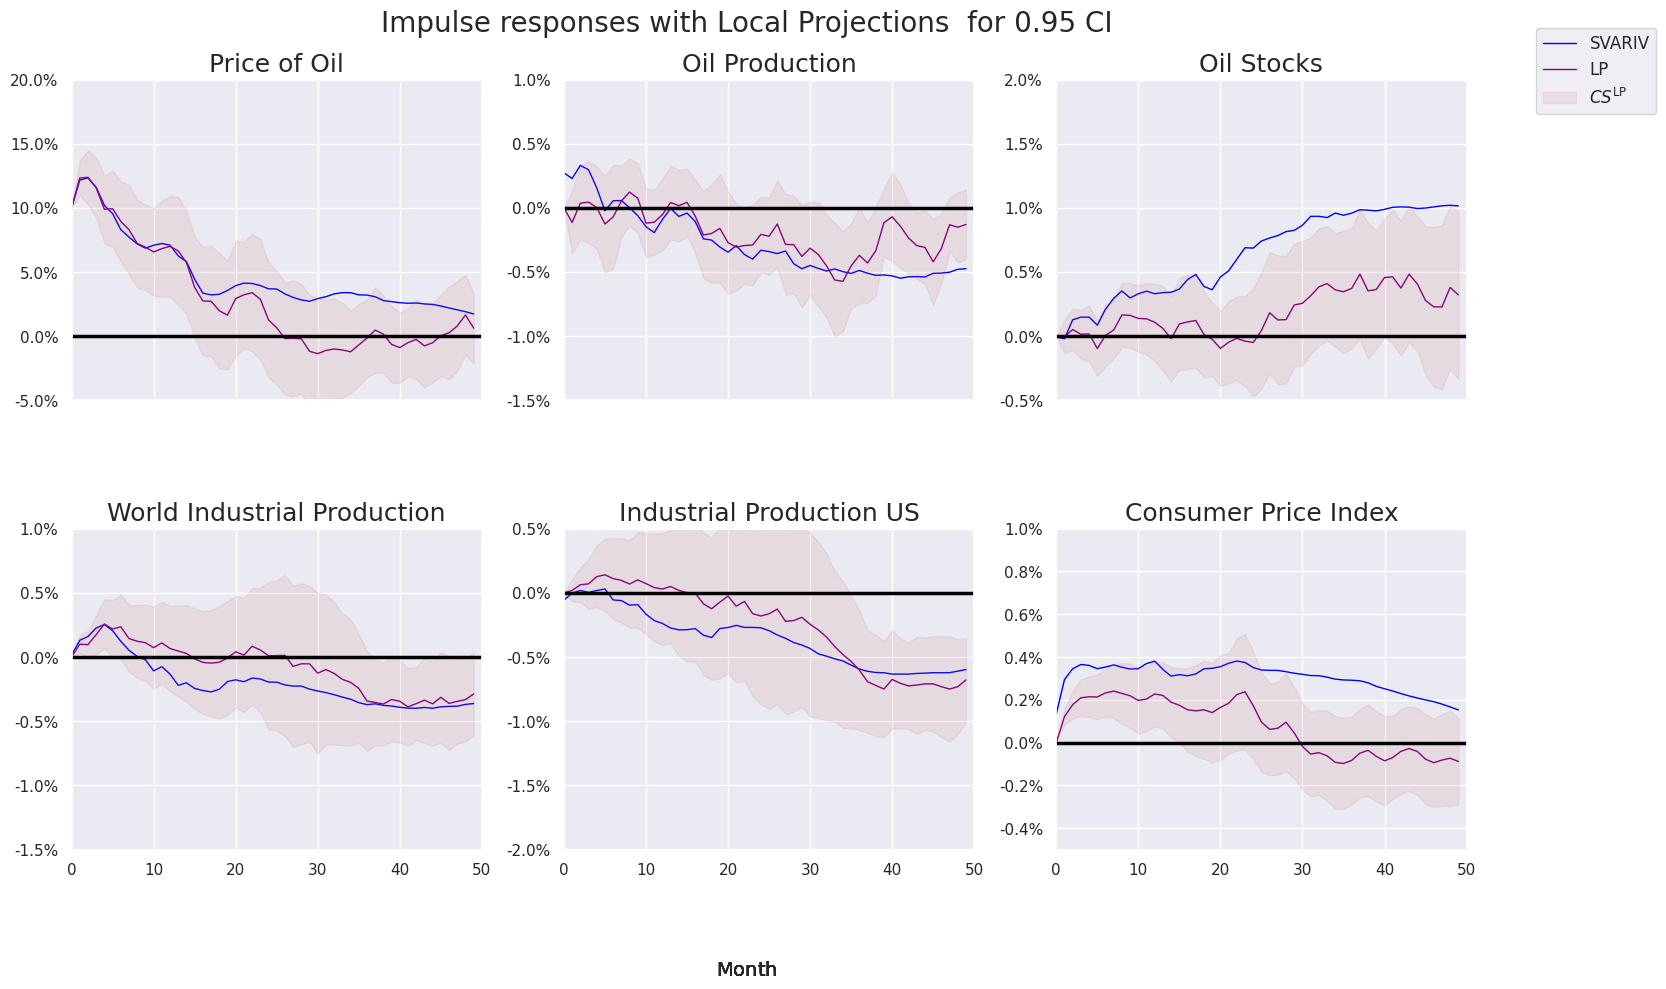

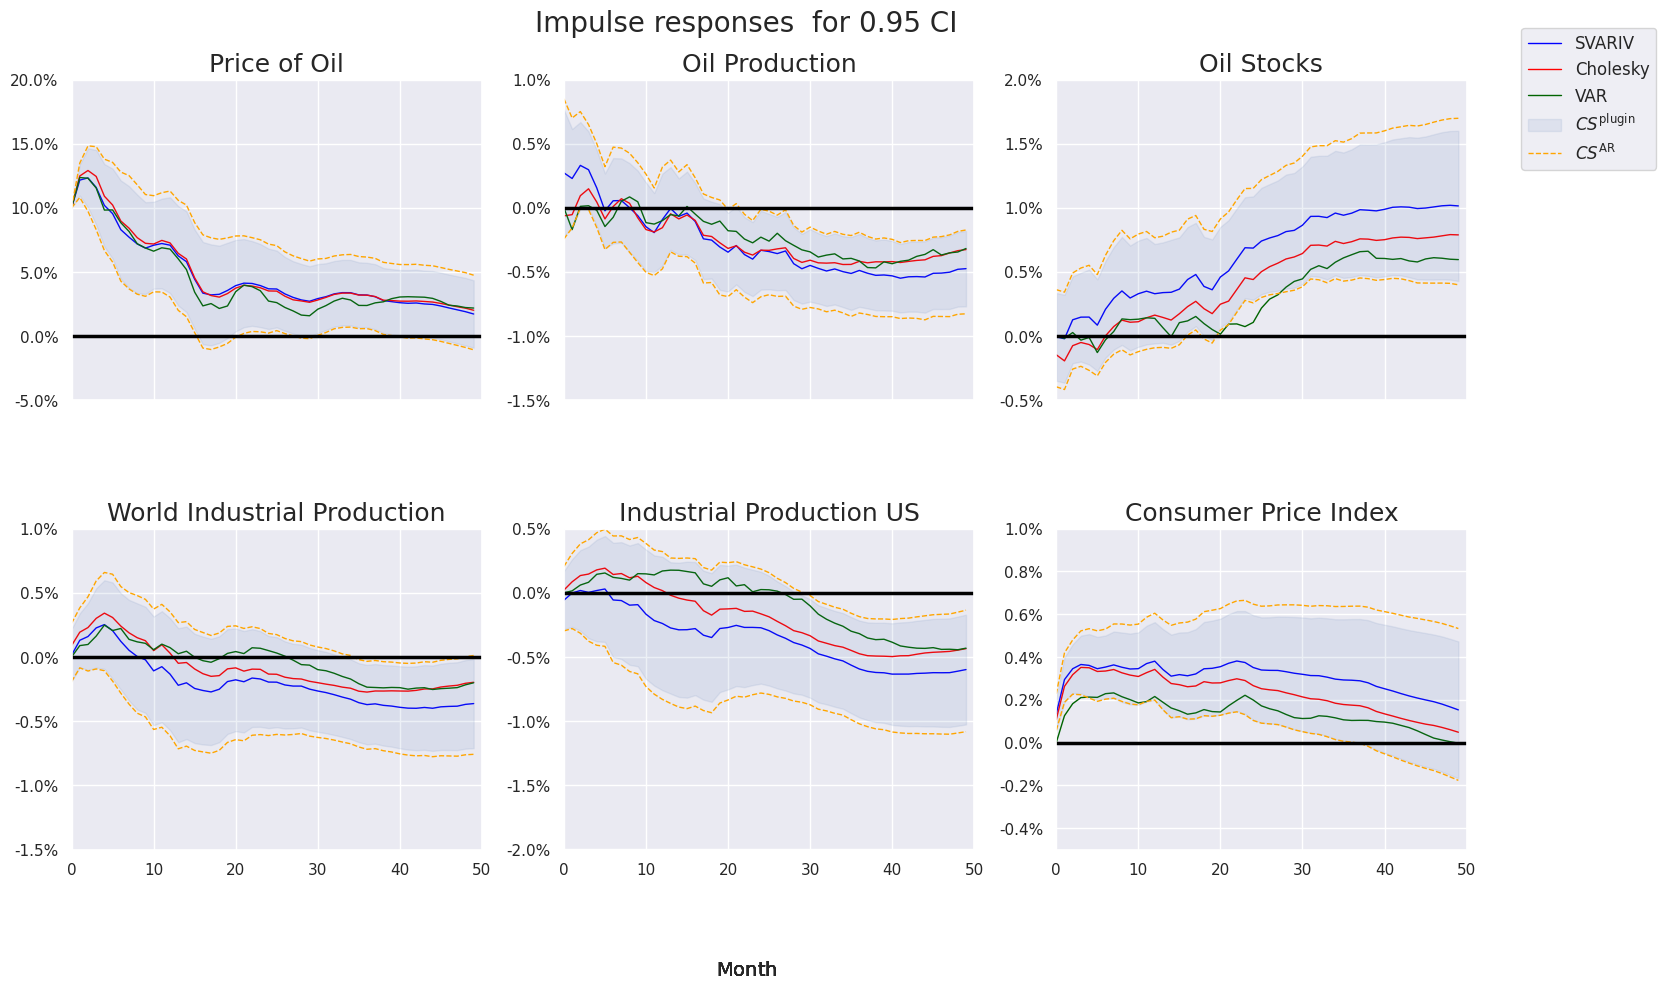

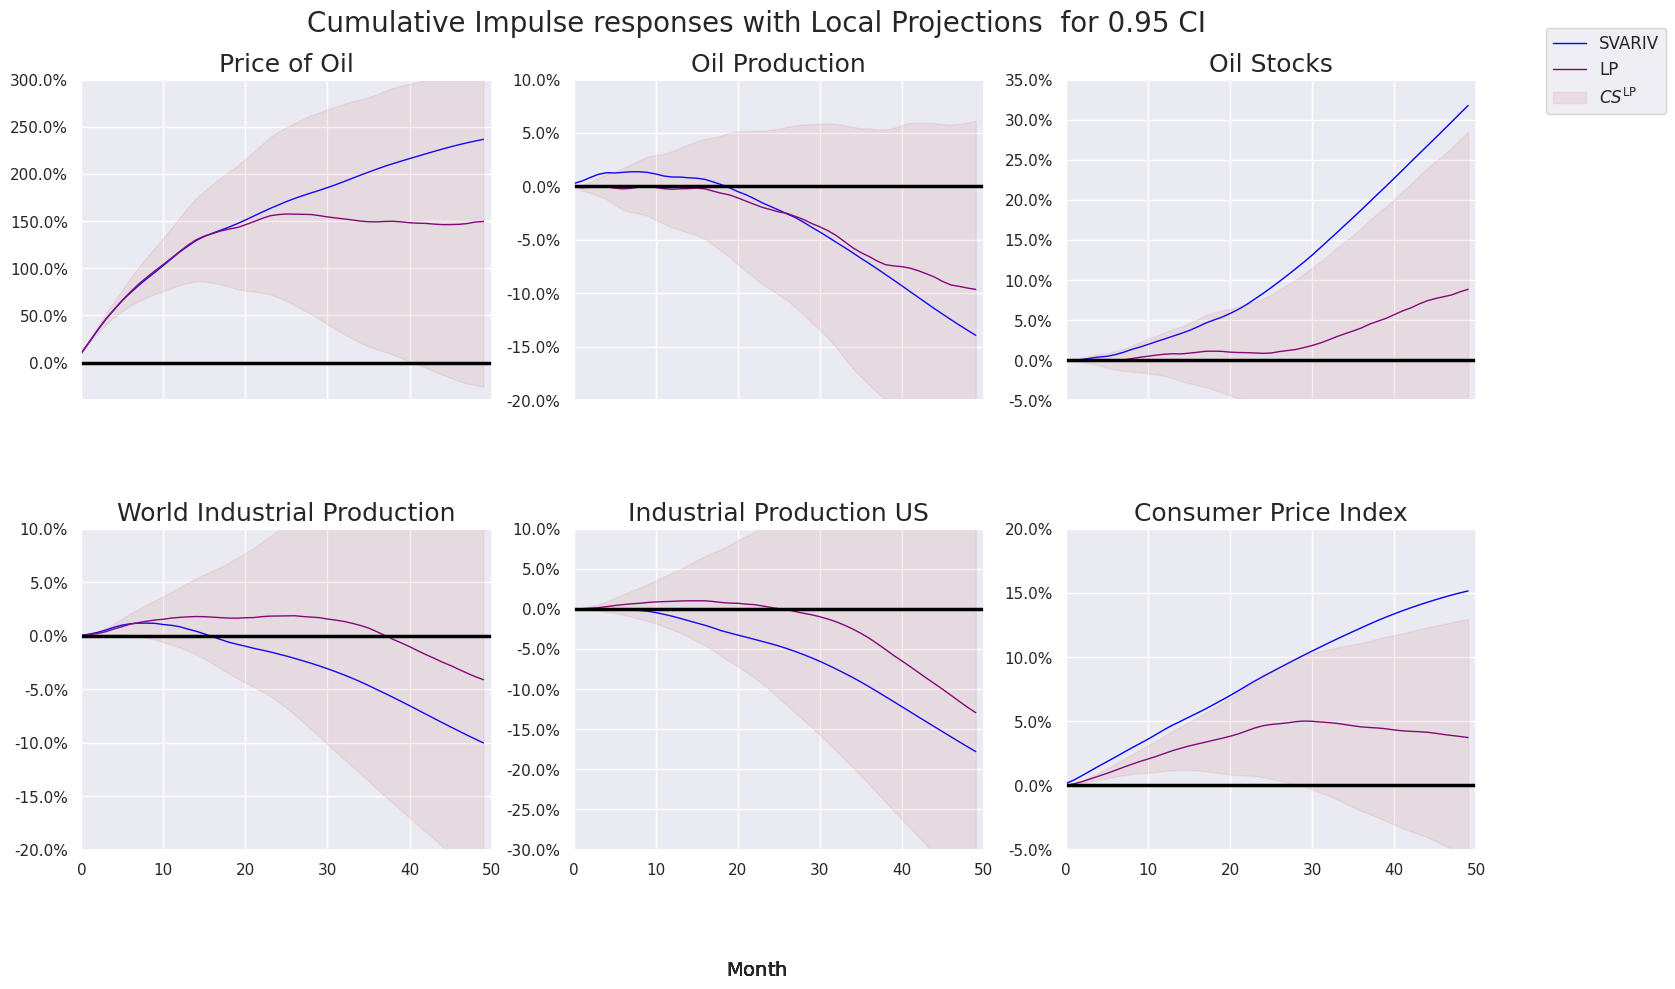

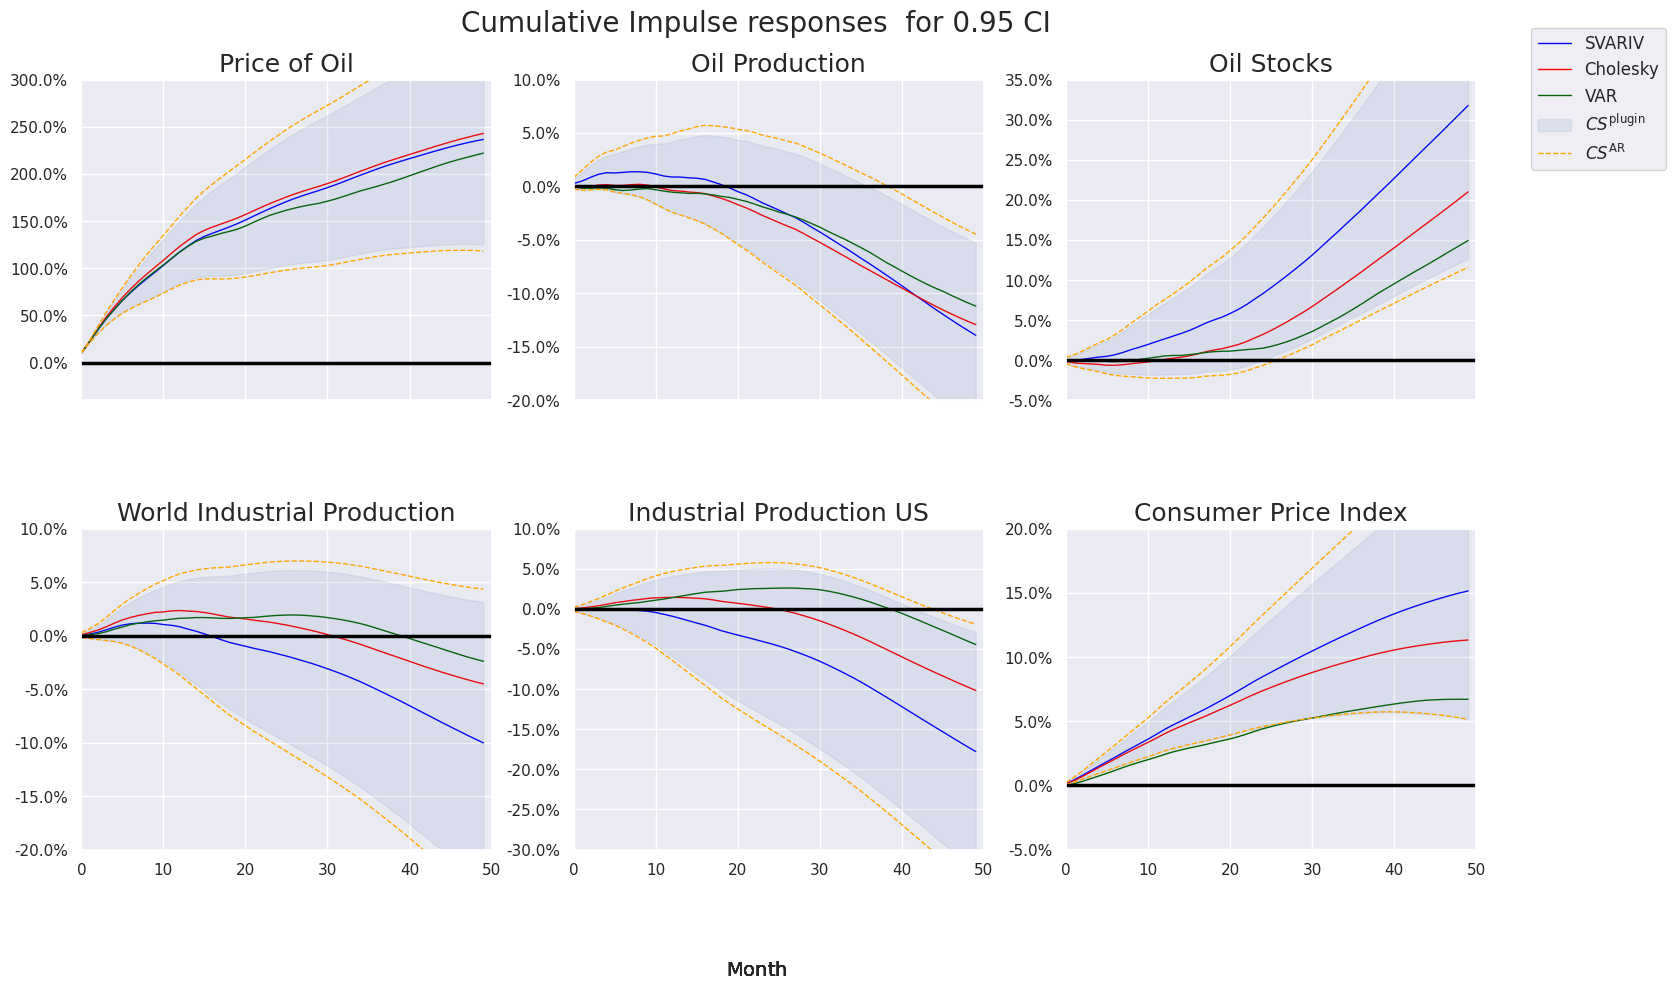

In [20]:
rot = 0
hori =50
h=hori
p=20
legend = None


# Define the desired order of columns
desired_order = ['POIL', 'OILPROD', 'OILSTOCKS', 'WORLDIP', 'IP', 'CPI']
All1 = All1[desired_order]

# Prepare lagged input matrix X for SVAR model
X = (All1.iloc[:, 0:n])
X.columns = range(X.columns.size)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Extracting variables for SVAR analysis
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = pd.DataFrame(All1.iloc[:, 0:n]).values[p:, :]

# Estimate OLS residuals and perform SVAR analysis
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']
# Set up SVAR parameters
nvar = 1
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

# Extract parameters for impulse response functions
betas = ols_est['betas_hat'].T
betas_lag = betas[:, 1:]
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

# Compute impulse response functions for SVAR and Cholesky
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h)

# Fit VAR model for comparison
model = VAR(All1.dropna())
results = model.fit(24)
VAR1 = ((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1)

# Compute moving average representation matrices
C = SVARIV.MA_representation(betas_lag, p, hori=h)
Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
T = len(Y)

# Set up plotting parameters
xticks = list(range(len(irf_gamma_cum)))

# Confidence Intervals and Cumulative options
conf_intervals = [0.68, 0.95]
Lp1 = [True, False]

cumulative_options = [False, True]

# Titles for each subplot
titles = map_column_names_to_labels(desired_order)

# Loop over confidence intervals and cumulative options
for ci_idx, ci in enumerate(conf_intervals):
    
    CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1)
    CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1)
    

    lpmdl = LP.LP(All1.reset_index(drop=True),maxlags=p,ci=ci)
    out, _ = lpmdl.estimate(hori,shock_size =0.1)
    # Select rows where impulse is 'POIL'
    poil_df = out.loc['POIL']

    # Reset the index to create a one-index DataFrame
    poil_df_reset = poil_df.reset_index()
    coef = pd.DataFrame()
    lb = pd.DataFrame()
    ub = pd.DataFrame()

    for colmn in All1.columns:
        coef[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['coef'].values[:-1]
        lb[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['lb'].values[:-1]
        ub[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['ub'].values[:-1]

    coef_cum=np.cumsum(coef)
    lb_cum=np.cumsum(lb)
    ub_cum=np.cumsum(ub)
    
    # Create a new figure for each combination
    for cum_idx, cum_opt in enumerate(cumulative_options):
        for lp_opt in (Lp1):
            
            fig, axs = plt.subplots(split_into_close_integers(len(All1.columns))[0],split_into_close_integers(len(All1.columns))[1], figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
            axs_flat = axs.flatten()
        
            for i, ax in enumerate(axs_flat):
                title = titles[i]
                col = All1.columns[i]

                if i >= len(titles):
                    fig.delaxes(ax)  
                    continue

                # Set y-axis limits based on the column and cumulative option

                if cum_opt:
                    if col == 'POIL':
                        ylim1 = 3
                        ylim0 = -0.4
                    elif col == 'CPI':
                        ylim1 = 0.2
                        ylim0 = -0.05
                    elif col == 'WORLDIP':
                        ylim1 = 0.1
                        ylim0 = -0.2
                    elif col == 'IP':
                        ylim1 = 0.1
                        ylim0 = -0.3
                    elif col == 'OILSTOCKS':
                        ylim1 = 0.35
                        ylim0 = -0.05
                    elif col == 'OILPROD':
                        ylim1 = 0.1
                        ylim0 = -0.2
                else:
                    if col == 'POIL':
                        ylim1 = 0.2
                        ylim0 = -0.05
                    elif col == 'CPI':
                        ylim1 = 0.01
                        ylim0 = -0.005
                    elif col == 'WORLDIP':
                        ylim1 = 0.01
                        ylim0 = -0.015
                    elif col == 'IP':
                        ylim1 = 0.005
                        ylim0 = -0.02
                    elif col == 'OILSTOCKS':
                        ylim1 = 0.02
                        ylim0 = -0.005
                    elif col == 'OILPROD':
                        ylim1 = 0.01
                        ylim0 = -0.015


                # Select the appropriate impulse response functions and confidence intervals
                if cum_opt:
                    plugin_cs = np.array([irf_gamma_cum[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :],
                                          irf_gamma_cum[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :]]).T
                else:
                    plugin_cs = np.array([irf_gamma[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :],
                                          irf_gamma[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :]]).T

                low_plugin = plugin_cs[:, 0]
                upp_plugin = plugin_cs[:, 1]



                # Calculate VAR impulse response for comparison
                VAR_P = np.cumsum(((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1).iloc[i]).values[:-1] if cum_opt else \
                        (((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1).iloc[i]).values[:-1]
                if lp_opt:
                    # Plotting
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                    ax.plot(coef_cum.values[:, i] if cum_opt else coef.values[:, i], color='purple', zorder=1, linewidth=1, label='LP')
                    ax.fill_between(xticks, lb_cum.values[:, i]  if cum_opt else lb.values[:, i] , ub_cum.values[:, i] \
                                    if cum_opt else ub.values[:, i], color='r', alpha=.1, label=r'$CS^{\mathrm{LP}}$')

                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                else: 
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                    ax.plot(irf_chol_cum[:, i] if cum_opt else irf_chol[:, i], color='red', zorder=1, linewidth=1, label='Cholesky')
                    ax.plot(VAR_P, color='darkgreen', zorder=1, linewidth=1, label='VAR')
                    ax.fill_between(xticks, low_plugin, upp_plugin, color='b', alpha=.1, label=r'$CS^{\mathrm{plugin}}$')
                    ax.plot(CI_cum['l'][i, :] if cum_opt else CI['l'][i, :], '--', zorder=1, linewidth=1, color='orange', label=r'$CS^{\mathrm{AR}}$')
                    ax.plot(CI_cum['u'][i, :] if cum_opt else CI['u'][i, :], '--', zorder=1, linewidth=1, color='orange')                 
                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)

                # Add 'Cumulative' to suptitle only for cumulative options
                suptitle_str1 = 'Cumulative ' if cum_opt else '' 
                suptitle_str2= 'with Local Projections ' if lp_opt else ''
                fig.suptitle(suptitle_str1 + 'Impulse responses ' +suptitle_str2+ ' for ' +str(ci) + ' CI', fontsize=20, y=0.95)

            # Place the legend outside of the subplots
            handles, labels = axs_flat[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 0.94), fontsize=12)

            # Save the figure with a unique name based on CI and cumulative options
            saved = f'./Kanzig/IRF_pdfs/IRF_Figure1_{ci}_Cumulative_{cum_opt}_LP_{lp_opt}.pdf'
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            plt.savefig(saved, bbox_inches='tight')
            plt.show()

plt.close("all")



In [21]:
model = sm.regression.linear_model.OLS(Y,X)
results = model.fit()

In [22]:
dataR = pd.read_excel('./Main_Data/rawDataM.xlsx', sheet_name="Data", index_col=0, na_values=0)
dataR.index = pd.to_datetime(dataR.index, format='%YM%m')
dataR.index.freq = 'MS'
dataR = dataR['2017-12-12' >= dataR.index][dataR.index >= '1974-01-01'].fillna(0)
dataR1 = dataR[['UNRATE','INDPRO','PCE','PCEPI']]
dataR1['POIL']=All1['POIL']
dataR1['PCE'] = np.log(dataR1['PCE']/dataR1['PCEPI'])*100


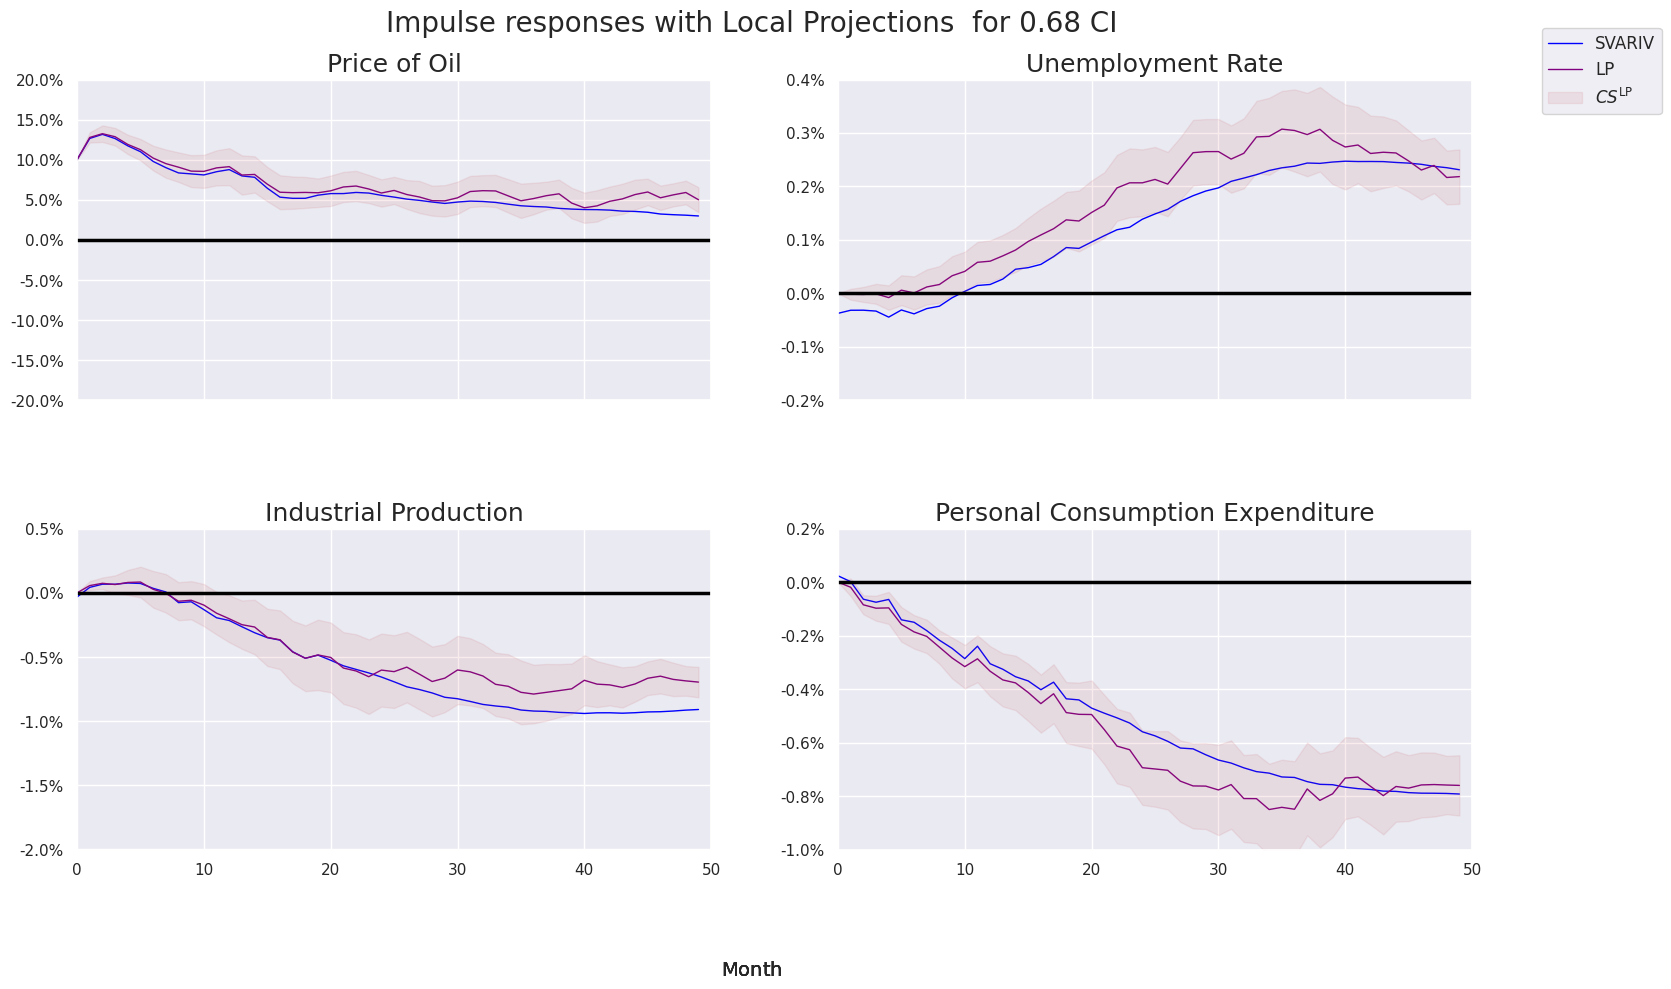

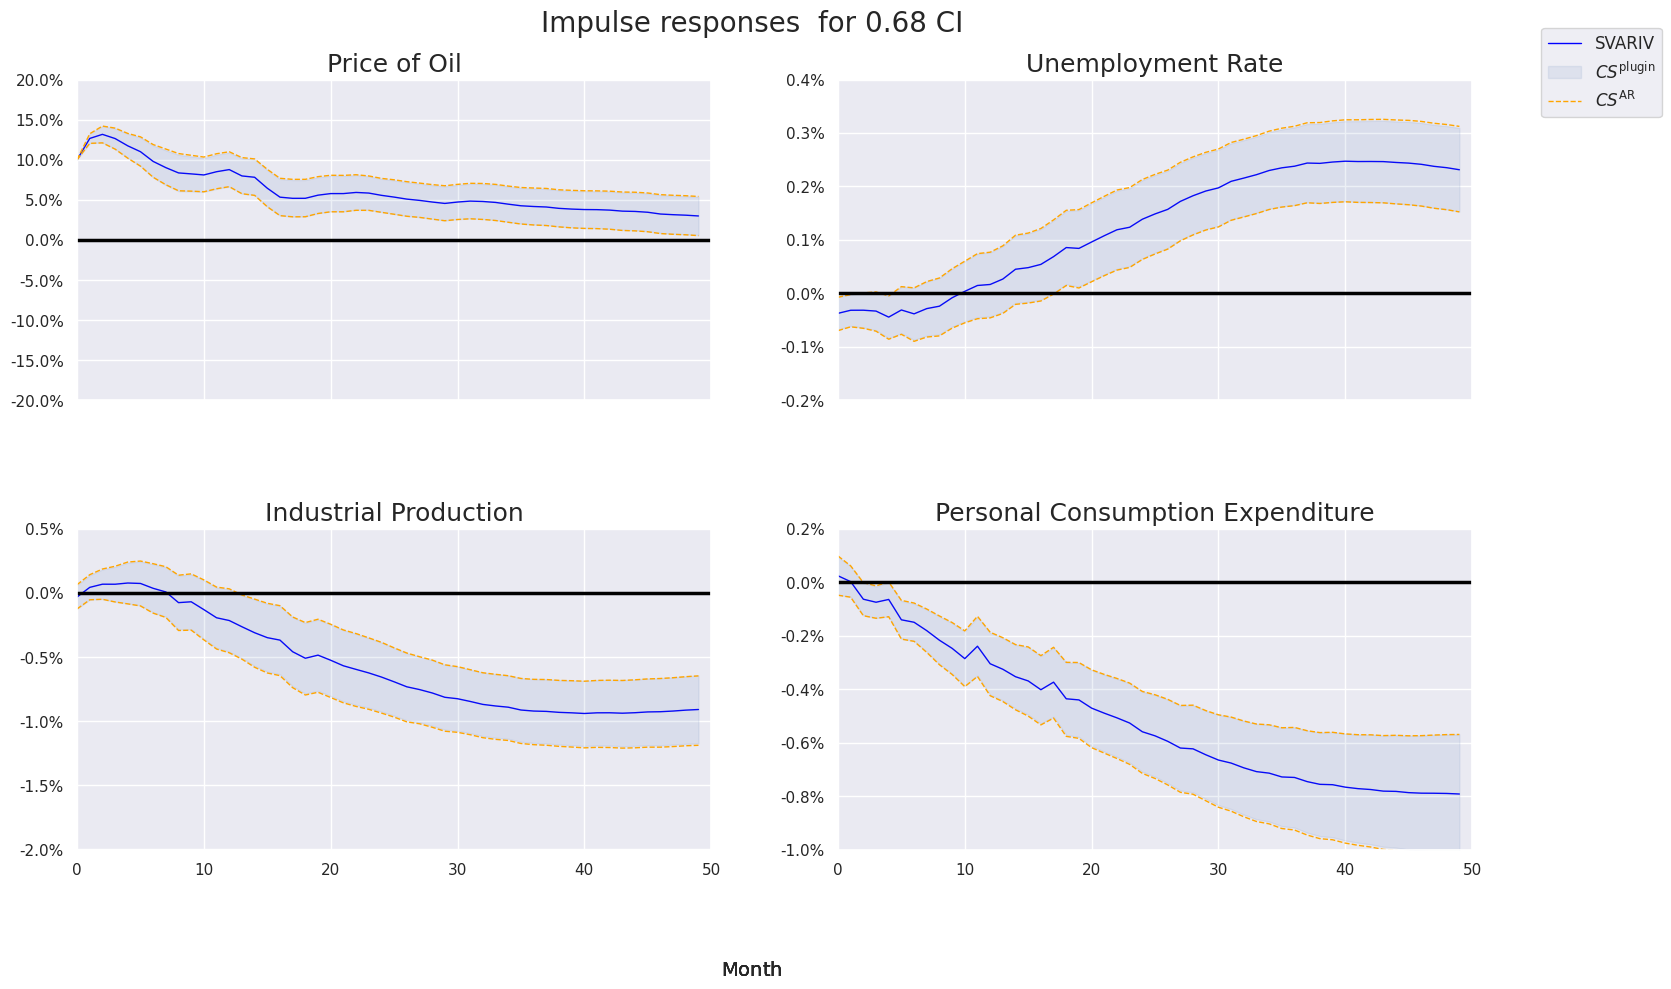

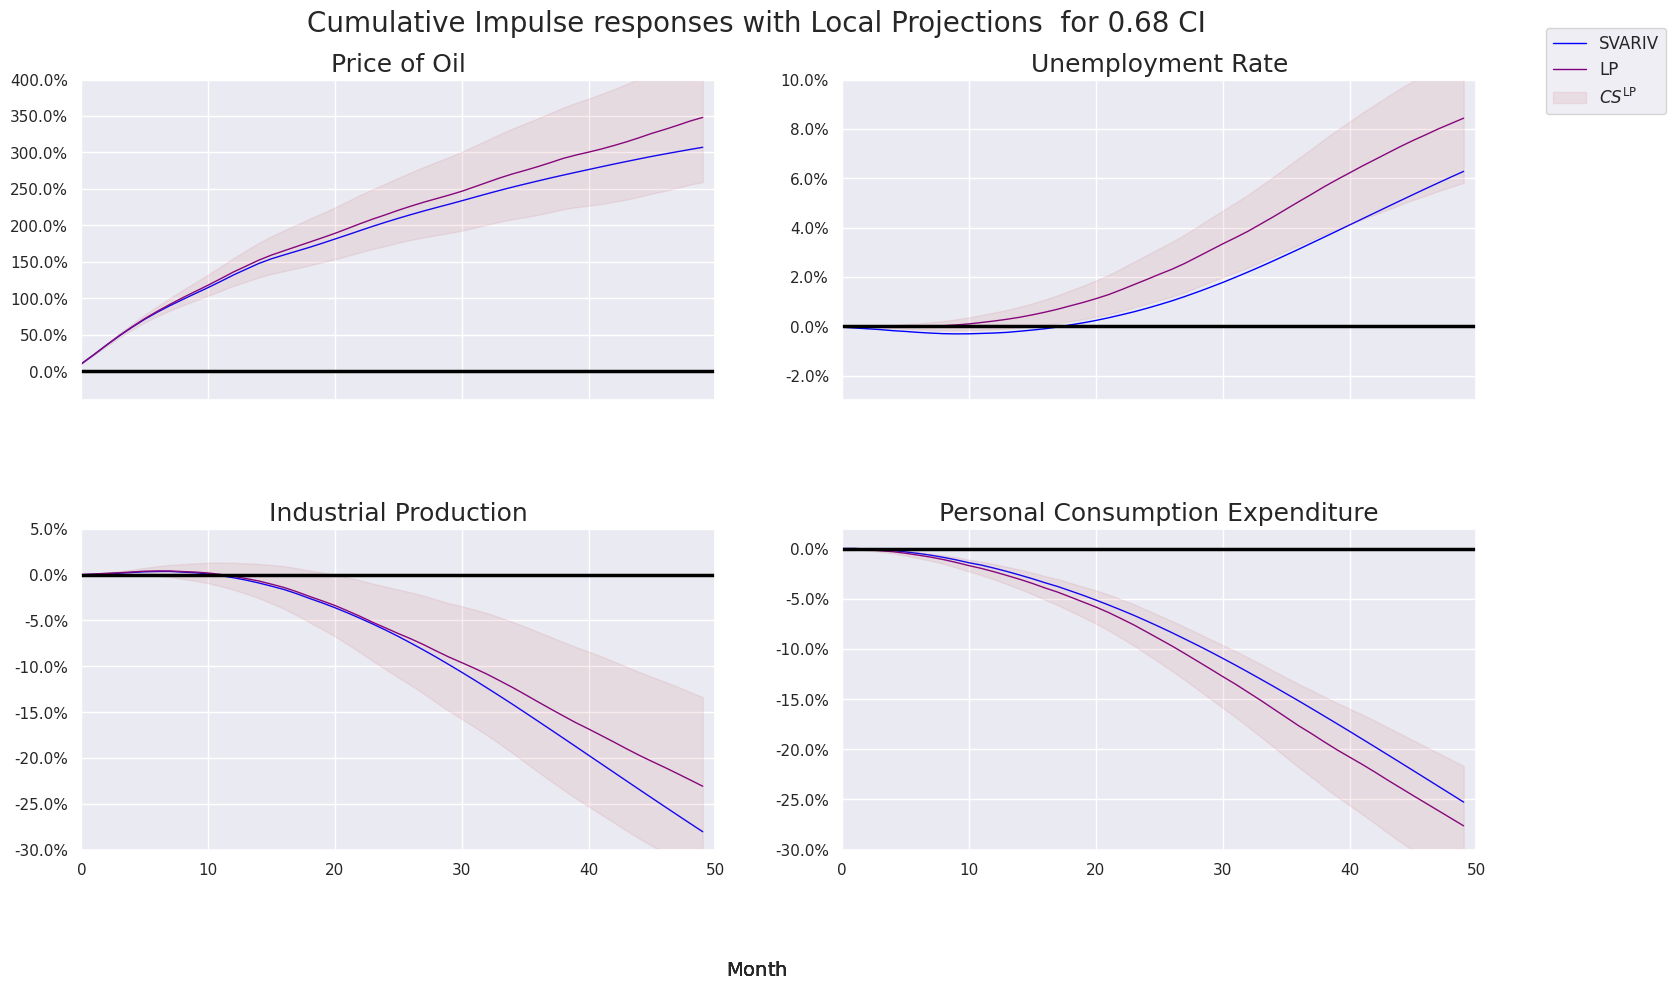

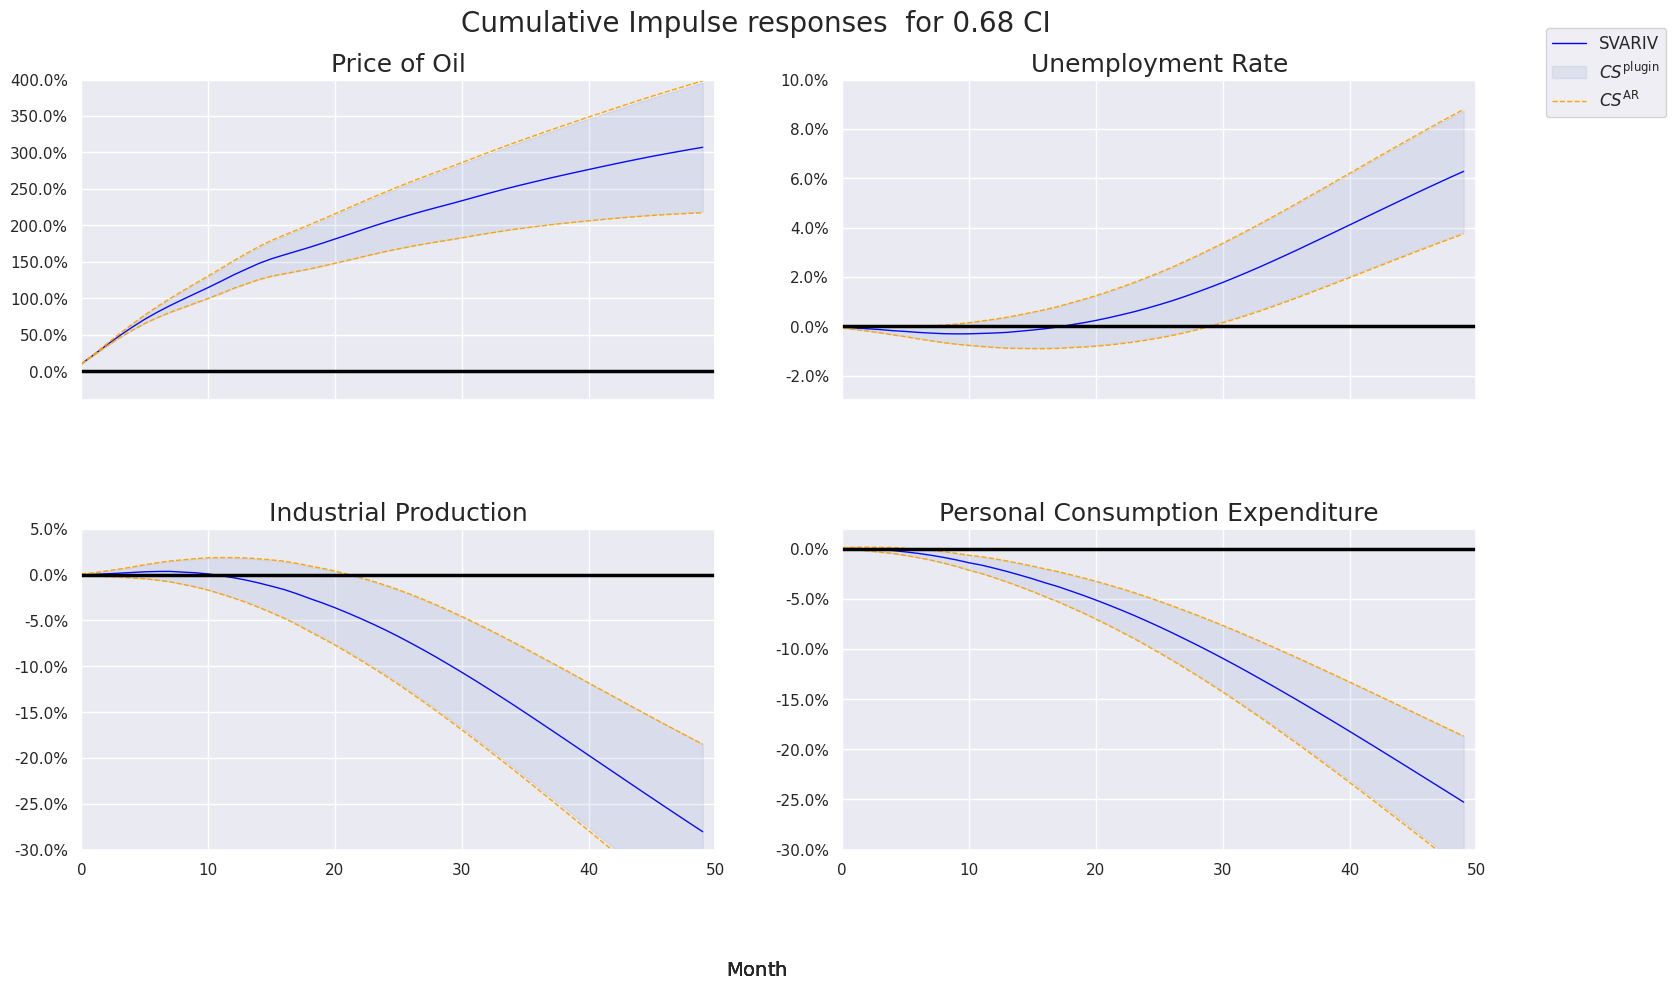

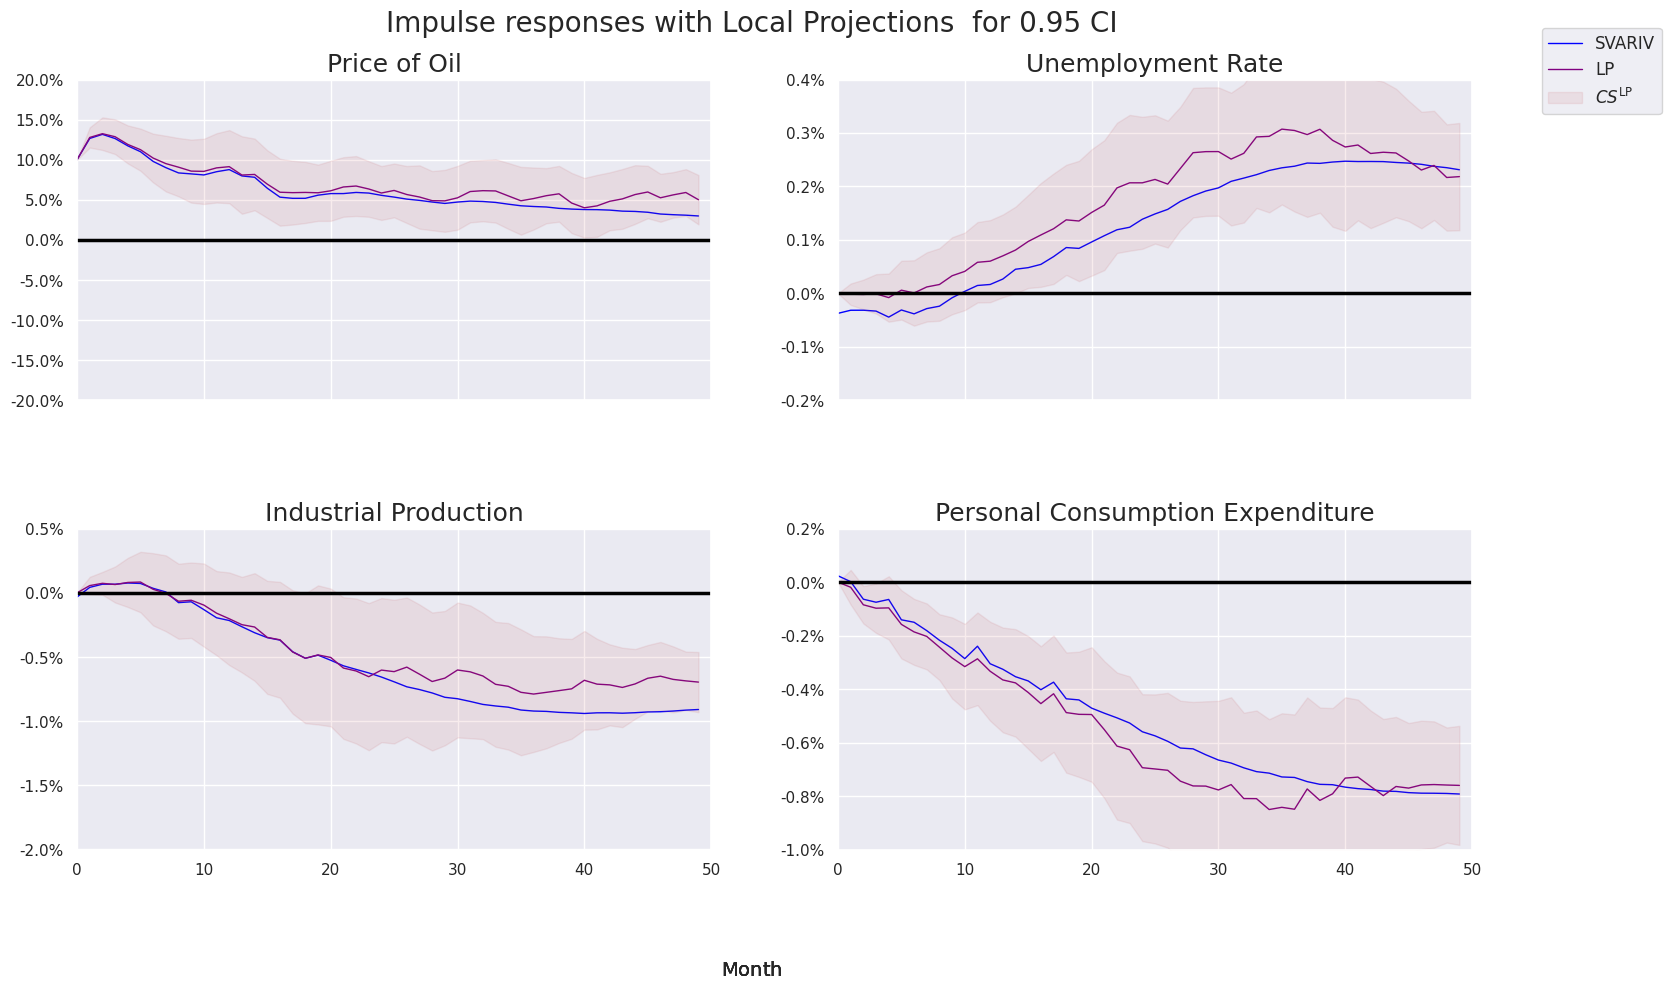

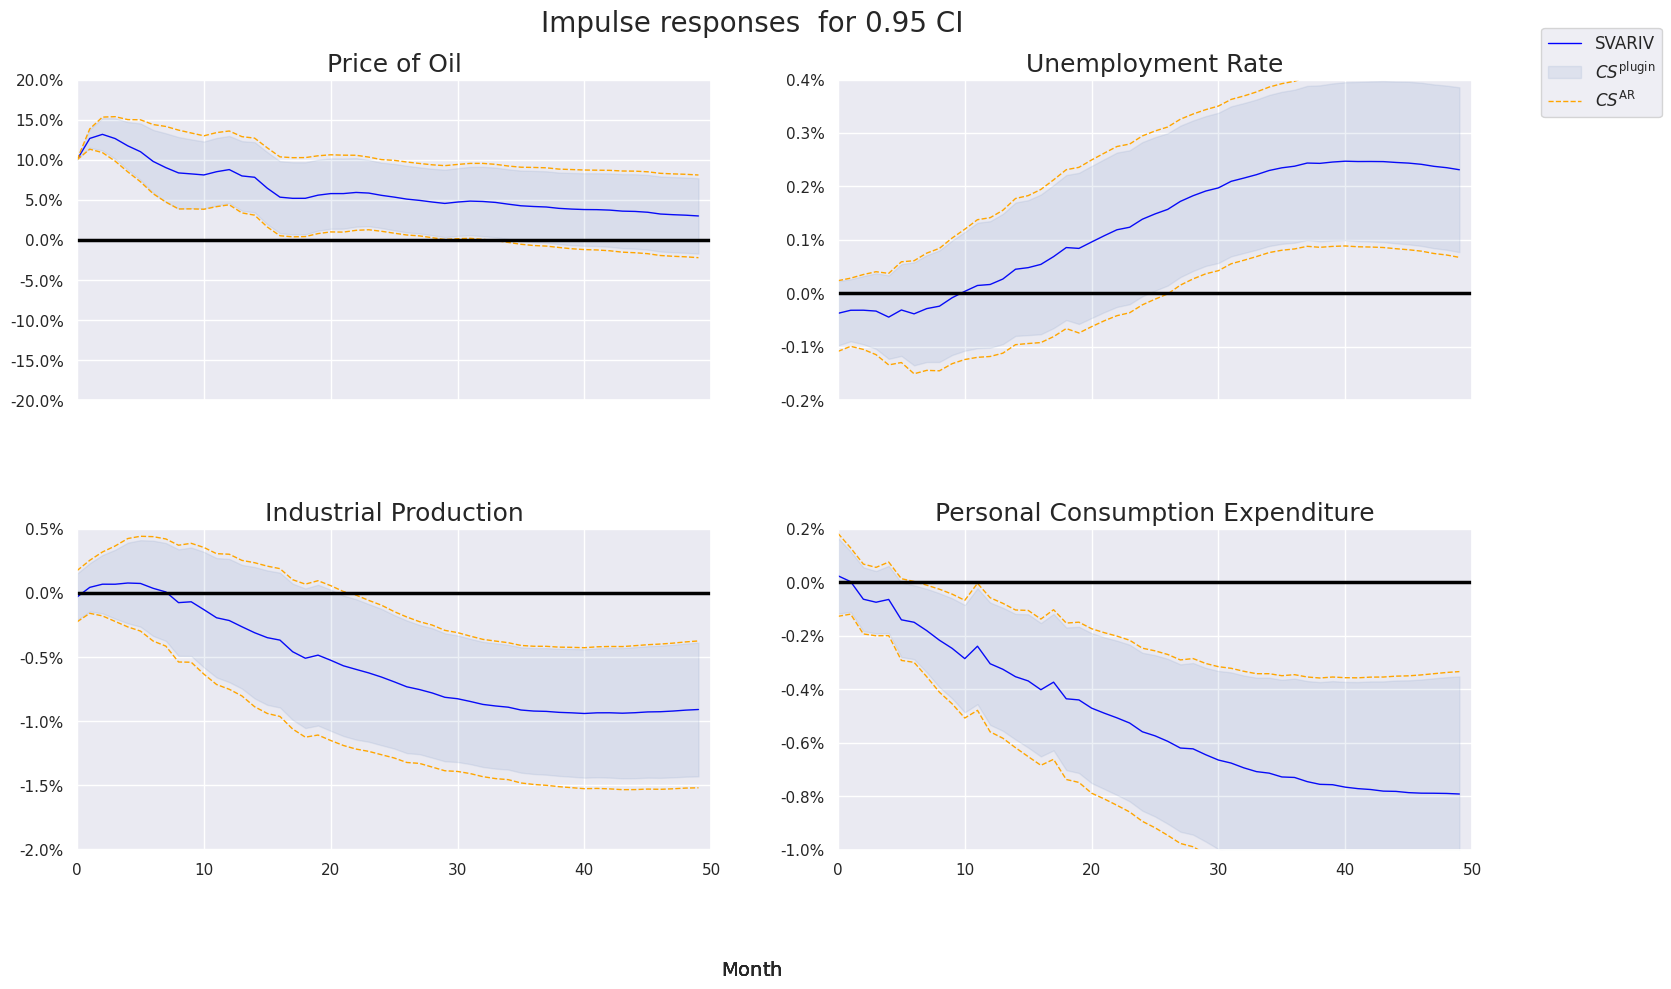

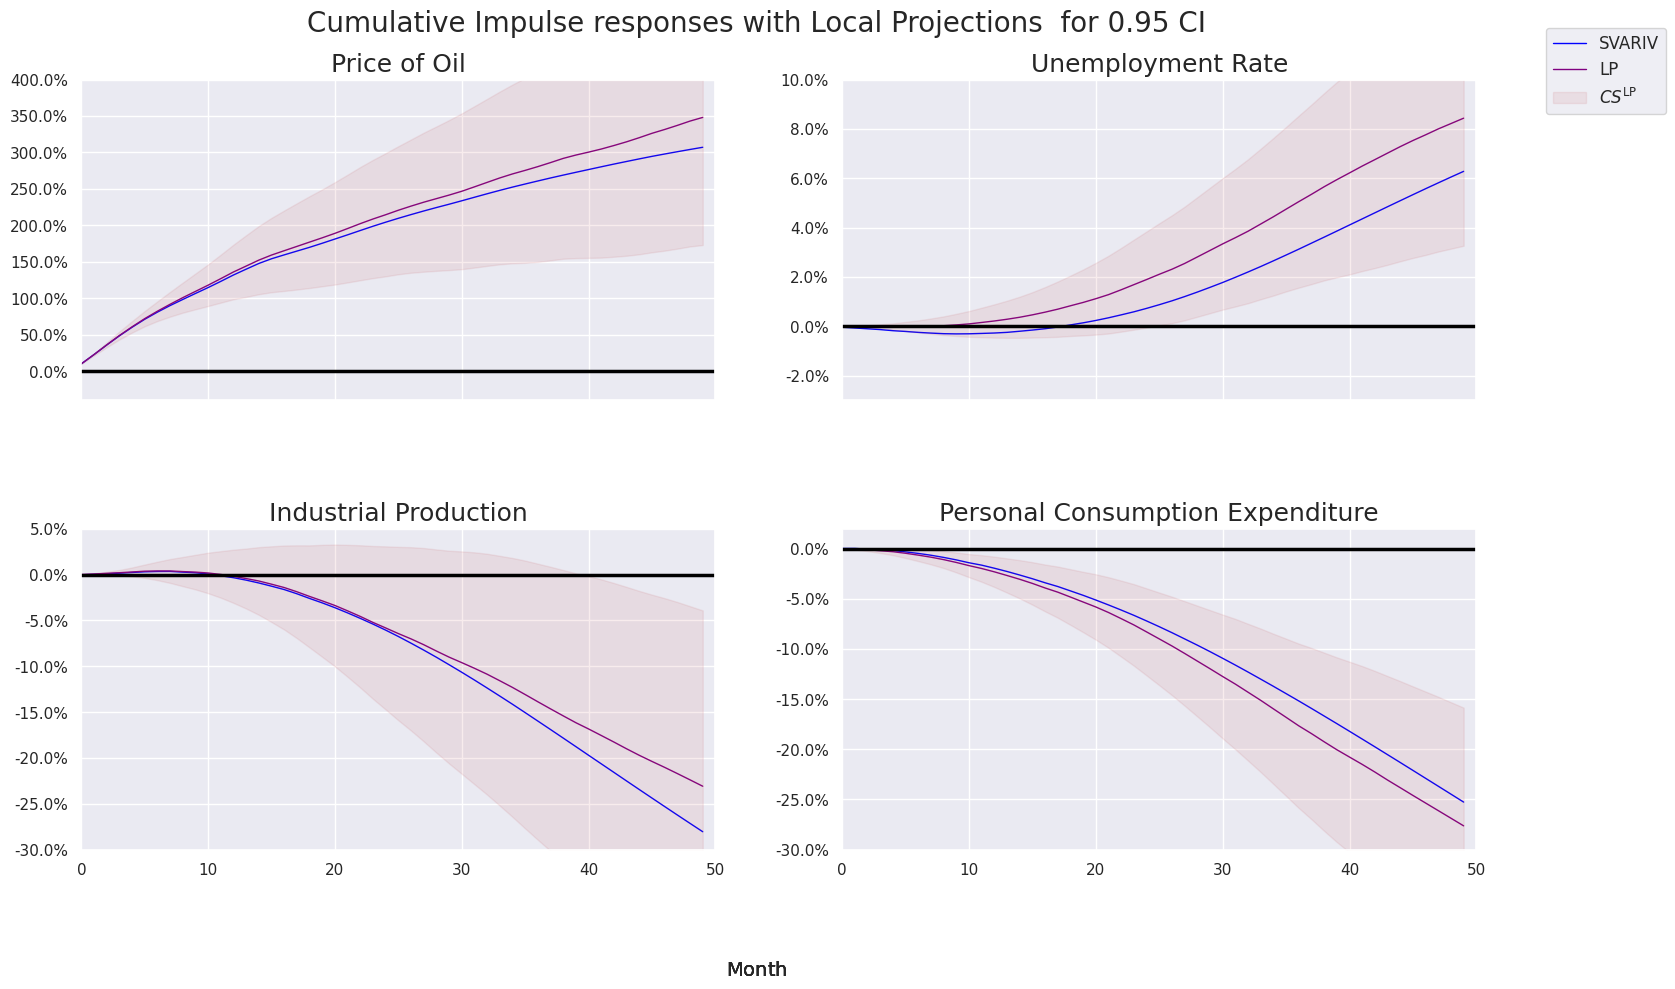

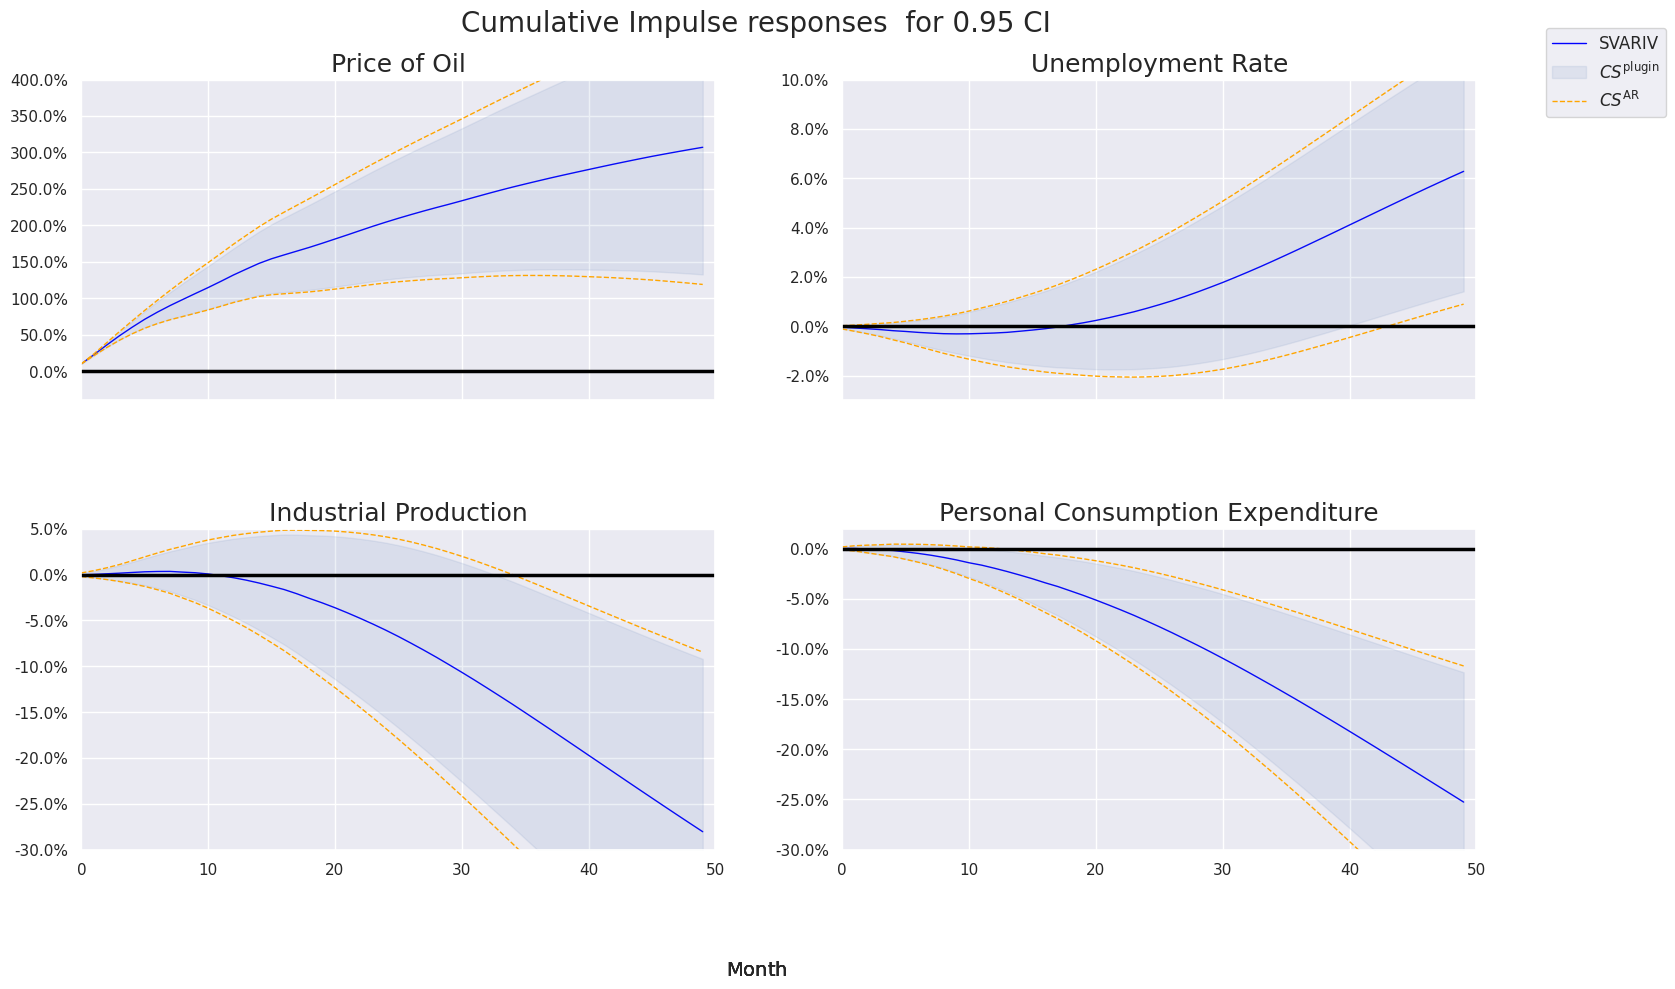

In [23]:
n=4
rot = 0
hori = 50
h=hori
p=20
legend = None

All1 = dataR1.copy()
# Define the desired order of columns
desired_order = ['POIL','UNRATE','INDPRO','PCE']
All1 = All1[desired_order]

# Prepare lagged input matrix X for SVAR model
X = (All1.iloc[:, 0:n])
X.columns = range(X.columns.size)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Extracting variables for SVAR analysis
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = pd.DataFrame(All1.iloc[:, 0:n]).values[p:, :]

# Estimate OLS residuals and perform SVAR analysis
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']

# Set up SVAR parameters
nvar = 1
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

# Extract parameters for impulse response functions
betas = ols_est['betas_hat'].T
betas_lag = betas[:, 1:]
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

# Compute impulse response functions for SVAR and Cholesky
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h)

# Fit VAR model for comparison
model = VAR(All1.dropna())
results = model.fit(24)
VAR1 = ((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1)

# Compute moving average representation matrices
C = SVARIV.MA_representation(betas_lag, p, hori=h)
Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
T = len(Y)

# Set up plotting parameters
xticks = list(range(len(irf_gamma_cum)))

# Confidence Intervals and Cumulative options
conf_intervals = [0.68, 0.95]
Lp1 = [True, False]

cumulative_options = [False, True]

# Titles for each subplot
titles = map_column_names_to_labels(desired_order)

# Loop over confidence intervals and cumulative options
for ci_idx, ci in enumerate(conf_intervals):
    
    CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1)
    CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1)
    

    lpmdl = LP.LP(All1.reset_index(drop=True),maxlags=p,ci=ci)
    out, _ = lpmdl.estimate(hori,shock_size =0.1)
    # Select rows where impulse is 'POIL'
    poil_df = out.loc['POIL']

    # Reset the index to create a one-index DataFrame
    poil_df_reset = poil_df.reset_index()
    coef = pd.DataFrame()
    lb = pd.DataFrame()
    ub = pd.DataFrame()

    for colmn in All1.columns:
        coef[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['coef'].values[:-1]
        lb[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['lb'].values[:-1]
        ub[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['ub'].values[:-1]

    coef_cum=np.cumsum(coef)
    lb_cum=np.cumsum(lb)
    ub_cum=np.cumsum(ub)
    
    # Create a new figure for each combination
    for cum_idx, cum_opt in enumerate(cumulative_options):
        for lp_opt in (Lp1):
            
            fig, axs = plt.subplots(split_into_close_integers(len(All1.columns))[0]\
                                    ,split_into_close_integers(len(All1.columns))[1],\
                                    figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
            axs_flat = axs.flatten()
        
            for i, ax in enumerate(axs_flat):
                title = titles[i]
                col = All1.columns[i]

                if i >= len(titles):
                    fig.delaxes(ax)  
                    continue

                # Set y-axis limits based on the column and cumulative option

                if cum_opt:
                    if col == 'POIL':
                        ylim1 = 4
                        ylim0 = -0.4
                    elif col == 'UNRATE':
                        ylim1 = 0.1
                        ylim0 = -0.03
                    elif col == 'INDPRO':
                        ylim1 = 0.05
                        ylim0 = -0.3
                    elif col == 'PCE':
                        ylim1 = 0.02
                        ylim0 = -0.3
                else:
                    if col == 'POIL':
                        ylim1 = 0.2
                        ylim0 = -0.2
                    elif col == 'UNRATE':
                        ylim1 = 0.004
                        ylim0 = -0.002
                    elif col == 'INDPRO':
                        ylim1 = 0.005
                        ylim0 = -0.02
                    elif col == 'PCE':
                        ylim1 = 0.002
                        ylim0 = -0.01

                # Select the appropriate impulse response functions and confidence intervals
                if cum_opt:
                    plugin_cs = np.array([irf_gamma_cum[:, i] + SVARIV.norm_critval(confidence=ci)\
                                          * CI_s_cum['pluginirfstderror'][i, :],
                                          irf_gamma_cum[:, i] - SVARIV.norm_critval(confidence=ci)\
                                          * CI_s_cum['pluginirfstderror'][i, :]]).T
                else:
                    plugin_cs = np.array([irf_gamma[:, i] + SVARIV.norm_critval(confidence=ci)\
                                          * CI_s['pluginirfstderror'][i, :],
                                          irf_gamma[:, i] - SVARIV.norm_critval(confidence=ci)\
                                          * CI_s['pluginirfstderror'][i, :]]).T

                low_plugin = plugin_cs[:, 0]
                upp_plugin = plugin_cs[:, 1]



                # Calculate VAR impulse response for comparison
               
                if lp_opt:
                    # Plotting
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1,\
                        
                            label='SVARIV')
                    ax.plot(coef_cum.values[:, i] if cum_opt else coef.values[:, i], color='purple', zorder=1, linewidth=1,\
                            label='LP')
                    ax.fill_between(xticks, lb_cum.values[:, i]  if cum_opt else lb.values[:, i] , ub_cum.values[:, i] \
                                    if cum_opt else ub.values[:, i], color='r', alpha=.1, label=r'$CS^{\mathrm{LP}}$')

                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                else: 
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, \
                            label='SVARIV')
                    ax.fill_between(xticks, low_plugin, upp_plugin, color='b', alpha=.1, label=r'$CS^{\mathrm{plugin}}$')
                    ax.plot(CI_cum['l'][i, :] if cum_opt else CI['l'][i, :], '--', zorder=1, linewidth=1, color='orange',\
                            label=r'$CS^{\mathrm{AR}}$')
                    ax.plot(CI_cum['u'][i, :] if cum_opt else CI['u'][i, :], '--', zorder=1, linewidth=1, color='orange')                 
                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)

                # Add 'Cumulative' to suptitle only for cumulative options
                suptitle_str1 = 'Cumulative ' if cum_opt else '' 
                suptitle_str2= 'with Local Projections ' if lp_opt else ''
                fig.suptitle(suptitle_str1 + 'Impulse responses ' +suptitle_str2+ ' for ' +str(ci) + ' CI', fontsize=20, y=0.95)

            # Place the legend outside of the subplots
            handles, labels = axs_flat[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 0.94), fontsize=12)

            # Save the figure with a unique name based on CI and cumulative options
            saved = f'./Kanzig/IRF_pdfs/IRF_Figure2_{ci}_Cumulative_{cum_opt}_LP_{lp_opt}.pdf'
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            plt.savefig(saved, bbox_inches='tight')
            plt.show()
plt.close("all")



In [24]:
dataR2 = np.log(dataR[['CPILFESL','CPIENGSL','CUSR0000SAN','CUSR0000SAD','CUSR0000SAS']].copy())*100
dataR2['POIL']=All1['POIL']
dataR2['CPILFESL'] = np.log(All['CPI'])*100
dataR2.columns= ['HEADLINE','ENERGY','NONDURABLES','DURABLES','SERVICES','POIL']

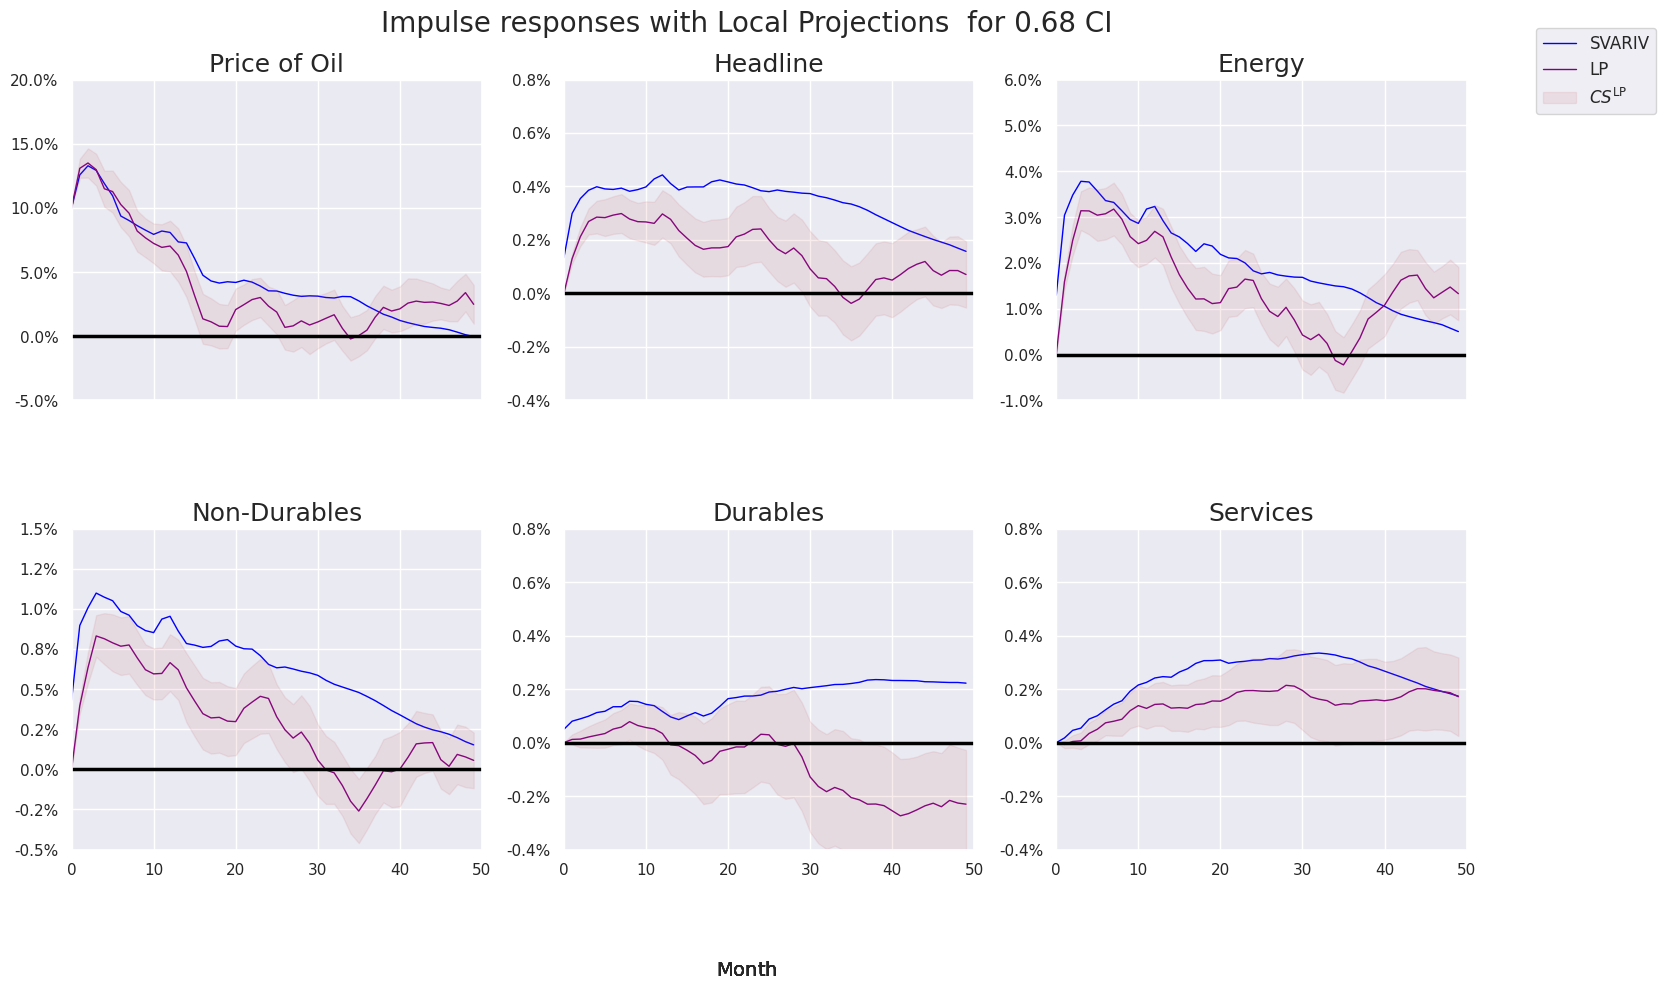

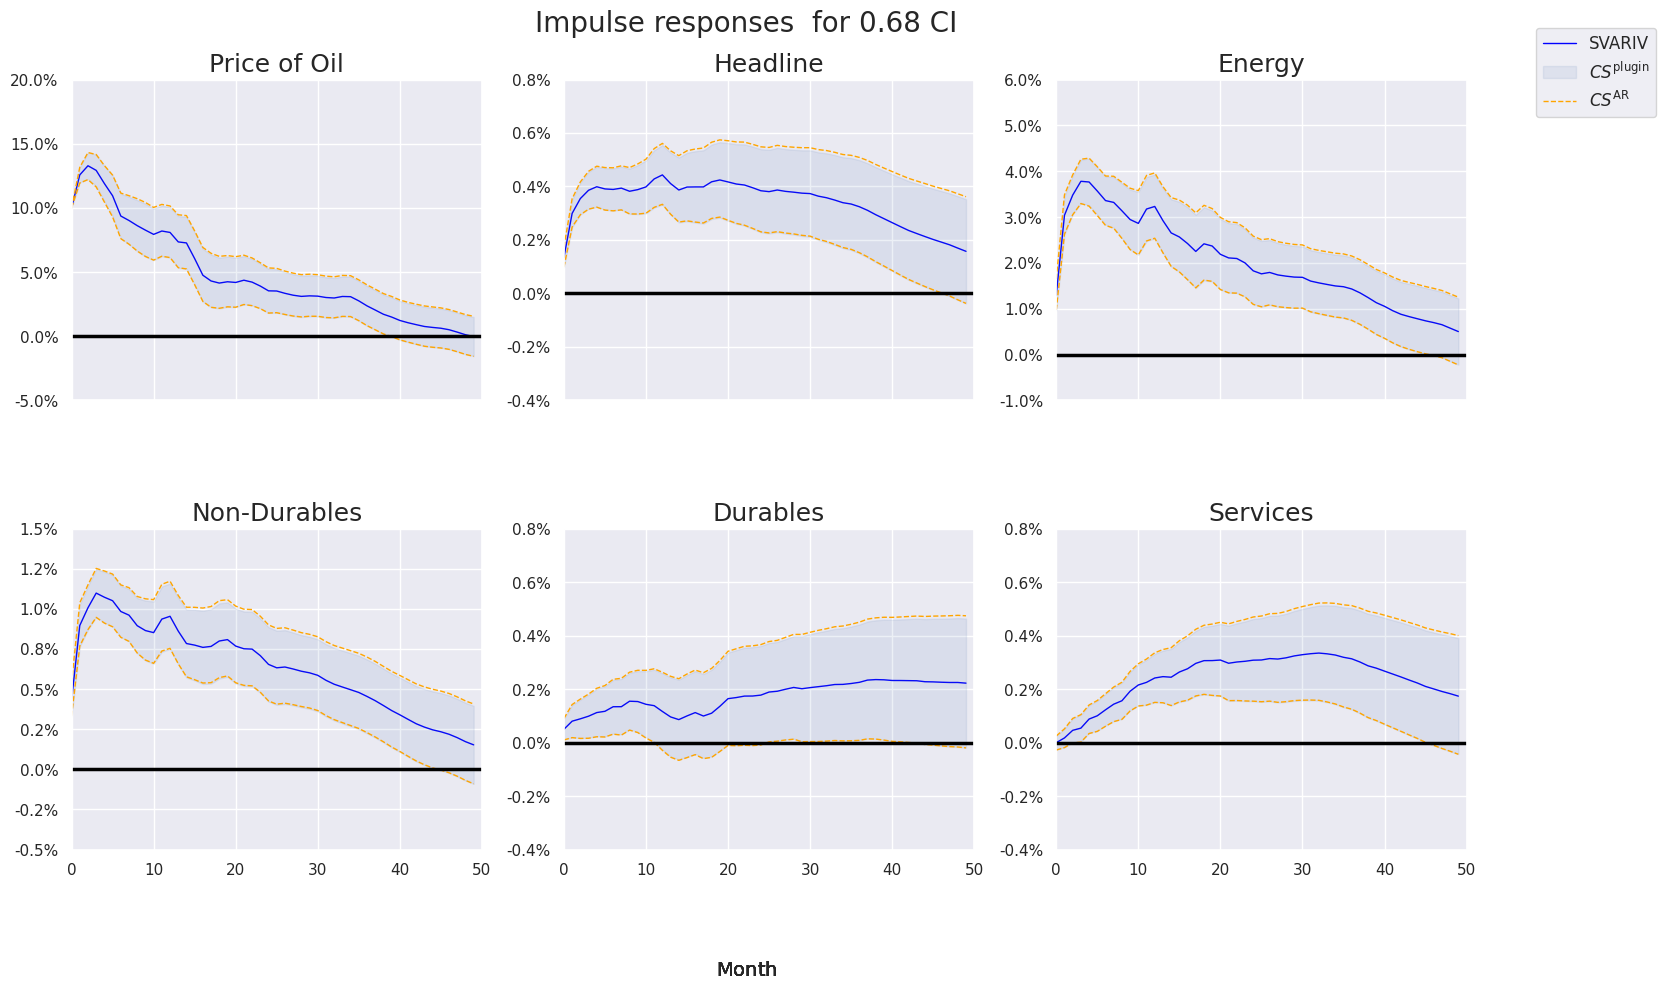

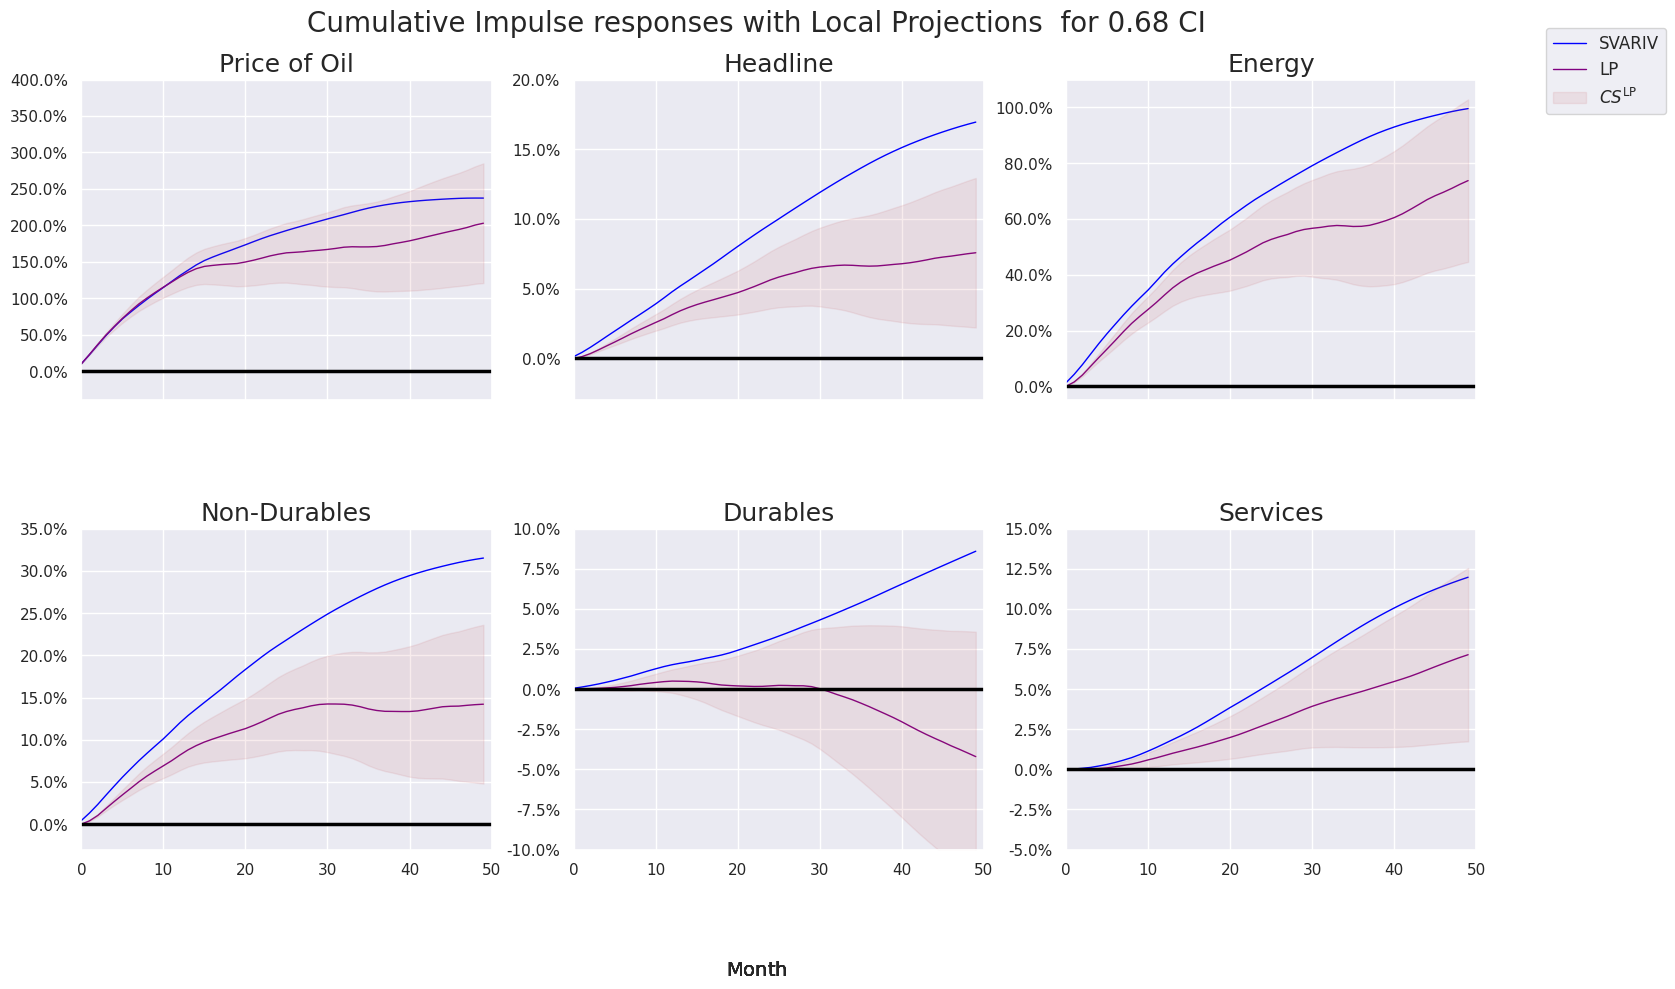

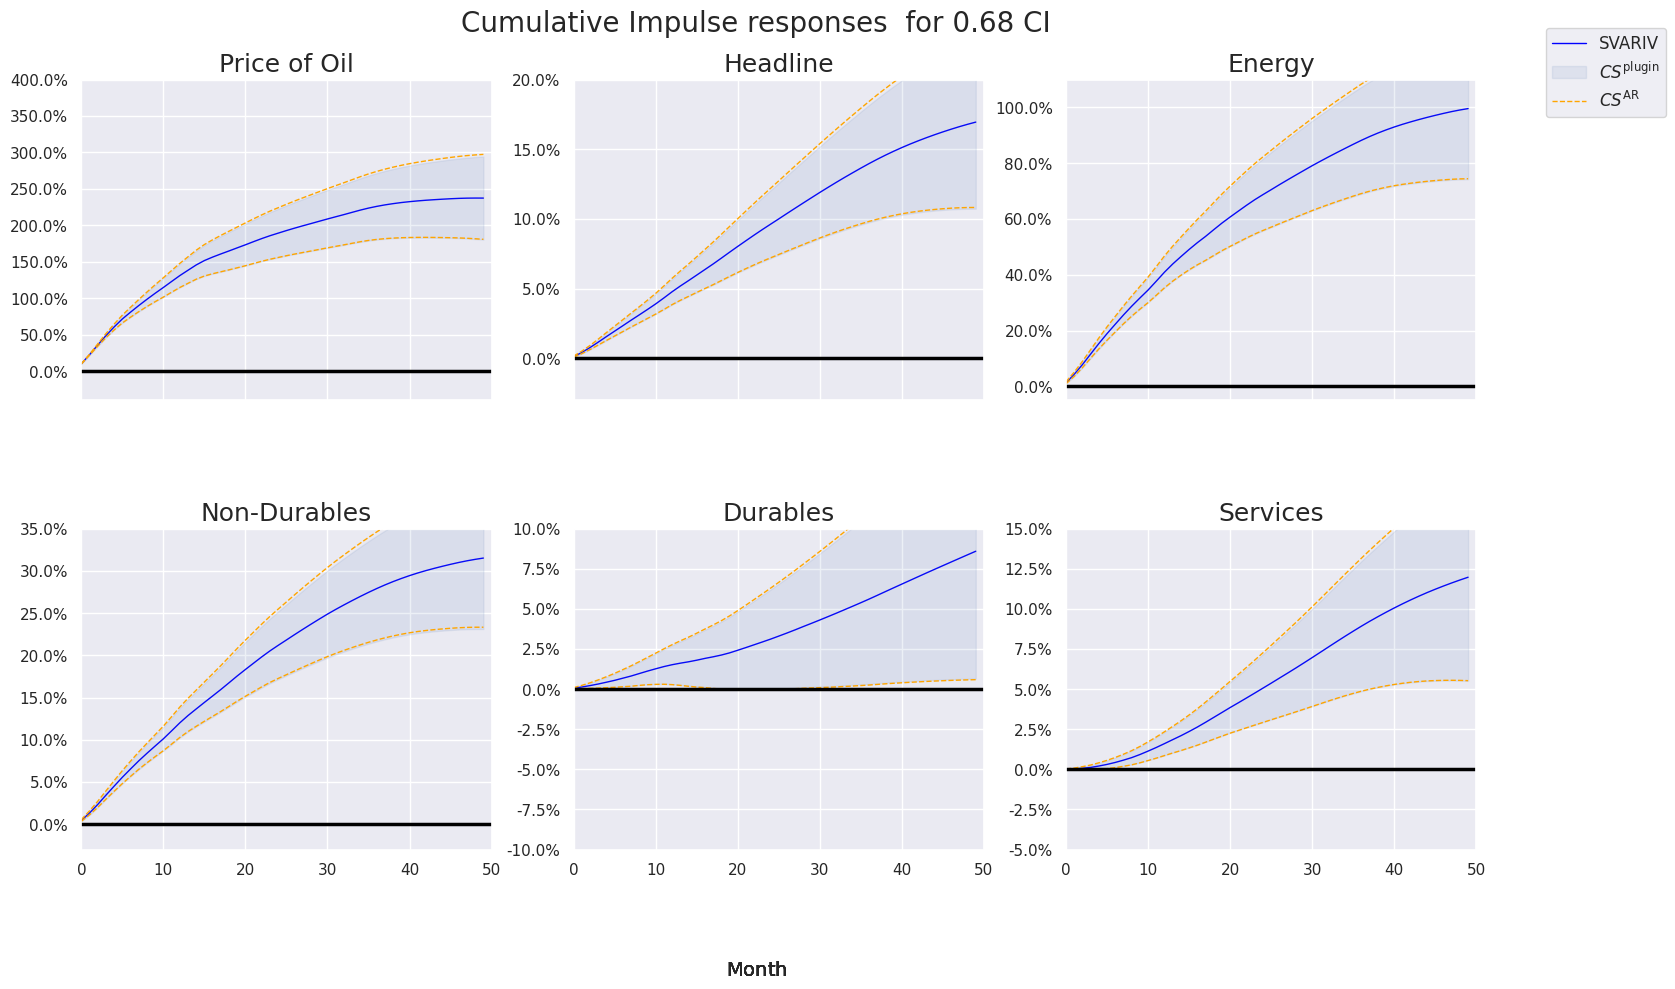

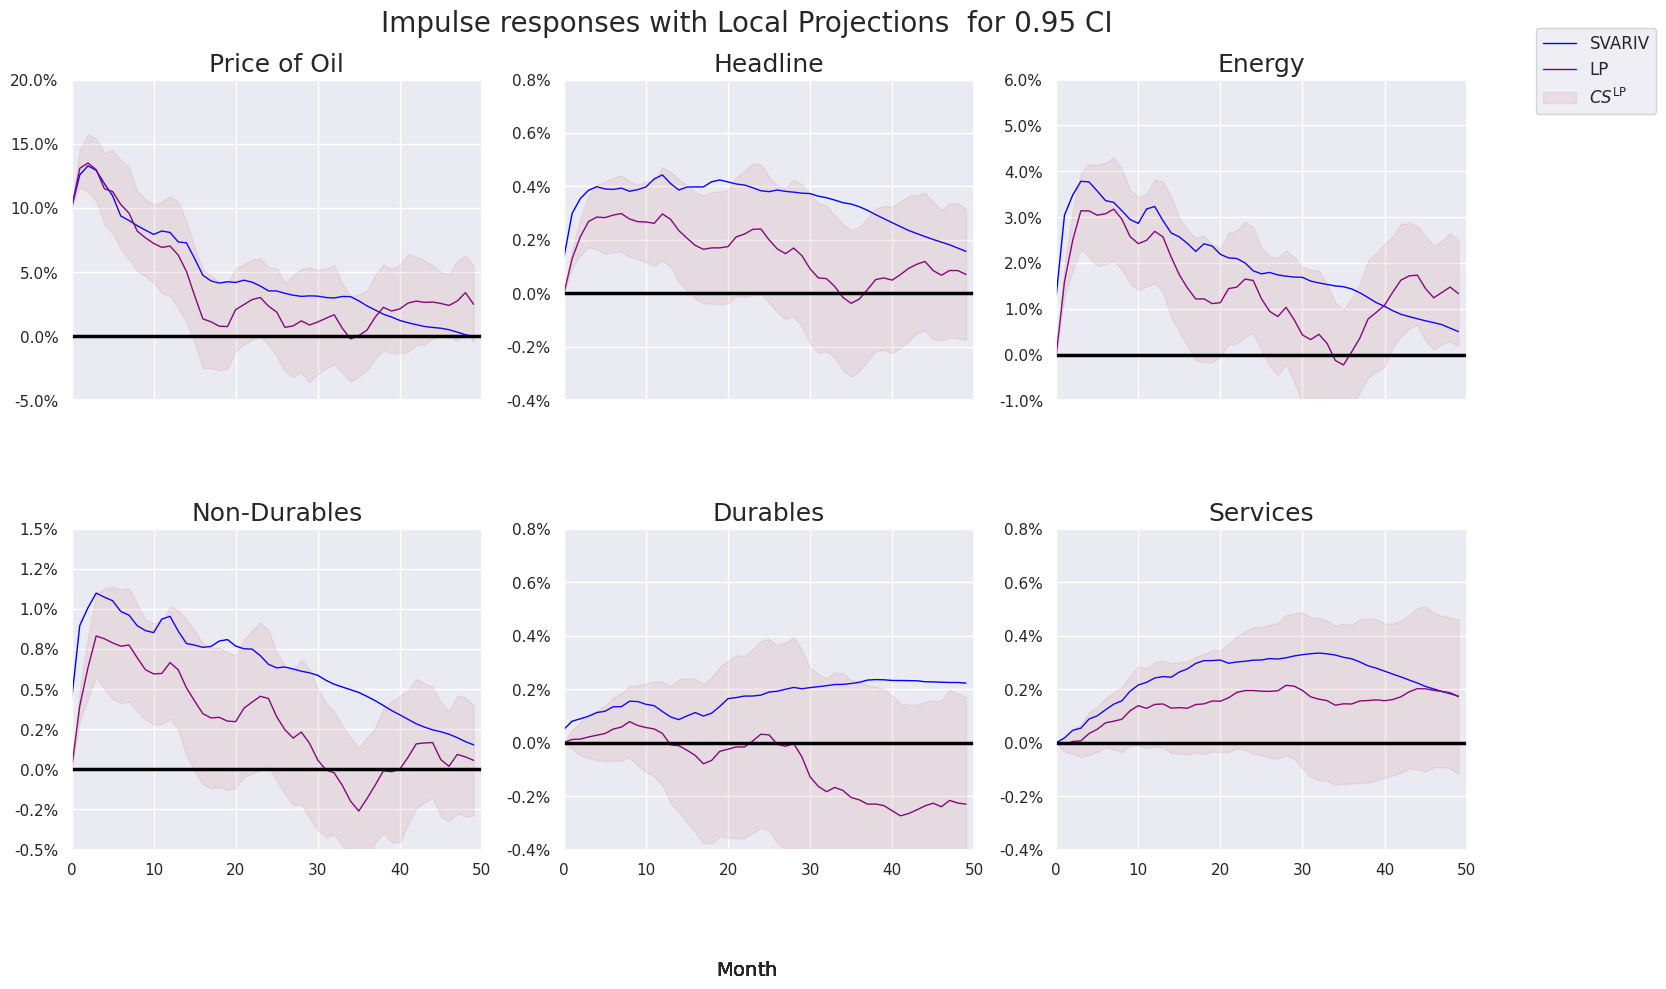

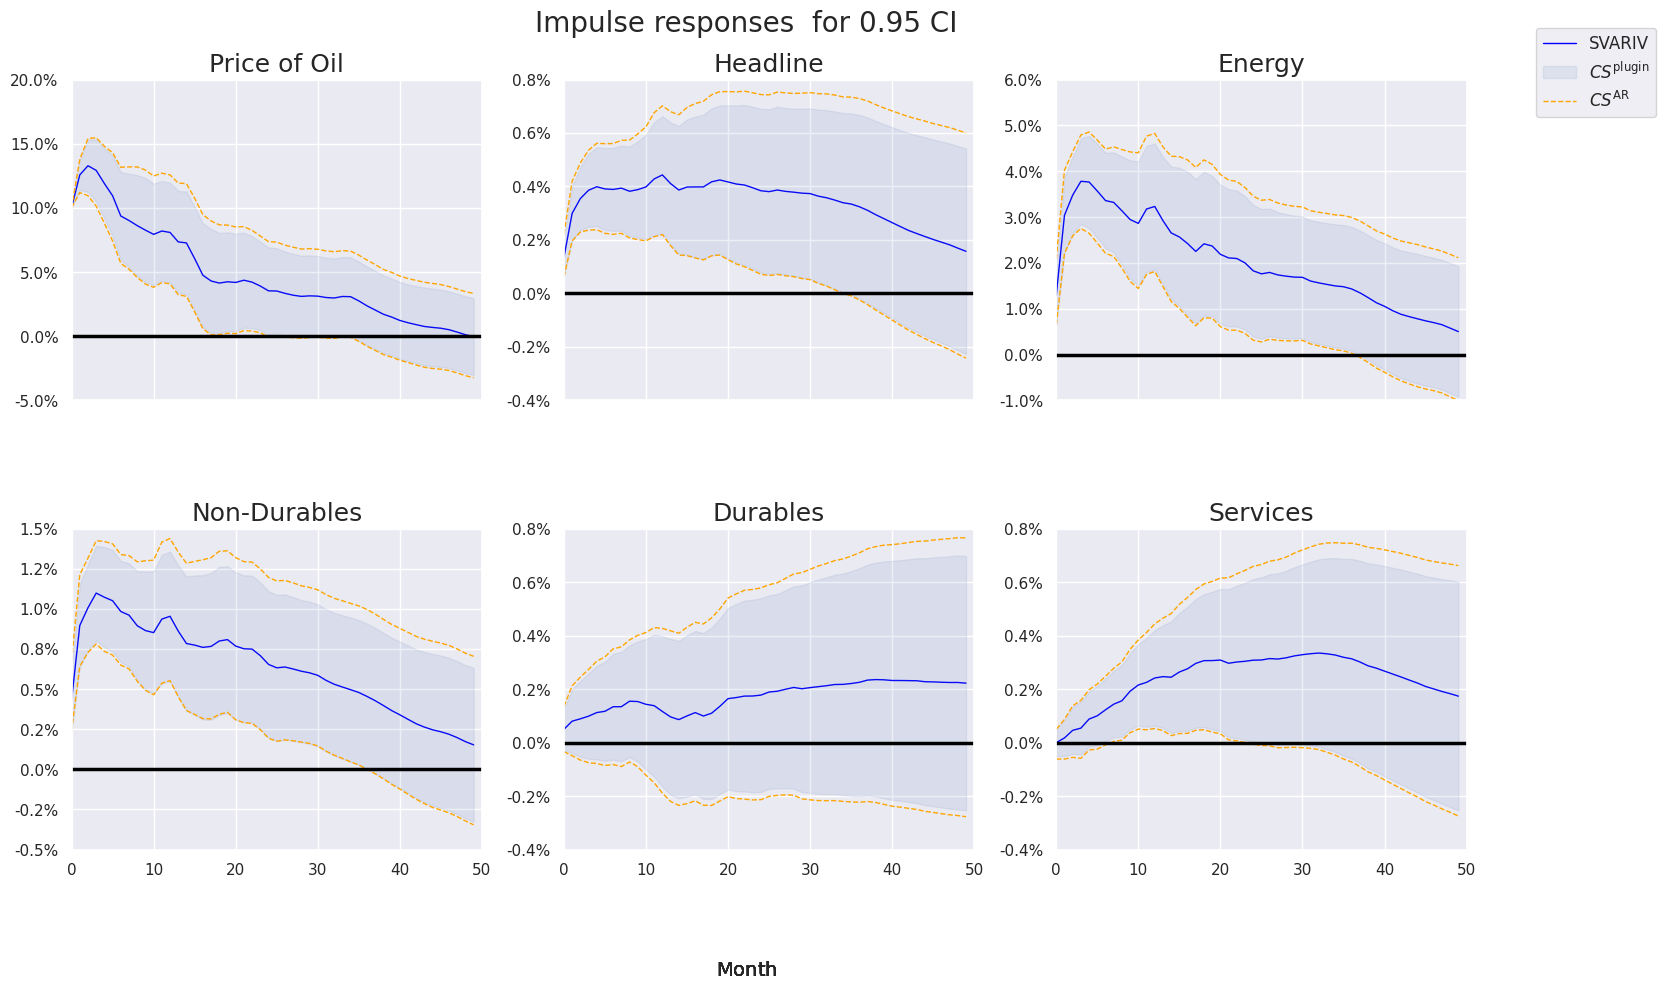

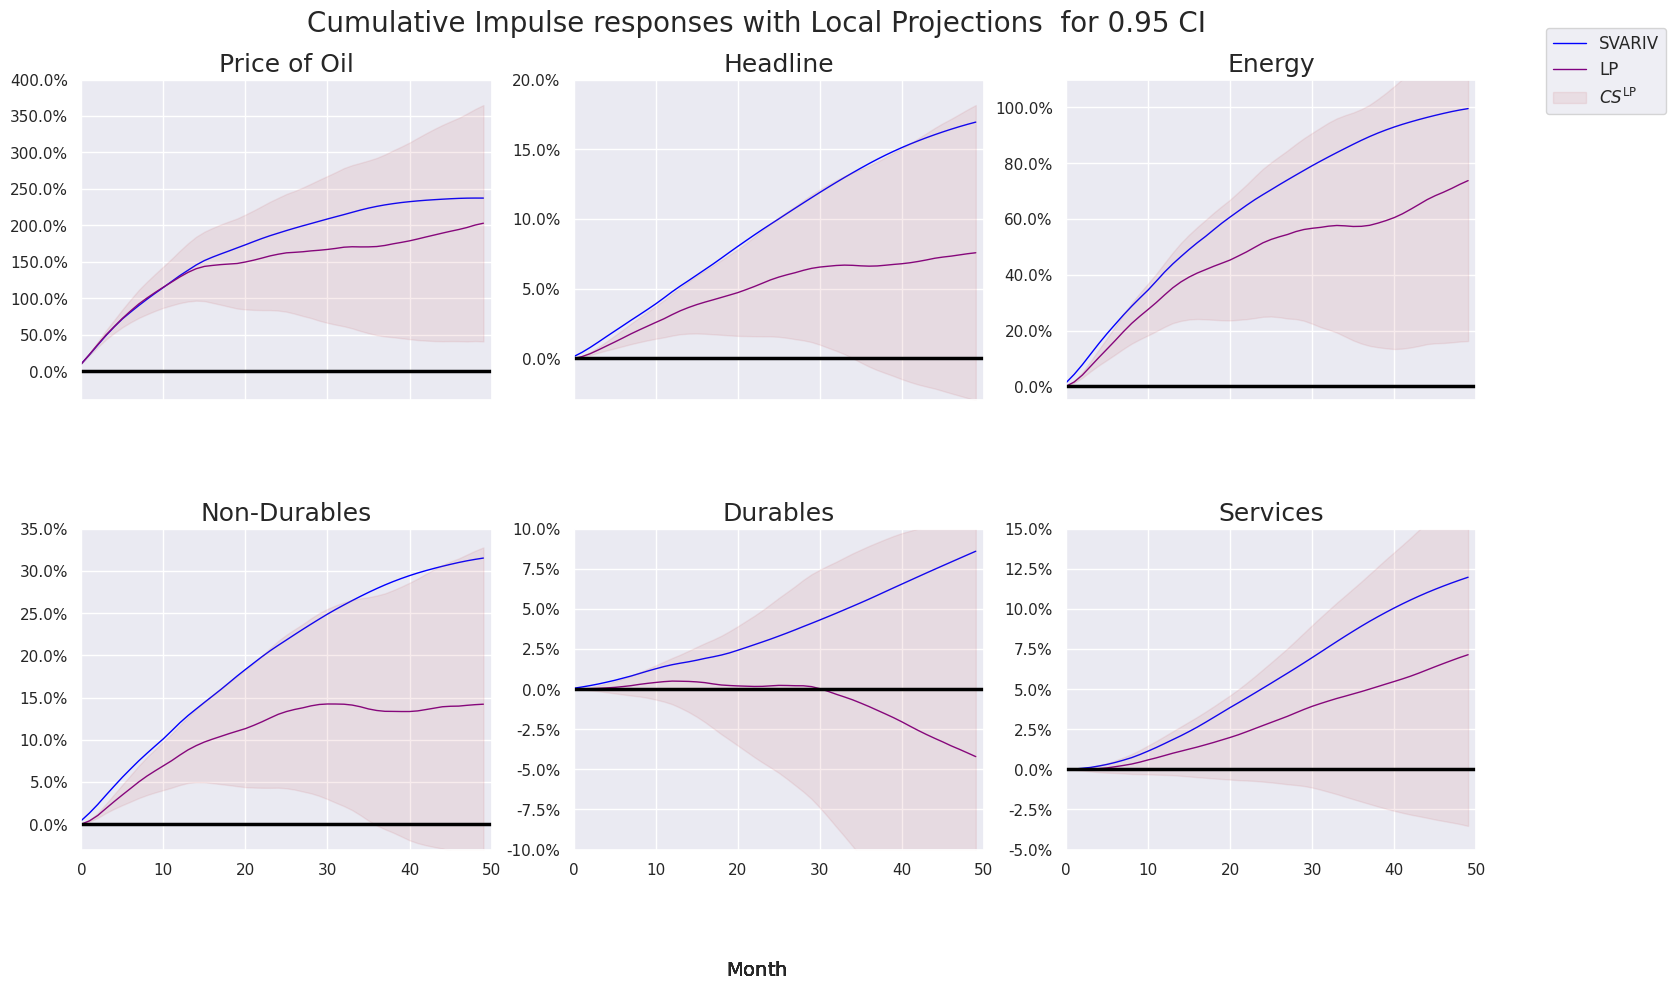

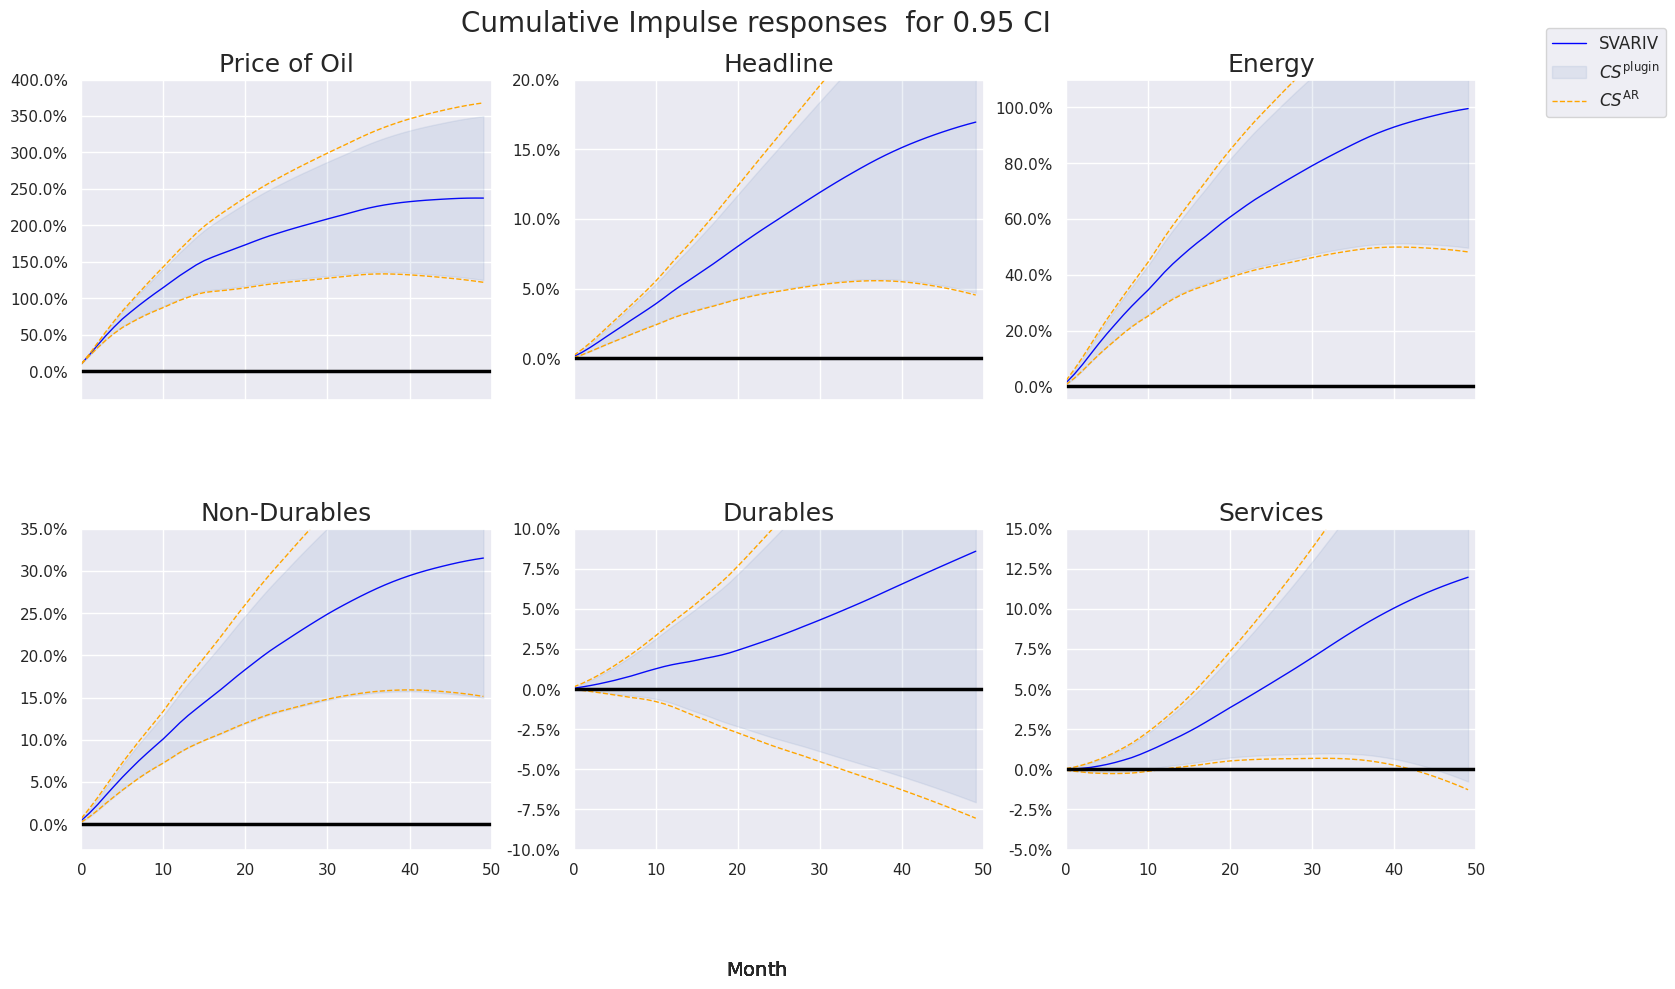

In [25]:
n=6
rot = 0
hori = 50
h=hori
p=20
legend = None

All1 = dataR2.copy()
# Define the desired order of columns
desired_order = ['POIL','HEADLINE','ENERGY','NONDURABLES','DURABLES','SERVICES']
All1 = All1[desired_order]

# Prepare lagged input matrix X for SVAR model
X = (All1.iloc[:, 0:n])
X.columns = range(X.columns.size)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
X = X[p:, :]
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

# Extracting variables for SVAR analysis
BB = pd.DataFrame(All.iloc[:, 18])
Z = BB.values[p:, :]
Y = pd.DataFrame(All1.iloc[:, 0:n]).values[p:, :]

# Estimate OLS residuals and perform SVAR analysis
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']

# Set up SVAR parameters
nvar = 1
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

# Extract parameters for impulse response functions
betas = ols_est['betas_hat'].T
betas_lag = betas[:, 1:]
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

# Compute impulse response functions for SVAR and Cholesky
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h)

# Fit VAR model for comparison
model = VAR(All1.dropna())
results = model.fit(24)
VAR1 = ((pd.DataFrame(results.irf(50).irfs.T[0])) * 0.1)

# Compute moving average representation matrices
C = SVARIV.MA_representation(betas_lag, p, hori=h)
Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
T = len(Y)

# Set up plotting parameters
xticks = list(range(len(irf_gamma_cum)))

# Confidence Intervals and Cumulative options
conf_intervals = [0.68, 0.95]
Lp1 = [True, False]

cumulative_options = [False, True]

# Titles for each subplot
titles = map_column_names_to_labels(desired_order)

# Loop over confidence intervals and cumulative options
for ci_idx, ci in enumerate(conf_intervals):
    
    CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1, nvar=1)
    CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1)
    CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1)
    

    lpmdl = LP.LP(All1.reset_index(drop=True),maxlags=p,ci=ci)
    out, _ = lpmdl.estimate(hori,shock_size =0.1)
    # Select rows where impulse is 'POIL'
    poil_df = out.loc['POIL']

    # Reset the index to create a one-index DataFrame
    poil_df_reset = poil_df.reset_index()
    coef = pd.DataFrame()
    lb = pd.DataFrame()
    ub = pd.DataFrame()

    for colmn in All1.columns:
        coef[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['coef'].values[:-1]
        lb[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['lb'].values[:-1]
        ub[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['ub'].values[:-1]

    coef_cum=np.cumsum(coef)
    lb_cum=np.cumsum(lb)
    ub_cum=np.cumsum(ub)
    
    # Create a new figure for each combination
    for cum_idx, cum_opt in enumerate(cumulative_options):
        for lp_opt in (Lp1):
            
            fig, axs = plt.subplots(split_into_close_integers(len(All1.columns))[0]\
                                    ,split_into_close_integers(len(All1.columns))[1],\
                                    figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
            axs_flat = axs.flatten()
        
            for i, ax in enumerate(axs_flat):
                title = titles[i]
                col = All1.columns[i]

                if i >= len(titles):
                    fig.delaxes(ax)  
                    continue

                # Set y-axis limits based on the column and cumulative option

                if cum_opt:
                    if col == 'POIL':
                        ylim1 = 4
                        ylim0 = -0.4
                    elif col == 'HEADLINE':
                        ylim1 = 0.2
                        ylim0 = -0.03
                    elif col == 'ENERGY':
                        ylim1 = 1.1
                        ylim0 = -0.05
                    elif col == 'NONDURABLES':
                        ylim1 = 0.35
                        ylim0 = -0.03
                    elif col == 'DURABLES':
                        ylim1 = 0.1
                        ylim0 = -0.1
                    elif col == 'SERVICES':
                        ylim1 = 0.15
                        ylim0 = -0.05
                else:
                    if col == 'POIL':
                        ylim1 = 0.2
                        ylim0 = -0.05
                    elif col == 'HEADLINE':
                        ylim1 = 0.008
                        ylim0 = -0.004
                    elif col == 'ENERGY':
                        ylim1 = 0.06
                        ylim0 = -0.01
                    elif col == 'NONDURABLES':
                        ylim1 = 0.015
                        ylim0 = -0.005
                    elif col == 'DURABLES':
                        ylim1 = 0.008
                        ylim0 = -0.004
                    elif col == 'SERVICES':
                        ylim1 = 0.008
                        ylim0 = -0.004

                # Select the appropriate impulse response functions and confidence intervals
                if cum_opt:
                    plugin_cs = np.array([irf_gamma_cum[:, i] + SVARIV.norm_critval(confidence=ci)\
                                          * CI_s_cum['pluginirfstderror'][i, :],
                                          irf_gamma_cum[:, i] - SVARIV.norm_critval(confidence=ci)\
                                          * CI_s_cum['pluginirfstderror'][i, :]]).T
                else:
                    plugin_cs = np.array([irf_gamma[:, i] + SVARIV.norm_critval(confidence=ci)\
                                          * CI_s['pluginirfstderror'][i, :],
                                          irf_gamma[:, i] - SVARIV.norm_critval(confidence=ci)\
                                          * CI_s['pluginirfstderror'][i, :]]).T

                low_plugin = plugin_cs[:, 0]
                upp_plugin = plugin_cs[:, 1]



               
                if lp_opt:
                    # Plotting
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1,\
                            label='SVARIV')
                    ax.plot(coef_cum.values[:, i] if cum_opt else coef.values[:, i], color='purple', zorder=1, linewidth=1,\
                            label='LP')
                    ax.fill_between(xticks, lb_cum.values[:, i]  if cum_opt else lb.values[:, i] , ub_cum.values[:, i] \
                                    if cum_opt else ub.values[:, i], color='r', alpha=.1, label=r'$CS^{\mathrm{LP}}$')

                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                else: 
                    ax.set_title(f'{title}', fontsize=18)
                    ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, \
                            label='SVARIV')
                    ax.fill_between(xticks, low_plugin, upp_plugin, color='b', alpha=.1, label=r'$CS^{\mathrm{plugin}}$')
                    ax.plot(CI_cum['l'][i, :] if cum_opt else CI['l'][i, :], '--', zorder=1, linewidth=1, color='orange',\
                            label=r'$CS^{\mathrm{AR}}$')
                    ax.plot(CI_cum['u'][i, :] if cum_opt else CI['u'][i, :], '--', zorder=1, linewidth=1, color='orange')                 
                    ax.grid(True)
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                    ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                    ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                    ax.set_ylim(ylim0, ylim1)
                    ax.set_xlim(0, hori)
                    ax.set_xlabel("", fontsize=10)
                    ax.set_ylabel("", fontsize=10)
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)

                # Add 'Cumulative' to suptitle only for cumulative options
                suptitle_str1 = 'Cumulative ' if cum_opt else '' 
                suptitle_str2= 'with Local Projections ' if lp_opt else ''
                fig.suptitle(suptitle_str1 + 'Impulse responses ' +suptitle_str2+ ' for ' +str(ci) + ' CI', fontsize=20, y=0.95)


            # Place the legend outside of the subplots
            handles, labels = axs_flat[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 0.94), fontsize=12)

            # Save the figure with a unique name based on CI and cumulative options
            saved = f'./Kanzig/IRF_pdfs/IRF_Figure3_{ci}_Cumulative_{cum_opt}_LP_{lp_opt}.pdf'
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            plt.savefig(saved, bbox_inches='tight')
            plt.show()
plt.close("all")



# Data Shousha

In [12]:
ExchangeM = pd.read_excel('./Main_Data/broad.xlsx', sheet_name="Real", index_col=0, na_values=0)
ExchangeM.index = pd.to_datetime(ExchangeM.index)
# Aggregate quarterly by mean
ExchangeQ = ExchangeM.resample('Q').mean()

In [13]:
# Load CPI data from Excel file
CPI = pd.read_excel('./Main_Data/cp2401.xlsx', sheet_name="Monthly Series")

# Define lists of countries for Emerging and Advanced Economies
emerging_countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Peru', 'South Africa']
advanced_countries = ['Australia', 'Canada', 'New Zealand', 'Norway', 'United States']

# Extract the relevant columns for Emerging and Advanced Economies
selected_columns = ['Unnamed: 0'] + [f'{country} - Index, 2010 = 100' for country in emerging_countries + advanced_countries]

# Extract the relevant rows
filtered_CPI = CPI[selected_columns]

# Set the index using the values from the 'Unnamed: 0' column
CPI_M = filtered_CPI.drop([0, 2], axis=0).set_index('Unnamed: 0')

# Convert the index to datetime format
CPI_M.index = pd.to_datetime(CPI_M.index)

# Assuming there's a typo in the next line
CPI_M.columns = CPI_M.iloc[0].values

# Drop rows with 'NaT' in the 'Unnamed: 0' column (assuming it should be CPI_M instead of CPI_Q)
CPIQ = CPI_M.drop('NaT', axis=0)

# Resample the data to quarterly frequency and calculate the mean
CPIQ = CPIQ.resample('Q').mean()
CPIQ.index= CPIQ.index.strftime('%Y-%m-01')
CPIQ.index=pd.to_datetime(CPIQ.index)

In [14]:
# Load Credit data from Excel file
Credit = pd.read_excel('./Main_Data/TotalCredit.xlsx', sheet_name="Quarterly Series")

# Define lists of countries for Emerging and Advanced Economies
emerging_countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'South Africa']
advanced_countries = ['Australia', 'Canada', 'New Zealand', 'Norway', 'United States']

# Extract the relevant columns for Emerging and Advanced Economies
selected_columns = ['Back to menu'] + [f'{country} - Credit to Non-financial corporations from All sectors at Market value - Domestic currency - Unadjusted' for country in emerging_countries + advanced_countries]

# Extract the relevant rows
Credit_Q = Credit[selected_columns].drop([0, 2], axis=0).set_index('Back to menu')

# Convert the index to datetime format
Credit_Q.index = pd.to_datetime(Credit_Q.index)

# Assuming there's a typo in the next line
Credit_Q.columns = Credit_Q.iloc[0].values

# Drop rows with 'NaT' in the 'Back to menu' column 
CreditQ = Credit_Q.drop('NaT', axis=0)

In [15]:
# Align the DataFrames on both columns and index
aligned_CPIQ, aligned_CreditQ = CPIQ.dropna().align(CreditQ.dropna(), axis=0, join='outer')
aligned_CPIQ, aligned_CreditQ = aligned_CPIQ.dropna().align(aligned_CreditQ.dropna(), axis=1, join='outer')

# Replace NaN values with a placeholder (e.g., 1.0)
aligned_CPIQ = aligned_CPIQ.fillna(0)
aligned_CreditQ = aligned_CreditQ.fillna(0)
aligned_CreditQ = aligned_CreditQ.to_period('Q').to_timestamp('D')
aligned_CPIQ =  aligned_CPIQ.to_period('Q').to_timestamp('D')
# Perform division
RCreditQ = aligned_CreditQ/aligned_CPIQ

# Replace infinite values resulting from division by zero with NaN
RCreditQ.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the resulting DataFrame
RCreditQ.drop('Peru',inplace=True,axis=1)


In [16]:
TBILLS= pd.read_csv('./Main_Data/TBILLS.csv')
TBILLS.set_index('DATE',inplace=True)
TBILLS.index= pd.to_datetime(TBILLS.index)
TBILLS.columns=['Val']
EMBI= pd.read_csv('./Main_Data/EMBI.csv')
EMBI.set_index('Fecha',inplace=True)
EMBI= EMBI.dropna(axis=1)
EMBI.columns = ['LATINO', 'REP_DOM', 'Brazil', 'Colombia', 'Ecuador',
       'Argentina', 'Mexico', 'Peru', 'Panama', 'Venezuela', 'Uruguay',
       'RD_LATINO']
EMBI.index= pd.to_datetime(EMBI.index)

EXPINF= pd.read_excel('./Main_Data/USInflationExpected.xlsx',sheet_name="Expected Inflation")
EXPINF.set_index('Model Output Date',inplace=True) 

# Define weights for each time horizon (1 to 30 years)
weights = [1/i for i in range(1, 31)]

# Apply the weights to each column and calculate the weighted average
weighted_avg = EXPINF.mul(weights, axis=1).sum(axis=1) / sum(weights)
EXPINFW =pd.DataFrame(weighted_avg)
EXPINFW.index= pd.to_datetime(EXPINFW.index)
EXPINFW.columns=['Val']
EMBIM= (FCBC(EMBI.dropna(axis=1),'E').resample('M').mean())
EMBIM.index = EMBIM.index.strftime('%Y-%m-01')
USRATE = (TBILLS-EXPINFW*100).dropna()

# Convert the index to datetime if not already in datetime format
EMBIM.index = pd.to_datetime(EMBIM.index)

# Initialize an empty dataframe for the result
CIR = pd.DataFrame(index=EMBIM.index)

# Iterate over columns in EMBIM and sum with Val
for column in EMBIM.columns:
    CIR[column] = EMBIM[column] + USRATE['Val']




In [17]:
InvestQ =read_and_process_csv('./Main_Data/Investment.csv',freq='Q',subject='P51A' ,measure = 'CQR')

GDPQ = read_and_process_csv('./Main_Data/GDP_NEW.csv',freq='Q',subject='B1_GE',measure='CQR')
GDP_DeflatorQ = read_and_process_csv('./Main_Data/GDP_Deflator.csv',subject='B1_GE',measure='DOBSA')


RGDPQ = (GDPQ*100)/GDP_DeflatorQ
RInvestment = (InvestQ*100)/GDP_DeflatorQ
RInvestment.dropna(axis=1,thresh =1,inplace=True)

TB_to_GDPQ = read_and_process_csv('./Main_Data/TB_toGDP.csv',measure ='STSA')
CPIFQ = read_and_process_csv('./Main_Data/CPI_FORECAST.csv',subject='TOT')
IRAQ=read_and_process_csv('./Main_Data/Interest_rates_Advanced.csv',freq='Q',subject ='IR3TIB')
CIR_A=(FCBC(IRAQ,'A')-FCBC(CPIFQ,'A')).dropna()
CIRQ=pd.concat([CIR_A,CIR.resample('Q').mean().to_period('Q').to_timestamp('D')],axis=1).dropna()


In [18]:
# Read CSV files
dfs = read_csv_files('./Main_Data/Real_Export')

# Create DataFrames for each country
dhs = create_country_dfs(dfs)

# Merge DataFrames for each country
merged_dfs = merge_country_dfs(dhs)



# Filter and calculate weights for each country
filtered_dfs = filter_and_calculate_weights(merged_dfs, mapping_dict)

# Dictionary to store unique-weight DataFrames for each country
filtered_dfs_unique_weight = {}

# Loop through each country and its corresponding filtered DataFrame
for country_key, country_df in filtered_dfs.items():
    # Check if the 'Weight' column exists in the DataFrame
    if 'Weight' in country_df.columns:
        # Drop duplicates and keep only selected columns
        filtered_dfs_unique_weight[country_key] = country_df.drop_duplicates(subset='Weight')[['Weight', 'NewCmdDesc', 'QtyUnitAbbr', 'AltQtyUnitAbbr', 'CmdDesc']]

        # Create 'UnifiedQtyUnitAbbr' column by filling NaN values with an alternative column
        filtered_dfs_unique_weight[country_key]['UnifiedQtyUnitAbbr'] = country_df['QtyUnitAbbr'].fillna(country_df['AltQtyUnitAbbr'])
        # Drop unnecessary columns
        filtered_dfs_unique_weight[country_key].drop(['QtyUnitAbbr', 'AltQtyUnitAbbr'], inplace=True, axis=1)
        # Drop NaN values
        filtered_dfs_unique_weight[country_key] = filtered_dfs_unique_weight[country_key].dropna()

# Read CMO DataFrame from an Excel file
CMO = pd.read_excel('./Main_Data/CMO_Hist.xlsx', sheet_name='Monthly Prices', header=0, index_col=0)
# Convert the index to a DatetimeIndex
CMO.index = pd.to_datetime(CMO.index, format='%YM%m')
# Replace '…' with NaN values
CMO.replace('…', np.nan, inplace=True)

# Dictionary to map measurement units to conversion factors
conversion_factors = {
    '($/bbl)': 136.079,      # Conversion factor: Barrel to Kilogram
    '($/mt)': 1000,           # Conversion factor: Metric Ton to Kilogram
    '($/mmbtu)': 36.0271,     # million British thermal units
    '(2010=100)': 1,          # Assuming an index, no conversion needed
    '($/kg)': 1,              # Already in kilograms
    '($/cubic meter)':  1346, # Cubic meters
    '(cents/sheet)': 1,       # Assuming the prices are already in kilograms
    '($/dmtu)': 1000,         # Dry metric Ton
    '($/troy oz)': 0.0311035  # Conversion factor: Troy ounce to Kilogram
}

# Loop through each column in the DataFrame
for column in CMO.columns:
    # Extract the measurement unit for the current column
    unit = [unit for unit in conversion_factors.keys() if unit in CMO[column][0]]
    # Convert the prices to kilograms using the appropriate conversion factor
    if unit:
        CMO[column][1:] *= conversion_factors[unit[0]]

# Add a new column to CMO DataFrame
CMO['Electric current'] = 'a'
# Calculate values for the new column based on another column
CMO['Electric current'][1:] = CMO['Crude oil, average'][1:] * 0.16
# Update the first row with appropriate values
CMO.iloc[0] = ['$/kg'] * (len(CMO.iloc[0]) - 1) + ['$/1000 kWh']

# Dictionary to store processed DataFrames for each country
filtered_dfs_unique_weight2 = {}

# Loop through each country and its corresponding unique-weight DataFrame
for country, country_df in filtered_dfs_unique_weight.items():
    # Transpose the DataFrame
    df = country_df.T
    # Set column names
    df.columns = df.iloc[1]
    # Drop unnecessary rows
    df.drop(['NewCmdDesc', 'CmdDesc', 'UnifiedQtyUnitAbbr'], axis=0, inplace=True)
    # Create an empty DataFrame for the processed data
    filtered_dfs_unique_weight2[country] = pd.DataFrame()

    # Loop through each column in the transposed DataFrame
    for i in range(len(df.columns)):
        # Combine data from both DataFrames and assign it to the new DataFrame
        filtered_dfs_unique_weight2[country][f'{df.columns[i]}{i}'] = np.append(df.iloc[:, i][0], CMO[df.columns[i]].drop('NaT').values)

    # Set the index for the new DataFrame
    filtered_dfs_unique_weight2[country].index = CMO.index
    # Drop NaN values from the new DataFrame
    filtered_dfs_unique_weight2[country] = filtered_dfs_unique_weight2[country].dropna()

# Create an empty DataFrame for the final processed data
CEP = pd.DataFrame()

# Loop through each country and its corresponding processed DataFrame
for country, country_df in filtered_dfs_unique_weight2.items():
    # Extract weights and data from the DataFrame
    weights = country_df.iloc[0].values
    data = country_df[1:]
    # Calculate the geometric weighted averages and assign them to the new DataFrame
    CEP[country] = ((data ** weights).prod(axis=1)) ** (1 / (weights.sum()))


In [19]:
INDUSMANU=pd.read_csv('./Main_Data/INDUSMANU.csv')
INDUSMANU.set_index('DATE',inplace=True)
INDUSMANU.index=pd.to_datetime(INDUSMANU.index)
INDUSMANU.columns=['Val']

# Replace dots with NaN
INDUSMANU['Val'] = pd.to_numeric(INDUSMANU['Val'], errors='coerce')

# Resample the data quarterly, taking the mean of each quarter
INDUSMANUQ = INDUSMANU.resample('Q').mean()
INDUSMANUQ = INDUSMANUQ.to_period('Q').to_timestamp('D')


RealCEP= CEP[CEP.index.isin(INDUSMANUQ.index)]/(INDUSMANUQ[INDUSMANUQ.index.isin(CEP.to_period('Q').to_timestamp('D').index)].values/100)

In [20]:
Edata= pd.read_excel('./Main_Data/external_data.xls')
Edata.columns=Edata.iloc[0]
Edata.drop(1,axis=0)
Edata.set_index('Commodity',inplace=True)
Edata.drop(['Commodity','Frequency','Commodity.Description'],axis=0,inplace=True)
Edata.index=pd.to_datetime(Edata.index,format='%YM%m')
EdataQ = Edata.resample('Q').mean()
EdataModQ=(100*(RWLDC(pd.DataFrame(EdataQ['PNRG'].dropna()).apply(pd.to_numeric)))).mean(axis=1).to_period('Q').to_timestamp('D')
Edata2=pd.DataFrame(EdataModQ[EdataModQ.index.isin(RealCEP.index)])
Edata2.columns=['IMF Real Commodity Price']


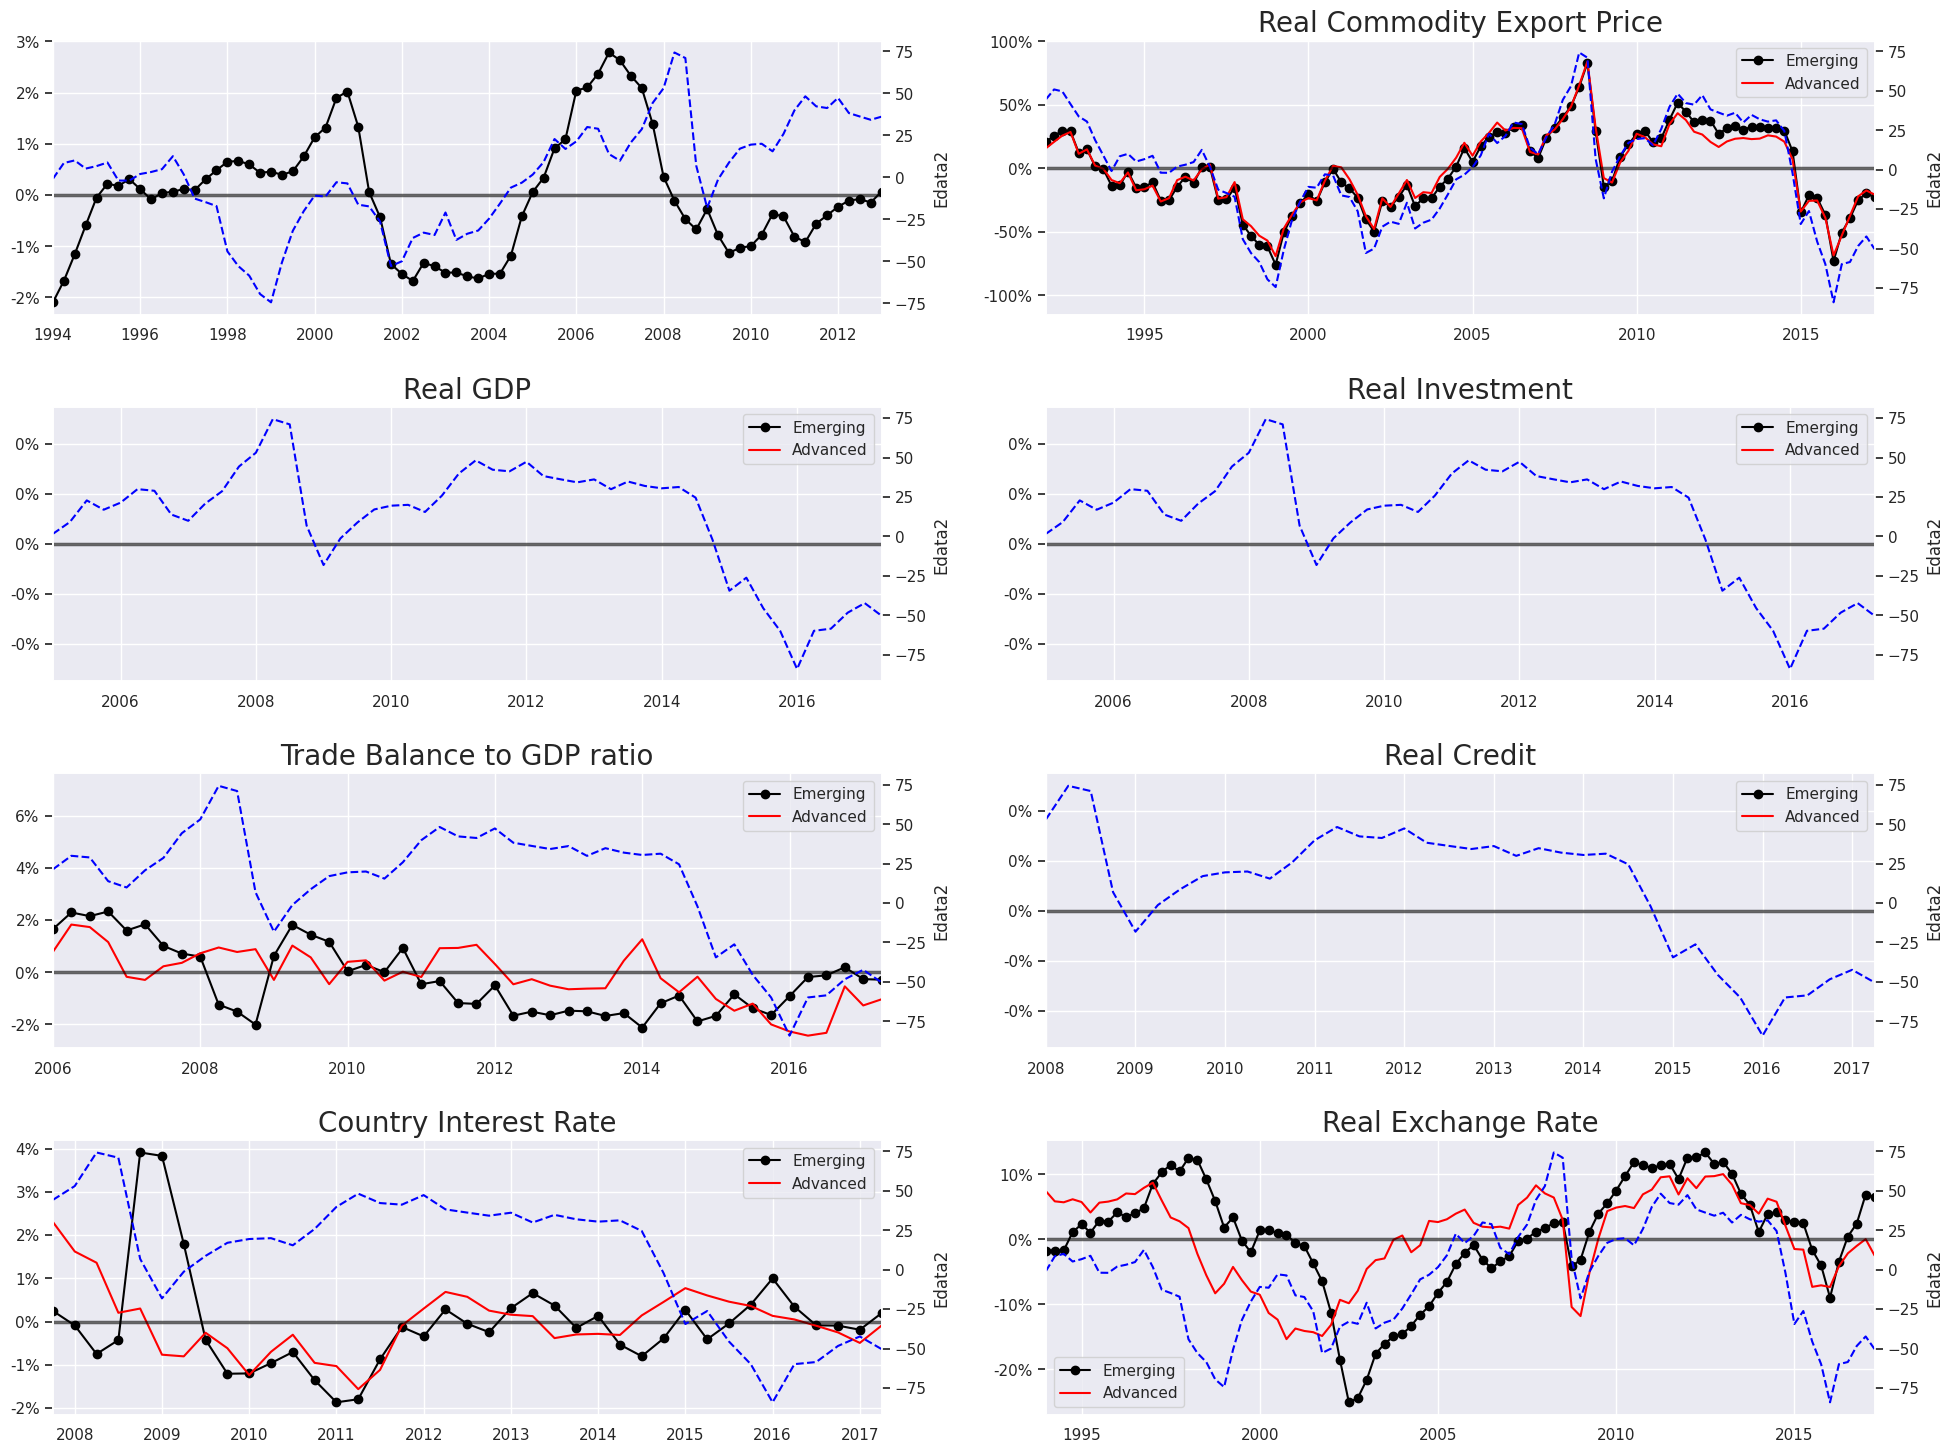

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Define detrending functions
detrend_func_USRATE = [DIL]
detrend_func_RGDPQ = [X13, RWLDC, hundredx]
detrend_func_RInvestment = [X13, RWLDC, hundredx]
detrend_func_TB_to_GDPQ = [DIL]
detrend_func_RCreditQ = [RWLDC, X13, hundredx]
detrend_func_CIRQ = [DIL]
detrend_func_ExchangeQ = [RWLDC, hundredx]
detrend_func_RealCEP = [RWLDC, hundredx]

# Assuming ExchangeQ is already resampled
ExchangeQ = ExchangeQ.resample('Q').mean().to_period('Q').to_timestamp('D')



# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

# Plot data
data_sets = [(USRATE, detrend_func_USRATE, 'US Interest Rate'),
             (RealCEP, detrend_func_RealCEP, 'Real Commodity Export Price'),
             (RGDPQ, detrend_func_RGDPQ, 'Real GDP'),
             (RInvestment, detrend_func_RInvestment, 'Real Investment'),
             (TB_to_GDPQ, detrend_func_TB_to_GDPQ, 'Trade Balance to GDP ratio'),
             (RCreditQ, detrend_func_RCreditQ, 'Real Credit'),
             (CIRQ, detrend_func_CIRQ, 'Country Interest Rate'),
             (ExchangeQ, detrend_func_ExchangeQ, 'Real Exchange Rate')]

for idx, (data, detrend_func, title) in enumerate(data_sets,start=0):
    if idx!=0:
        row_idx = idx // 2
        col_idx = idx % 2
        ax = axes[row_idx, col_idx]
        plot_data(data, ax, detrend_func, title)
        ax2 = ax.twinx()
        EdataA = Edata2[Edata2.index.isin(data.dropna().index)].copy().to_period('Q').to_timestamp('D')
        EdataA.plot(ax=ax2, label='IMF Real Commodity Price', linestyle='--', color='blue', legend=False)
        ax2.set_ylabel('Edata2')
        ax2.grid(False)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5, alpha=0.6)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    else:
        row_idx = idx // 2
        col_idx = idx % 2
        ax = axes[row_idx, col_idx]
        Geg = pd.DataFrame(DIL(USRATE[(USRATE.index>='1994-01-01') & (USRATE.index<='2013-01-01')].resample('Q')\
                 .mean())).mean(axis=1)
        Geg.plot(color='black', marker='o',ax=ax)
        ax2 = ax.twinx()
        EdataA= Edata2[Edata2.index.isin(USRATE[(USRATE.index>='1994-01-01') & (USRATE.index<='2013-01-01')].index)].copy().to_period('Q').to_timestamp('D')
        EdataA.plot(ax=ax2, label='IMF Real Commodity Price', linestyle='--', color='blue', legend=False)
        ax2.set_ylabel('Edata2')
        ax2.grid(False)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5, alpha=0.6)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
        Geg.index=pd.to_datetime(Geg.index)

# Adjust layout and save plot
fig.tight_layout(pad=2.0)
plt.savefig('./Shousha/FigureA_1.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
for idx, (data, detrend_func, title) in enumerate(data_sets,start=0):
    

In [22]:
# Create an empty list to store results
a = []

# List of labels excluding 'RealCEP'
labels = ['E', 'A']


for label in labels:
    dataframes = [FCBC(RWLDC(ExchangeQ.dropna()), label), 
                  FCBC(RWLDC(X13(RGDPQ.dropna())), label),
                  FCBC(RWLDC(X13(RCreditQ.dropna())), label),
                  FCBC(DIL(TB_to_GDPQ.dropna() / 100), label),
                  DIL(USRATE.dropna() / 100), 
                  FCBC(RWLDC(X13(RInvestment.dropna())), label),
                  FCBC(DIL(CIRQ.dropna() / 100), label),
                  FCBC(RWLDC(RealCEP.dropna()), label)
                 ]

    dataframe_names = ['Effective exchange rate', 'Output', 'Real credit', 'Trade balance-to-gdp ratio',
                       'US real interest rate', 'Investment', 'Country real interest rate','Real Commodity Export Price']
    
    # Resample all DataFrames to quarterly frequency
    dataframes_resampled = [df.resample('Q').mean() for df in dataframes]

    # Find common index using reduce and np.intersect1d
    common_index = reduce(np.intersect1d, [df.index for df in dataframes_resampled])

    # Use isin() to filter DataFrames based on the common index
    dataframes_sliced = [df[df.index.isin(common_index)] for df in dataframes_resampled]

    # Create a DataFrame to store the results
    results_df = pd.DataFrame()

    # Calculate correlation coefficients
    reference_frame1 = dataframes_sliced[1].mean(axis=1).values  # Assuming RGDPQ is the reference frame
    reference_frame2 = dataframes_sliced[7].mean(axis=1).values  # Assuming RGDPQ is the reference frame

    for i, frame in enumerate(dataframes_sliced):
        mean_values_frame = frame.mean(axis=1).values

        correlation_coefficient1 = np.corrcoef(mean_values_frame, reference_frame1)[0, 1]
        std_deviation = frame.mean(axis=1).std()
        correlation_coefficient2 =  np.corrcoef(mean_values_frame, reference_frame2)[0, 1]

        # Add the results to the DataFrame
        results_df[dataframe_names[i]] = [std_deviation, correlation_coefficient1,correlation_coefficient2]  

    # Append the results DataFrame to the list
    a.append(results_df)

# Combine DataFrames for Emerging and Advanced
combined_df = pd.concat(a, axis=1, keys=['Emerging', 'Advanced'])

# Transpose the DataFrame for the desired format
formatted_df = combined_df.T.reset_index().rename(columns={'level_0': 'Variables', 'level_1': 'Variable'})
formatted_df = formatted_df.pivot(index='Variable', columns='Variables', values=[0, 1, 2])

# Display the formatted DataFrame
formatted_df.columns = formatted_df.columns.set_levels(['$σ(X)$', '$ρ(X,Y)$','$ρ(X,PCM)$'], level=0)

# Define the desired order and names for the index
desired_order = ['Output', 'Investment', 'Trade balance-to-gdp ratio', 'Real credit', 'US real interest rate', 'Real Commodity Export Price', 'Country real interest rate', 'Effective exchange rate']
desired_names = ['Y', 'I', 'TBY', 'Crt', '$R_{\text{us}}$', 'PCM', 'R', 'REER']

# Rearrange the index
formatted_df = formatted_df.reindex(desired_order)

# Rename the index
formatted_df.index = pd.Index(desired_names)

# Display the formatted DataFrame

latex_table1 = formatted_df.to_latex(index=True)

#with open('./Latex_doc/Tables/Summary.tex', 'w', encoding='utf-8') as f:
    #f.write(latex_table1)
formatted_df

$σ(X)$          $ρ(X,Y)$          $ρ(X,PCM)$         
Variables       Advanced Emerging Advanced Emerging   Advanced Emerging
Y                    NaN      NaN      NaN      NaN        NaN      NaN
I                    NaN      NaN      NaN      NaN        NaN      NaN
TBY               0.0106   0.0100      NaN      NaN     0.7986  -0.2163
Crt                  NaN      NaN      NaN      NaN        NaN      NaN
$R_{\text{us}}$   0.0063   0.0063      NaN      NaN    -0.4308  -0.4687
PCM               0.3161   0.3403      NaN      NaN     1.0000   1.0000
R                 0.0065   0.0113      NaN      NaN    -0.0636  -0.3246
REER              0.0600   0.0544      NaN      NaN     0.6734   0.5834

In [23]:
dataframes =       [ExchangeQ,
                    RGDPQ,
                    RCreditQ,
                    TB_to_GDPQ,
                    RInvestment,
                    CIRQ,
                    RealCEP]

det_list = [[RWLDC],[RWLDC,X13],[RWLDC,X13],[DIL],[RWLDC,X13],[DIL], [RWLDC]]

def apply_func(df,list1=[]):
    for item in list1:
        df=item(df)
    return df

dataframe_names = ['Effective exchange rate', 'Output', 'Real credit', 'Trade balance-to-gdp ratio',\
                   'Investment', 'Country real interest rate','Real Commodity Export Price']
emerging_countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Peru', 'South Africa']
advanced_countries = ['Australia', 'Canada', 'New Zealand', 'Norway']

interested_countries = advanced_countries + emerging_countries

# Create an empty dictionary to store dataframes
result_dict = {}

for country in interested_countries:
    result_dict[country]=pd.DataFrame()
for i, df in enumerate(dataframes):
    # Filter the dataframe columns based on interested countries
    df1 = apply_func(df.dropna(),det_list[i]).copy()
    df_filtered =FCBC(df1,'E', emerging_countries+advanced_countries)
    df_filtered = df_filtered.to_period('Q').to_timestamp('D')
    # Keep only the columns that are present in the original dataframe
    present_countries = df_filtered.columns.intersection(interested_countries)
    df_filtered = df_filtered[present_countries]
    # Iterate through countries and create a dataframe for each
    for country in present_countries:
        result_dict[country][dataframe_names[i]] = df1[country].to_period('Q').to_timestamp('D')
        result_dict[country] =  result_dict[country].dropna()

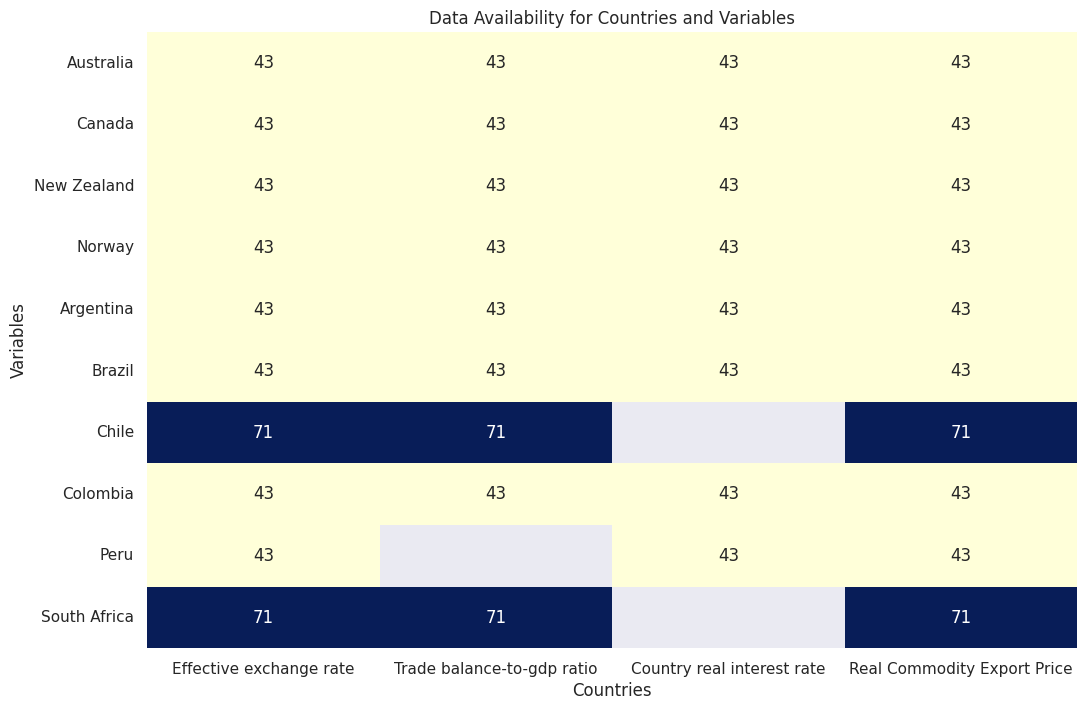

In [24]:
# Initialize an empty list to store individual Series
series_list = []

# Iterate through the keys in result_dict
for key in result_dict.keys():
    # Create a series for each country with columns as variables
    country_series = pd.Series(index=result_dict[key].columns, data=result_dict[key].shape[0], name=key)
    
    # Append the country series to the list
    series_list.append(country_series)

# Concatenate the list of Series into a DataFrame
result_df = pd.concat(series_list, axis=1)

# Display the resulting dataframe
result_df

# Plotting using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(result_df.T, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title("Data Availability for Countries and Variables")
plt.xlabel("Countries")
plt.ylabel("Variables")
plt.savefig('./Shousha/FigureA_2.pdf', bbox_inches='tight')
plt.grid(False)
plt.show()


In [ ]:
# Initialize an empty list to store individual Series
series_list = []

# Iterate through the keys in result_dict
for key in result_dict.keys():
    # Create a series for each country with columns as variables
    country_series = pd.Series(index=result_dict[key].columns, data=result_dict[key].mean(), name=key)
    
    # Append the country series to the list
    series_list.append(country_series)

# Concatenate the list of Series into a DataFrame
result_df = pd.concat(series_list, axis=1)

# Display the resulting dataframe

# Plotting using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(result_df.T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Mean Values for Countries and Variables")
plt.xlabel("Countries")
plt.ylabel("Variables")
plt.savefig('./Shousha/FigureA_3.pdf', bbox_inches='tight')
plt.grid(False)

plt.show()


In [ ]:
n=5
rot = 0
hori = 20
h=hori
p=2
nvar=1
legend = None
types = ['A','E']
RealCEP_c=pd.DataFrame(X13(RWLDC(RealCEP.dropna()))).copy()
RInvestment_c=pd.DataFrame(RWLDC(X13(RInvestment.dropna()))).copy()
RGDPQ_c=pd.DataFrame(RWLDC(X13(RGDPQ.dropna()))).copy()
RCreditQ_c=pd.DataFrame(RWLDC(X13(RCreditQ.dropna()))).copy()
ExchangeQ_c=pd.DataFrame(RWLDC(X13(ExchangeQ.dropna()))).copy()
CIRQ_c  = pd.DataFrame(DIL(X13(CIRQ.dropna()/10))).copy()
TB_to_GDPQ_c= pd.DataFrame(DIL(X13(TB_to_GDPQ.dropna()/100))).copy()


for typ in types:
    
    Allc= pd.DataFrame()
    Allc['RealCEP'] =    FCBC(RealCEP_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['Investment'] = FCBC(RInvestment_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['GDP'] =        FCBC(RGDPQ_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['RealCredit'] = FCBC(RCreditQ_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')             
    Allc['ExchangeQ'] =  FCBC(ExchangeQ_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['TB_to_GDPQ'] = FCBC(TB_to_GDPQ_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['CIRQ'] =       FCBC(CIRQ_c,typ).mean(axis=1).to_period('Q').to_timestamp('D')

     
    Allc=Allc[['RealCEP','Investment','GDP','RealCredit','ExchangeQ']]
    Allc=Allc.dropna()

    desired_order =Allc.columns
    # Prepare lagged input matrix X for SVAR model
    X = (Allc.iloc[:, 0:n])
    X.columns = range(X.columns.size)
    X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
    X = X[p:, :]
    X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

    # Extracting variables for SVAR analysis
    Z1 = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx',sheet_name='Monthly')
    Z1.set_index('Date',inplace=True)
    Z1.index = pd.to_datetime(Z1.index,format='%YM%m')
    Z1= Z1.resample('Q').sum().to_period('Q').to_timestamp('D')
    start_date, end_date = Z1.index.min(), Z1.index.max()

    # Convert the index to the desired frequency 'QS-OCT'
    new_index = pd.date_range(start=start_date, end=end_date, freq='QS-OCT')

    # Reindex the DataFrame with the new index
    Z2 = Z1.reindex(new_index)
    Z2['Oil supply surprise series']=Z1['Oil supply surprise series']
    Z2=Z2[Z2.index.isin(Allc.index)]
    Z2=Z2['Oil supply surprise series']
    Z3= X13((pd.DataFrame(Z2))).values[p:, :]
    Z=Z3
    Y = pd.DataFrame(Allc.iloc[:, 0:n]).values[p:, :]
    
    ols_est = SVARIV.ols(Y, X)
    eta = ols_est['errors']

    # Set up SVAR parameters
    nvar = 1
    WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)
    print(wald)
    
    betas = ols_est['betas_hat'].T
    betas_lag = betas[:, 1:]
    omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])


    # Compute impulse response functions for SVAR and Cholesky
    irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
    irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)

    # Fit VAR model for comparison
    model = VAR(Allc.dropna())
    results = model.fit(p)
    VAR1 = ((pd.DataFrame(results.irf(hori).irfs.T[0])) * 0.1)
 

    # Compute impulse response functions for SVAR and Cholesky
    irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False, periods=h)
    irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True, periods=h)
    irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False, periods=h)
    irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True, periods=h)

    # Fit VAR model for comparison
    model = VAR(Allc.dropna())
    results = model.fit(p)
    VAR1 = ((pd.DataFrame(results.irf(hori).irfs.T[0])) * 0.1)

    # Compute moving average representation matrices
    C = SVARIV.MA_representation(betas_lag, p, hori=h)
    Ccum = [np.array(C[:i + 1]).sum(axis=0) for i in range(len(C))]
    G = SVARIV.Gmatrices(betas_lag, p, hori=h)['G']
    Gcum = SVARIV.Gmatrices(betas_lag, p, hori=h)['Gcum']
    T = len(Y)

    # Set up plotting parameters
    xticks = list(range(len(irf_gamma_cum)))

    # Confidence Intervals and Cumulative options
    conf_intervals = [0.60, 0.90]
    Lp1 = [False, False]

    cumulative_options = [False, True]

    # Titles for each subplot
    titles = map_column_names_to_labels(desired_order)


    # Loop over confidence intervals and cumulative options
    for ci_idx, ci in enumerate(conf_intervals):

        CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1, nvar=1)
        CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1, nvar=1)
        CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C, hori=h, confidence=ci, scale=0.1)
        CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum, hori=h, confidence=ci, scale=0.1)

        lpmdl = LP.LP(Allc.reset_index(drop=True),maxlags=1,ci=ci,use_correction=False)
        out, _ = lpmdl.estimate(hori,shock_size=0.1)
        # Select rows where impulse is 'POIL'
        poil_df = out.loc['RealCEP']

        # Reset the index to create a one-index DataFrame
        poil_df_reset = poil_df.reset_index()
        coef = pd.DataFrame()
        lb = pd.DataFrame()
        ub = pd.DataFrame()

        for colmn in Allc.columns:
            coef[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['coef'].values[:-1]
            lb[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['lb'].values[:-1]
            ub[colmn] = poil_df_reset[poil_df_reset['response']==colmn]['ub'].values[:-1]

        coef_cum=np.cumsum(coef)
        lb_cum=np.cumsum(lb)
        ub_cum=np.cumsum(ub)
        
        
        # Create a new figure for each combination
        for cum_idx, cum_opt in enumerate(cumulative_options):
            for lp_opt in Lp1:

                fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.4})
                axs_flat = axs.flatten()

                for i, ax in enumerate(axs_flat):
                    if i >= len(titles):
                        fig.delaxes(ax)
                        continue

                    title = titles[i]
                    col = Allc.columns[i]

                    if i >= len(titles):
                        fig.delaxes(ax)
                        continue

                    # Set y-axis limits based on the column and cumulative option
                    if (typ == 'A'):    
                        if cum_opt:
                            if col == 'RealCEP':
                                ylim1 = 1.5
                                ylim0 = -0.1
                            elif col == 'Investment':
                                ylim1 = 0.2
                                ylim0 = -0.2
                            elif col == 'GDP':
                                ylim1 = 0.1
                                ylim0 = -0.1
                            elif col == 'RealCredit':
                                ylim1 = 0.1
                                ylim0 = -0.2
                            elif col == 'ExchangeQ':
                                ylim1 = 0.2
                                ylim0 = -0.2

                        else:
                            if col == 'RealCEP':
                                ylim1 = 0.2
                                ylim0 = -0.15
                            elif col == 'Investment':
                                ylim1 = 0.05
                                ylim0 = -0.05
                            elif col == 'GDP':
                                ylim1 = 0.01
                                ylim0 = -0.01
                            elif col == 'RealCredit':
                                ylim1 = 0.02
                                ylim0 = -0.02
                            elif col == 'ExchangeQ':
                                ylim1 = 0.05
                                ylim0 = -0.05
                    else:
                        if cum_opt:
                            if col == 'RealCEP':
                                ylim1 = 1.5
                                ylim0 = -0.1
                            elif col == 'Investment':
                                ylim1 = 0.2
                                ylim0 = -0.2
                            elif col == 'GDP':
                                ylim1 = 0.1
                                ylim0 = -0.1
                            elif col == 'RealCredit':
                                ylim1 = 0.1
                                ylim0 = -0.2
                            elif col == 'ExchangeQ':
                                ylim1 = 0.2
                                ylim0 = -0.2

                        else:
                            if col == 'RealCEP':
                                ylim1 = 0.2
                                ylim0 = -0.05
                            elif col == 'Investment':
                                ylim1 = 0.05
                                ylim0 = -0.02
                            elif col == 'GDP':
                                ylim1 = 0.02
                                ylim0 = -0.02
                            elif col == 'RealCredit':
                                ylim1 = 0.01
                                ylim0 = -0.02
                            elif col == 'ExchangeQ':
                                ylim1 = 0.04
                                ylim0 = -0.01

                    if cum_opt:
                        plugin_cs = np.array([irf_gamma_cum[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :],
                                              irf_gamma_cum[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s_cum['pluginirfstderror'][i, :]]).T
                    else:
                        plugin_cs = np.array([irf_gamma[:, i] + SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :],
                                              irf_gamma[:, i] - SVARIV.norm_critval(confidence=ci) * CI_s['pluginirfstderror'][i, :]]).T

                    low_plugin = plugin_cs[:, 0]
                    upp_plugin = plugin_cs[:, 1]



                    # Calculate VAR impulse response for comparison
                    VAR_P = np.cumsum(((pd.DataFrame(results.irf(hori).irfs.T[0])) * 0.1).iloc[i]).values[:-1] if cum_opt else \
                            (((pd.DataFrame(results.irf(hori).irfs.T[0])) * 0.1).iloc[i]).values[:-1]
                    if lp_opt:
                        # Plotting
                        ax.set_title(f'{title}', fontsize=18)
                        ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                        ax.plot(coef_cum.values[:, i] if cum_opt else coef.values[:, i], color='purple', zorder=1, linewidth=1, label='LP')
                        ax.fill_between(xticks, lb_cum.values[:, i]  if cum_opt else lb.values[:, i] , ub_cum.values[:, i] \
                                        if cum_opt else ub.values[:, i], color='r', alpha=.1, label=r'$CS^{\mathrm{LP}}$')

                        ax.grid(True)
                        ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                        ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                        ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                        ax.set_ylim(ylim0, ylim1)
                        ax.set_xlim(0, hori)
                        ax.set_xlabel("", fontsize=10)
                        ax.set_ylabel("", fontsize=10)
                        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                    else: 
                        ax.set_title(f'{title}', fontsize=18)
                        ax.plot(irf_gamma_cum[:, i] if cum_opt else irf_gamma[:, i], color='blue', zorder=1, linewidth=1, label='SVARIV')
                        ax.plot(irf_chol_cum[:, i] if cum_opt else irf_chol[:, i], color='red', zorder=1, linewidth=1, label='Cholesky')
                        ax.plot(VAR_P, color='darkgreen', zorder=1, linewidth=1, label='VAR')
                        ax.fill_between(xticks, low_plugin, upp_plugin, color='b', alpha=.1, label=r'$CS^{\mathrm{plugin}}$')
                        ax.plot(CI_cum['l'][i, :] if cum_opt else CI['l'][i, :], '--', zorder=1, linewidth=1, color='orange', label=r'$CS^{\mathrm{AR}}$')
                        ax.plot(CI_cum['u'][i, :] if cum_opt else CI['u'][i, :], '--', zorder=1, linewidth=1, color='orange')                 
                        ax.grid(True)
                        ax.axhline(y=0, color='black', linestyle='-', linewidth=2.5)
                        ax.set_xticks(list(range(0, len(xticks) + 1, 10)))
                        ax.set_xticklabels(list(range(0, len(xticks) + 1, 10)), rotation=rot)
                        ax.set_ylim(ylim0, ylim1)
                        ax.set_xlim(0, hori)
                        ax.set_xlabel("", fontsize=10)
                        ax.set_ylabel("", fontsize=10)
                        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
                    fig.text(0.5, -0.01, r'$\mathrm{Month}$', ha='center', va='center', fontsize=14)
    
                    # Add 'Cumulative' to suptitle only for cumulative options
                suptitle_str1 = 'Cumulative ' if cum_opt else '' 
                suptitle_str2 = 'Advanced Countries ' if typ=='A' else 'Emerging Countries' 

                fig.suptitle(suptitle_str1 + 'Impulse responses for ' +suptitle_str2+ ' for ' +str(ci) + ' CI', fontsize=20, y=0.95)


                # Place the legend outside of the subplots
                handles, labels = axs_flat[0].get_legend_handles_labels()
                fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 0.94), fontsize=12)

                # Save the figure with a unique name based on CI and cumulative options
                saved = f'./Shousha/IRF_pdfs/IRF_Figure1_{ci}_Cumulative_{cum_opt}_LP_{lp_opt}_Countries{typ}.pdf'
                plt.tight_layout(rect=[0, 0, 0.9, 1])
                plt.savefig(saved, bbox_inches='tight')
                plt.show()
    plt.close()

In [ ]:
import scipy.stats

Allc2 = []

for typ in types:
    Allc = pd.DataFrame()
    Allc['RealCEP'] = FCBC(RealCEP_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['Investment'] = FCBC(RInvestment_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['GDP'] = FCBC(RGDPQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['RealCredit'] = FCBC(RCreditQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')             
    Allc['ExchangeQ'] = FCBC(ExchangeQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['TB_to_GDPQ'] = FCBC(TB_to_GDPQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['CIRQ'] = FCBC(CIRQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')

    Allc = Allc[['RealCEP', 'Investment', 'GDP', 'RealCredit', 'ExchangeQ', 'TB_to_GDPQ']]
    Allc = Allc.dropna()
    Allc2.append(Allc)

n = 6

results_df = pd.DataFrame(columns=['Countries', 'F-statistics', 'P-value', 'Wald estimated'])

lis = ['Advanced countries', 'Emerging countries'] 

for gc, Allc in enumerate(Allc2):
    # Prepare the lagged regressors
    X = (Allc.iloc[:, 0:n])
    X.columns = range(X.columns.size)
    X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
    X = X[p:, :]
    X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

    # Extracting variables for SVAR analysis
    Z1 = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx', sheet_name='Monthly')
    Z1.set_index('Date', inplace=True)
    Z1.index = pd.to_datetime(Z1.index, format='%YM%m')
    Z1 = Z1.resample('Q').sum().to_period('Q').to_timestamp('D')
    start_date, end_date = Z1.index.min(), Z1.index.max()

    # Convert the index to the desired frequency 'QS-OCT'
    new_index = pd.date_range(start=start_date, end=end_date, freq='QS-OCT')

    # Reindex the DataFrame with the new index
    Z2 = Z1.reindex(new_index)
    Z2['Oil supply surprise series'] = Z1['Oil supply surprise series']
    Z2 = Z2[Z2.index.isin(Allc.index)]
    Z2 = Z2['Oil supply surprise series']
    Z3 = X13((pd.DataFrame(Z2) / 100)).values[p:, :]
    Z = Z3
    Y = pd.DataFrame(Allc.iloc[:, 0:n]).values[p:, :]
    F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
    p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)

    ols_est = SVARIV.ols(Y, X)
    eta = ols_est['errors']

    # Set up SVAR parameters
    nvar = 1
    WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

    betas = ols_est['betas_hat'].T
    betas_lag = betas[:, 1:]
    omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

    # Calculate the F-statistic and p-value
    F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
    p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)
  
    # Test Wald and Gamma_hat
    WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

    # Concatenate results to results_df
    temp_df = pd.DataFrame({
        'Countries': lis[gc],
        'F-statistics': F,
        'P-value': 1 - p_value,
        'Wald estimated': wald
    }, index=[0])

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Display the resulting dataframe
display(results_df)

latex_table = results_df.to_latex(index=False)

with open('./Latex_doc/Tables/10percentShockRCEP.tex', 'w') as f:
    f.write(latex_table)


In [ ]:
Allc_data = [Allc2[0], Allc2[1]] 
plot_svariv_curves(Allc_data,saved='./Shousha/Figure2.pdf')


In [ ]:
import scipy.stats

Allc2 = []

for typ in types:
    Allc = pd.DataFrame()
    Allc['RealCEP'] = FCBC(RealCEP_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['Investment'] = FCBC(RInvestment_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['GDP'] = FCBC(RGDPQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['RealCredit'] = FCBC(RCreditQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')             
    Allc['ExchangeQ'] = FCBC(ExchangeQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['TB_to_GDPQ'] = FCBC(TB_to_GDPQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    Allc['CIRQ'] = FCBC(CIRQ_c, typ).mean(axis=1).to_period('Q').to_timestamp('D')
    
    Allc = Allc[['CIRQ', 'Investment', 'GDP', 'RealCredit', 'ExchangeQ', 'TB_to_GDPQ']]
    Allc = Allc.dropna()
    Allc2.append(Allc)

n = 6
results_df = pd.DataFrame(columns=['Countries', 'F-statistics', 'P-value', 'Wald estimated'])

lis = ['Advanced countries', 'Emerging countries'] 
for gc, Allc in enumerate(Allc2):
    # Prepare the lagged regressors
    X = (Allc.iloc[:, 0:n])
    X.columns = range(X.columns.size)
    X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p + 1)], axis=1)
    X = X[p:, :]
    X = np.concatenate([np.ones((len(X), 1)), X], axis=1)

    # Extracting variables for SVAR analysis
    Z1 = pd.read_excel('./Main_Data/oilSupplyNewsShocks_2023M06.xlsx', sheet_name='Monthly')
    Z1.set_index('Date', inplace=True)
    Z1.index = pd.to_datetime(Z1.index, format='%YM%m')
    Z1 = Z1.resample('Q').sum().to_period('Q').to_timestamp('D')
    start_date, end_date = Z1.index.min(), Z1.index.max()

    # Convert the index to the desired frequency 'QS-OCT'
    new_index = pd.date_range(start=start_date, end=end_date, freq='QS-OCT')

    # Reindex the DataFrame with the new index
    Z2 = Z1.reindex(new_index)
    Z2['Oil supply surprise series'] = Z1['Oil supply surprise series']
    Z2 = Z2[Z2.index.isin(Allc.index)]
    Z2 = Z2['Oil supply surprise series']
    Z3 = X13((pd.DataFrame(Z2) / 100)).values[p:, :]
    Z = Z3
    Y = pd.DataFrame(Allc.iloc[:, 0:n]).values[p:, :]
    F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
    p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)

    ols_est = SVARIV.ols(Y, X)
    eta = ols_est['errors']

    # Set up SVAR parameters
    nvar = 1
    WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

    betas = ols_est['betas_hat'].T
    betas_lag = betas[:, 1:]
    omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors'])

    # Calculate the F-statistic and p-value
    F = np.var(eta.T[0], ddof=1) / np.var(Z, ddof=1)
    p_value = scipy.stats.f.cdf(F, eta.T[0].size - 1, Z.size - 1)
  
    # Test Wald and Gamma_hat
    WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)

    new_row = pd.DataFrame({
    'Countries': [lis[gc]],
    'F-statistics': [F],
    'P-value': [1 - p_value],
    'Wald estimated': [wald]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

latex_table = results_df.to_latex(index=False)

with open('./Latex_doc/Tables/2percentShockCIR.tex', 'w') as f:
    f.write(latex_table)


In [ ]:
Allc_data = [Allc2[0], Allc2[1]] 

plot_svariv_curves(Allc_data,saved='./Shousha/Figure3.pdf',p=2,scale=0.02,irf_g=False)
f.close()

# Theoretical model

In [ ]:
class DifferentialEvolutionOptimizer:
    def __init__(self, objective_function, bounds, de_population_size=10, adam_population_size=10, de_iterations=1000, mutation_factor=0.8, crossover_rate=0.9, device='cuda'):
        self.objective_function = objective_function
        self.bounds = torch.tensor(bounds, dtype=torch.float32, device=device)
        self.de_population_size = de_population_size
        self.adam_population_size = adam_population_size
        self.de_iterations = de_iterations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimensions = len(bounds)
        self.device = device

        # Initialize population for DE
        self.population_de = self.bounds[:, 0] + torch.rand((self.de_population_size, self.dimensions), device=device) * (self.bounds[:, 1] - self.bounds[:, 0])
        self.objectives_de = self.objective_function(self.population_de)
        best_index_de = torch.argmin(self.objectives_de)  # Find the best index for single objective
        self.best_solution_de = self.population_de[best_index_de]
        self.best_objective_de = self.objectives_de[best_index_de]
        self.previous_objective_de = self.best_objective_de

        # Initialize dataset and dataloader for DE with num_workers=0 to avoid multiprocessing issues with CUDA
        self.dataset_de = PopulationDataset(self.population_de, self.bounds)
        self.dataloader_de = DataLoader(self.dataset_de, batch_size=self.de_population_size, shuffle=False, num_workers=0)

        # Initialize population for Adam
        self.population_adam = self.bounds[:, 0] + torch.rand((self.adam_population_size, self.dimensions), device=device) * (self.bounds[:, 1] - self.bounds[:, 0])

    def mutate(self, a, b, c):
        return a + self.mutation_factor * (b - c)

    def ensure_bounds(self, vector):
        return torch.clamp(vector, self.bounds[:, 0], self.bounds[:, 1])

    def crossover(self, mutated, target):
        crossover_prob = torch.rand(self.dimensions, device=self.device)
        return torch.where(crossover_prob < self.crossover_rate, mutated, target)

    def differential_evolution(self):
        history = []
        
        for _ in tqdm(range(self.de_iterations)):
            for population_batch, bounds_batch in self.dataloader_de:
                indices = torch.randperm(self.de_population_size, device=self.device)
                for j in range(population_batch.size(0)):
                    idxs = indices[indices != j]
                    a, b, c = population_batch[idxs[:3]]
                    mutated = self.mutate(a, b, c)
                    mutated = self.ensure_bounds(mutated)
                    trial = self.crossover(mutated, population_batch[j])
                    objective_trial = self.objective_function(trial.unsqueeze(0))
                    if torch.all(objective_trial < self.objectives_de[j]):
                        self.population_de[j] = trial
                        self.objectives_de[j] = objective_trial

            best_index = torch.argmin(self.objectives_de)
            best_objective = self.objectives_de[best_index]
            if torch.all(best_objective < self.previous_objective_de):
                self.best_solution_de = self.population_de[best_index]
                self.previous_objective_de = best_objective
            history.append(self.best_objective_de.detach().cpu().numpy())

        return self.best_solution_de, self.best_objective_de.detach()

    def adam_optimizer(self, adam_epochs, learning_rate):
        adam_dataset = PopulationDataset(self.population_adam, self.bounds)
        adam_dataloader = DataLoader(adam_dataset, batch_size=1, shuffle=False, num_workers=0)
    
        population = []
        for x_init, bounds in tqdm(adam_dataloader):
            x_init = x_init.to(self.device).requires_grad_(True)
            optimizer = optim.Adam([x_init], lr=learning_rate)
            for _ in range(adam_epochs):
                optimizer.zero_grad()
                output = self.objective_function(x_init)
                loss = torch.sum(output)
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    x_init.data = torch.clamp(x_init.data, self.bounds[:, 0], self.bounds[:, 1])
            population.append((x_init.clone().detach().cpu().numpy(), self.objective_function(x_init).detach().cpu().numpy().squeeze(0)))
        return population

    def find_pareto_front(self, adam_epochs, learning_rate, use_adam=True):
        if use_adam:
            population = self.adam_optimizer(adam_epochs, learning_rate)
        else:
            self.differential_evolution()
            population = [(self.population_de[i].detach().cpu().numpy(), self.objectives_de[i].detach().cpu().numpy()) for i in range(self.de_population_size)]
        
        solutions = np.array([sol[1] for sol in population]).squeeze()
        if solutions.ndim == 1:
            solutions = solutions.reshape(1, -1)
    
        pareto_mask = self.identify_pareto_front(torch.tensor(solutions, device=self.device)).cpu().numpy().astype(bool)
        pareto_front = [population[i] for i in range(len(population)) if pareto_mask[i]]
        
        return pareto_front

    def identify_pareto_front(self, scores):
        is_pareto = torch.ones(scores.shape[0], dtype=bool, device=scores.device)
        for i in range(scores.shape[0]):
            for j in range(scores.shape[0]):
                if torch.all(scores[j] <= scores[i]) and torch.any(scores[j] < scores[i]):
                    is_pareto[i] = False
                    break
        return is_pareto

    def plot_solutions_2d(self, solutions, title):
        if solutions.ndim == 1:
            solutions = solutions.reshape(-1, 1)  # Ensure 2D if only one solution exists
        if solutions.shape[1] == 1:  # If only one dimension, add a dummy second dimension
            solutions = torch.cat([solutions, torch.zeros_like(solutions)], dim=1)
        elif solutions.shape[1] == 0:  # If empty, create an empty 2D array
            solutions = torch.zeros((solutions.shape[0], 2), device=solutions.device)
        plt.figure(figsize=(8, 6))
        plt.scatter(solutions[:, 0].cpu(), solutions[:, 1].cpu(), color='blue', label='Solutions')
        plt.xlabel('f1')
        plt.ylabel('f2')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_pareto_front_2d(self, pareto_front, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(pareto_front[:, 0].cpu(), pareto_front[:, 1].cpu(), color='red', label='Pareto Front')
        plt.xlabel('f1')
        plt.ylabel('f2')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_solutions_3d(self):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.objectives_de[:, 0].cpu(), self.objectives_de[:, 1].cpu(), self.objectives_de[:, 2].cpu(), color='blue')
        best_obj_values = self.objective_function(self.best_solution_de.unsqueeze(0))
        ax.scatter(best_obj_values[0].cpu(), best_obj_values[1].cpu(), best_obj_values[2].cpu(), color='red', marker='x', s=100, label='Best Solution')
        ax.set_xlabel('f1')
        ax.set_ylabel('f2')
        ax.set_zlabel('f3')
        ax.set_title('Solution Distribution in Objective Space')
        ax.legend()
        plt.show()

    def plot_pareto_front_3d(self):
        pareto_front = self.identify_pareto_front(self.objectives_de)
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.objectives_de[:, 0].cpu(), self.objectives_de[:, 1].cpu(), self.objectives_de[:, 2].cpu(), color='blue', label='Solutions')
        ax.scatter(pareto_front[:, 0].cpu(), pareto_front[:, 1].cpu(), pareto_front[:, 2].cpu(), color='red', label='Pareto Front')
        ax.set_xlabel('f1')
        ax.set_ylabel('f2')
        ax.set_zlabel('f3')
        ax.set_title('Pareto Front in Objective Space')
        ax.legend()
        plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset

class ShoushaModel:
    def __init__(self, params, bounds, device='cuda'):
        self.params = {key: torch.tensor(value, dtype=torch.float32, requires_grad=False).to(device) for key, value in params.items()}
        self.bounds = torch.tensor(bounds, dtype=torch.float32, device=device)
        self.device = device

    def ar1_process(self, rho, sigma_epsilon, T=40):
        epsilon = torch.randn(T, device=self.device) * sigma_epsilon
        shocks = torch.zeros(T, device=self.device)
        for t in range(1, T):
            shocks[t] = rho * shocks[t-1] + epsilon[t]
        return shocks
    
    def log_likelihood(self, params, observed_data, optimized_steady_state_values):
        sigma_epsilon = params[4].to(self.device)  # Ensure sigma_epsilon is on the same device
        shocks = self.ar1_process(params[3].clone().detach().to(self.device), sigma_epsilon, 100)
        # Ensure params includes all necessary values
        c_irf, l_irf, k_irf, i_irf, yT_irf, yCM_irf, yN_irf, reeer_irf, total_output_irf, pT_irf, pN_irf, pCM_irf = self.generate_irfs(params, optimized_steady_state_values, shocks, 100)
    
        # Ensure observed_data is on the same device
        observed_data_device = {key: value.to(self.device) for key, value in observed_data.items()}
    
        if torch.any(torch.isnan(yT_irf)) or torch.any(torch.isnan(yCM_irf)) or torch.any(torch.isnan(yN_irf)):
            raise ValueError("Generated IRFs contain NaN values")
    
        log_lik_cT = torch.sum(torch.distributions.Normal(loc=c_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['cT']))
        log_lik_cN = torch.sum(torch.distributions.Normal(loc=c_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['cN']))
        log_lik_hCM = torch.sum(torch.distributions.Normal(loc=l_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['hCM']))
        log_lik_hT = torch.sum(torch.distributions.Normal(loc=l_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['hT']))
        log_lik_hN = torch.sum(torch.distributions.Normal(loc=l_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['hN']))
        log_lik_yT = torch.sum(torch.distributions.Normal(loc=yT_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['yT']))
        log_lik_yCM = torch.sum(torch.distributions.Normal(loc=yCM_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['yCM']))
        log_lik_yN = torch.sum(torch.distributions.Normal(loc=yN_irf[:100], scale=sigma_epsilon).log_prob(observed_data_device['yN']))
    
        return -(log_lik_cT + log_lik_cN + log_lik_hCM + log_lik_hT + log_lik_hN + log_lik_yT + log_lik_yCM + log_lik_yN)

    
    def generate_irfs(self, estimated_params, optimized_steady_state_values, shocks, T=40):
        # Unpack all necessary parameters from the estimated parameters
        (beta, sigma, phi, rho, sigma_epsilon, delta, alphaCM, alphaT, alphaN, gammaT, gammaCM, etaN, b, 
         phiCM, phiT, phiN, omegaCM, omegaT, omegaN, aT, aCM, aN, chi, mu, thetaT, R) = estimated_params
    
        optimized_steady_state_values = torch.tensor(optimized_steady_state_values, device=self.device)  # Ensure it's a torch tensor on the correct device
    
        c_irf = torch.zeros(T, device=self.device)
        l_irf = torch.zeros(T, device=self.device)
        k_irf = torch.zeros(T, device=self.device)
        i_irf = torch.zeros(T, device=self.device)
        yT_irf = torch.zeros(T, device=self.device)
        yCM_irf = torch.zeros(T, device=self.device)
        yN_irf = torch.zeros(T, device=self.device)
        reeer_irf = torch.zeros(T, device=self.device)
        total_output_irf = torch.zeros(T, device=self.device)
        pT_irf = torch.zeros(T, device=self.device)
        pN_irf = torch.zeros(T, device=self.device)
        pCM_irf = torch.zeros(T, device=self.device)
    
        # Start from steady state values
        c_irf[0] = optimized_steady_state_values[0]
        l_irf[0] = optimized_steady_state_values[2]
        k_irf[0] = optimized_steady_state_values[5]
        i_irf[0] = optimized_steady_state_values[6]
        yT_irf[0] = optimized_steady_state_values[9]
        yCM_irf[0] = optimized_steady_state_values[10]
        yN_irf[0] = optimized_steady_state_values[11]
        reeer_irf[0] = (optimized_steady_state_values[13] ** omegaT) / (optimized_steady_state_values[14] ** (1 - omegaT))
        pT_irf[0] = optimized_steady_state_values[12]
        pN_irf[0] = optimized_steady_state_values[13]
        pCM_irf[0] = optimized_steady_state_values[14]
    
        for t in range(1, T):
            # Update commodity prices based on the shock
            pCM_irf[t] = shocks[t]
            
            # Calculate outputs yT, yCM, yN based on the provided equations
            yT_irf[t] = thetaT * aT * k_irf[t]**alphaT * optimized_steady_state_values[10]**gammaT * l_irf[t]**(1 - alphaT - gammaT)
            yCM_irf[t] = aCM * (k_irf[t] / optimized_steady_state_values[7])**alphaCM * optimized_steady_state_values[10]**gammaCM * l_irf[t]**(1 - alphaCM - gammaCM)
            yN_irf[t] = aN * k_irf[t]**alphaN * l_irf[t]**(1 - alphaN)
            
            # Calculate total output
            total_output_irf[t] = yT_irf[t] + yCM_irf[t] + yN_irf[t]
            
            # Calculate reeer
            reeer_irf[t] = (chi**mu + (1 - chi)**mu * (reeer_irf[t-1]**(1 - mu)))**(1 / mu)
            
            # Update capital stock based on the detailed equation
            i_irf[t] = shocks[t]  # Investment is driven by the shocks
            k_irf[t] = (1 - delta) * k_irf[t-1] + i_irf[t] * (1 - (phi / 2) * (i_irf[t] / ((i_irf[t-1]) - 1)**2)) # Avoid division by zero and negative values
    
            # Calculate prices pT and pN based on equations A.59 and provided equations
            pT_irf[t] = aT * (k_irf[t] / l_irf[t])**alphaT
            pN_irf[t] = ((1 - chi) / chi * (aT * thetaT * (k_irf[t] / optimized_steady_state_values[10])**(alphaT + gammaT) * (optimized_steady_state_values[14] * (1 - beta) / reeer_irf[t])**(omegaT - 1) - i_irf[t] - phiT - delta * (k_irf[t] / l_irf[t]) * l_irf[t] - etaN + etaN * optimized_steady_state_values[14])**(1 / mu))
    
            # Debugging: Print intermediate values to check for invalid values
            if torch.isnan(yT_irf[t]) or torch.isnan(yCM_irf[t]) or torch.isnan(yN_irf[t]) or torch.isnan(total_output_irf[t]) or torch.isinf(yT_irf[t]) or torch.isinf(yCM_irf[t]) or torch.isinf(yN_irf[t]) or torch.isinf(total_output_irf[t]):
                print(f"Invalid value at t={t}")
                print(f"yT_irf[t]: {yT_irf[t]}, yCM_irf[t]: {yCM_irf[t]}, yN_irf[t]: {yN_irf[t]}, total_output_irf[t]: {total_output_irf[t]}")
                break
    
        return c_irf, l_irf, k_irf, i_irf, yT_irf, yCM_irf, yN_irf, reeer_irf, total_output_irf, pT_irf, pN_irf, pCM_irf


    def steady_state(self, vars):
        cT, cN, hCM, hT, hN, kCM, kT, kN, cmT, yT, yCM, yN, pT, pN, pCM = vars
        params = self.params
    
        # Equation A.56
        uN = pN * params['alphaN'] * params['aN'] * (kN / hN)**(params['alphaN'] - 1)
    
        # Equation A.58 for real effective exchange rate (reeer)
        reeer = (params['chi']**params['mu'] + (1 - params['chi'])**params['mu'] * (pN**(1 - params['mu']))**(1 / (1 - params['mu'])))**(1 / params['mu'])
    
        # Investment equations
        iT = params['delta'] * (kT / params['piT']) * (params['wT'] * (1 - params['beta']) / reeer)**(params['omegaT'] - 1)
        
        iCM = params['delta'] * (kCM / hCM) * (params['wCM'] * (1 - params['beta']) / reeer)**(params['omegaCM'] - 1)
    
        eq1 = cT + cN - ((1 - params['alphaCM']) * kCM**params['alphaCM'] * hCM**(1 - params['alphaCM']) +
                         (1 - params['alphaT'] - params['gammaT']) * kT**params['alphaT'] * cmT**params['gammaT'] * hT**(1 - params['alphaT'] - params['gammaT']) +
                         (1 - params['alphaN']) * kN**params['alphaN'] * hN**(1 - params['alphaN']))
    
        eq2 = params['beta'] * (params['alphaCM'] * kCM**(params['alphaCM'] - 1) * hCM**(1 - params['alphaCM']) + 1 - params['delta']) - 1
    
        eq3 = params['beta'] * (params['alphaT'] * kT**(params['alphaT'] - 1) * cmT**params['gammaT'] * hT**(1 - params['alphaT'] - params['gammaT']) + 1 - params['delta']) - 1
    
        eq4 = params['beta'] * (params['alphaN'] * kN**(params['alphaN'] - 1) * hN**(1 - params['alphaN']) + 1 - params['delta']) - 1
    
        eq5 = cT - cN * (1 / (1 - params['alphaN']))
    
        eq6 = 1 - (1 - params['alphaCM']) * kCM**params['alphaCM'] * hCM**(1 - params['alphaCM']) / hCM
    
        eq7 = 1 - (1 - params['alphaT'] - params['gammaT']) * kT**params['alphaT'] * cmT**params['gammaT'] * hT**(1 - params['alphaT'] - params['gammaT']) / hT
    
        eq8 = 1 - (1 - params['alphaN']) * kN**params['alphaN'] * hN**(1 - params['alphaN']) / hN
    
        eq9 = 1 - (params['alphaCM'] * kCM**params['alphaCM'] * hCM**(1 - params['alphaCM']) +
                   params['alphaT'] * kT**params['alphaT'] * cmT**params['gammaT'] * hT**(1 - params['alphaT'] - params['gammaT']) +
                   params['alphaN'] * kN**params['alphaN'] * hN**(1 - params['alphaN']))
    
        eq10 = yT - params['aT'] * kT**params['alphaT'] * cmT**params['gammaT'] * hT**(1 - params['alphaT'] - params['gammaT'])
    
        eq11 = yCM - params['aCM'] * kCM**params['alphaCM'] * cmT**params['gammaCM'] * hCM**(1 - params['alphaCM'] - params['gammaCM'])
    
        eq12 = yN - params['aN'] * kN**params['alphaN'] * hN**(1 - params['alphaN'])
    
        # pT equation
        eq13 = pT - (params['aT'] * (kT / hT)**params['alphaT'])
    
        # pN equation based on equation A.59 from the provided image
        eq14 = pN - ((1 - params['chi']) / params['chi'] * (params['aT'] * params['thetaT'] * (kT / params['piT'])**(params['alphaT'] + params['gammaT']) * 
                       (params['wT'] * (1 - params['beta']) / reeer)**(params['omegaT'] - 1) - iT - iCM - params['delta'] * (kN / hN) * hN - 
                       params['tb'] + params['tbCM'])**(1 / params['mu']))
    
        # pCM equation based on provided image
        eq15 = pCM - (params['aCM'] * (kCM / hCM)**params['alphaCM'] * (params['wCM'] * (1 - params['beta']) / reeer)**(params['omegaCM'] - 1) * 
                      (params['thetaT'] / params['piT'] * (1 / (params['alphaT'] * (pT * (1 + params['gammaT']) * (params['R'] - 1) / params['R']))) * 
                       (kT / params['piT']) * (params['wT'] * (1 - params['beta']) / reeer)**(params['omegaT'] - 1)))
    
        return torch.stack([eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11, eq12, eq13, eq14, eq15])
    

    def objective_function(self, vars, observed_data=None):
        steady_state_values = self.steady_state(vars)
        return torch.sum(steady_state_values**2)

    def evaluate_objective(self, population):
        return torch.stack([self.log_likelihood(individual, observed_data, optimized_steady_state_values).unsqueeze(0) for individual in population])

# Remaining code for PopulationDataset and DifferentialEvolutionOptimizer goes here

class PopulationDataset(Dataset):
    def __init__(self, population, bounds):
        self.population = population
        self.bounds = bounds

    def __len__(self):
        return len(self.population)

    def __getitem__(self, idx):
        return self.population[idx], self.bounds


In [ ]:
params = {
    'beta': 0.98,  # Discount factor
    'sigma': 2.0,  # Intertemporal elasticity of substitution
    'phi': 1.0,  # Risk aversion
    'rho': 0.9,  # Persistence of shocks
    'sigma_epsilon': 0.5,  # Standard deviation of shocks
    'delta': 0.025,  # Depreciation rate
    'alphaCM': 0.35,  # Capital share in commodity sector
    'alphaT': 0.35,  # Capital share in tradable sector
    'alphaN': 0.25,  # Capital share in non-tradable sector
    'gammaT': 0.05,  # Commodity input share in tradable sector
    'gammaCM': 0.05,  # Commodity input share in commodity sector
    'etaN': 1.455,  # Labor curvature in non-tradable sector
    'aT': 1.0,  # Productivity parameter in tradable sector
    'aCM': 1.0,  # Productivity parameter in commodity sector
    'aN': 1.0,  # Productivity parameter in non-tradable sector
    'wT': 1.0,  # Wage in tradable sector
    'wCM': 1.0,  # Wage in commodity sector
    'tb': 0.1,  # Trade balance parameter
    'tbCM': 0.1,  # Trade balance parameter in commodity sector
    'thetaT': 1.0,  # Scale parameter in tradable sector
    'piT': 1.0,  # Inflation target in tradable sector
    'chi': 0.35,  # CES weight on tradables
    'mu': 0.5,  # Elasticity of substitution between tradable and non-tradable goods
    'R': 1.02,  # Steady-state interest rate
    'omegaT': 1.455,  # Labor curvature in tradable sector
    'omegaCM': 1.455,  # Labor curvature in commodity sector
    'b': 0.75,  # Internal habit formation parameter
    'phiCM': 0.1,  # Investment adjustment cost in commodity sector
    'phiT': 0.1,  # Investment adjustment cost in tradable sector
    'phiN': 0.1  # Investment adjustment cost in non-tradable sector
}

bounds = [
    (0.95, 0.999),  # beta
    (1.0, 3.0),     # sigma
    (0.1, 2.0),     # phi
    (0.8, 0.99),    # rho
    (0.005, 0.02),  # sigma_epsilon
    (0.001, 0.1),   # delta
    (0.01, 0.5),    # alphaCM
    (0.01, 0.5),    # alphaT
    (0.01, 0.5),    # alphaN
    (0.01, 0.5),    # gammaT
    (0.01, 0.5),    # gammaCM
    (0.1, 2.0),     # etaN
    (0.01, 0.5),    # aT
    (0.01, 0.5),    # aCM
    (0.01, 0.5),    # aN
    (0.01, 0.5),    # wT
    (0.01, 0.5),    # wCM
    (0.01, 0.5),    # tb
    (0.01, 0.5),    # tbCM
    (0.01, 0.5),    # thetaT
    (0.5, 1.5),     # chi
    (1.0, 2.0),     # mu
    (1.0, 2.0),     # R
    (0.01, 1.5),    # b
    (0.01, 0.5),    # phiCM
    (0.01, 0.5)    # phiT
]







# Initial parameter guess for the steady-state values
initial_guess = torch.tensor([
    1.0,  # cT
    1.0,  # cN
    1.0,  # hCM
    1.0,  # hT
    1.0,  # hN
    1.0,  # kCM
    1.0,  # kT
    1.0,  # kN
    1.0,  # cmT
    1.0,  # yT
    1.0,  # yCM
    1.0,  # yN
    1.0,  # pT
    1.0,  # pN
    1.0   # pCM
], device='cuda', requires_grad=True)

# Observed data (Example data, replace with actual observed data)
observed_data = {
    'cT': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'cN': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'hCM': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'hT': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'hN': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'pN': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'yT': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'yCM': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'yN': torch.normal(mean=1000, std=0.1, size=(100,)).to('cuda'),
    'dH': torch.normal(mean=100, std=0.1, size=(100,)).to('cuda'),
    'wCM': torch.normal(mean=50, std=0.1, size=(100,)).to('cuda'),
    'wT': torch.normal(mean=50, std=0.1, size=(100,)).to('cuda'),
    'wN': torch.normal(mean=50, std=0.1, size=(100,)).to('cuda')
}


In [ ]:
# Initialize the model
model = ShoushaModel(params, bounds)

# Optimization setup
optimizer = optim.Adam([initial_guess], lr=0.0003)
objective_values = []

# Optimization loop
for i in tqdm(range(4000)):
    optimizer.zero_grad()
    loss = model.objective_function(initial_guess, observed_data)
    loss.backward()
    optimizer.step()
    objective_values.append(loss.item())
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Plot the objective function value during optimization
plt.figure(figsize=(10, 6))
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Value During Optimization')
plt.grid(True)
plt.show()

# Print optimized steady state values
optimized_steady_state_values = initial_guess.detach().cpu().numpy()
print("Optimized steady state values:", optimized_steady_state_values)

# Differential Evolution Optimization
de_optimizer = DifferentialEvolutionOptimizer(model.evaluate_objective, bounds, de_population_size=50, adam_population_size=50, de_iterations=100, device='cuda')

# Run DE optimizer
best_solution, best_objective = de_optimizer.differential_evolution()

print("Best DE solution:", best_solution)
print("Best DE objective:", best_objective)

# Print optimized parameters
optimized_params = best_solution
print("Optimized parameters:", optimized_params)

# Generate IRFs with the optimized parameters
T = 40
shocks = model.ar1_process(torch.tensor(optimized_params[3]).to('cuda'), torch.tensor(optimized_params[4]).to('cuda'), T)
c_irf, l_irf, k_irf, i_irf, yT_irf, yCM_irf, yN_irf, reeer_irf, total_output_irf, pT_irf, pN_irf, pCM_irf=  model.generate_irfs(optimized_params, torch.tensor(optimized_steady_state_values).to('cuda'), shocks)

time = torch.arange(0, T)

k_irf = k_irf.cpu().numpy()
i_irf = i_irf.cpu().numpy()
yT_irf = yT_irf.cpu().numpy()
yCM_irf = yCM_irf.cpu().numpy()
yN_irf = yN_irf.cpu().numpy()
total_output_irf = total_output_irf.cpu().numpy()
pT_irf = pT_irf.cpu().numpy()
pN_irf = pN_irf.cpu().numpy()
pCM_irf = pCM_irf.cpu().numpy()

# Plot IRFs
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes[0, 0].plot(time, k_irf, label='k_irf')
axes[0, 0].set_title('Capital IRF')
axes[0, 0].legend()

axes[0, 1].plot(time, i_irf, label='i_irf')
axes[0, 1].set_title('Investment IRF')
axes[0, 1].legend()

axes[1, 0].plot(time, yT_irf, label='yT_irf')
axes[1, 0].set_title('Tradable Goods Output IRF')
axes[1, 0].legend()

axes[1, 1].plot(time, yCM_irf, label='yCM_irf')
axes[1, 1].set_title('Composite Goods Output IRF')
axes[1, 1].legend()

axes[2, 0].plot(time, yN_irf, label='yN_irf')
axes[2, 0].set_title('Non-tradable Goods Output IRF')
axes[2, 0].legend()

axes[2, 1].plot(time, total_output_irf, label='Total Output IRF')
axes[2, 1].set_title('Total Output IRF')
axes[2, 1].legend()

axes[3, 1].plot(time, pCM_irf, label='Total Output IRF')
axes[3, 1].set_title('pCM_irf IRF')
axes[3, 1].legend()
plt.tight_layout()